# data: human breast cancer -> Invasive Ductal Carcinoma cells from a female donor aged 65 were obtained by 10x Genomics from Discovery Life Sciences.
https://www.10xgenomics.com/datasets/7-5-k-sorted-cells-from-human-invasive-ductal-carcinoma-3-v-3-1-3-1-standard-6-0-0

https://academic.oup.com/bib/article/25/4/bbae317/7709086

In [11]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
adata = sc.read_10x_h5("Breast_Cancer_3p_filtered_feature_bc_matrix.h5")

/home/fnunes/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fnunes/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
sc.settings.verbosity = 3  # errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, facecolor='white', figsize=(8, 6)) 

/home/fnunes/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==2.0.1 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.5 pynndescent==0.5.13


In [13]:
adata.shape

(5680, 36601)

# QC

In [14]:
adata

AnnData object with n_obs × n_vars = 5680 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [19]:
adata.var_names_make_unique()

In [20]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') # Para humanos, geralmente 'MT-'
adata.var['ribo'] = adata.var_names.str.startswith(('RPS', 'RPL')) # Ribossomais

In [21]:
# percent_top=None calcula a porcentagem das 50, 100, etc., genes mais expressos
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

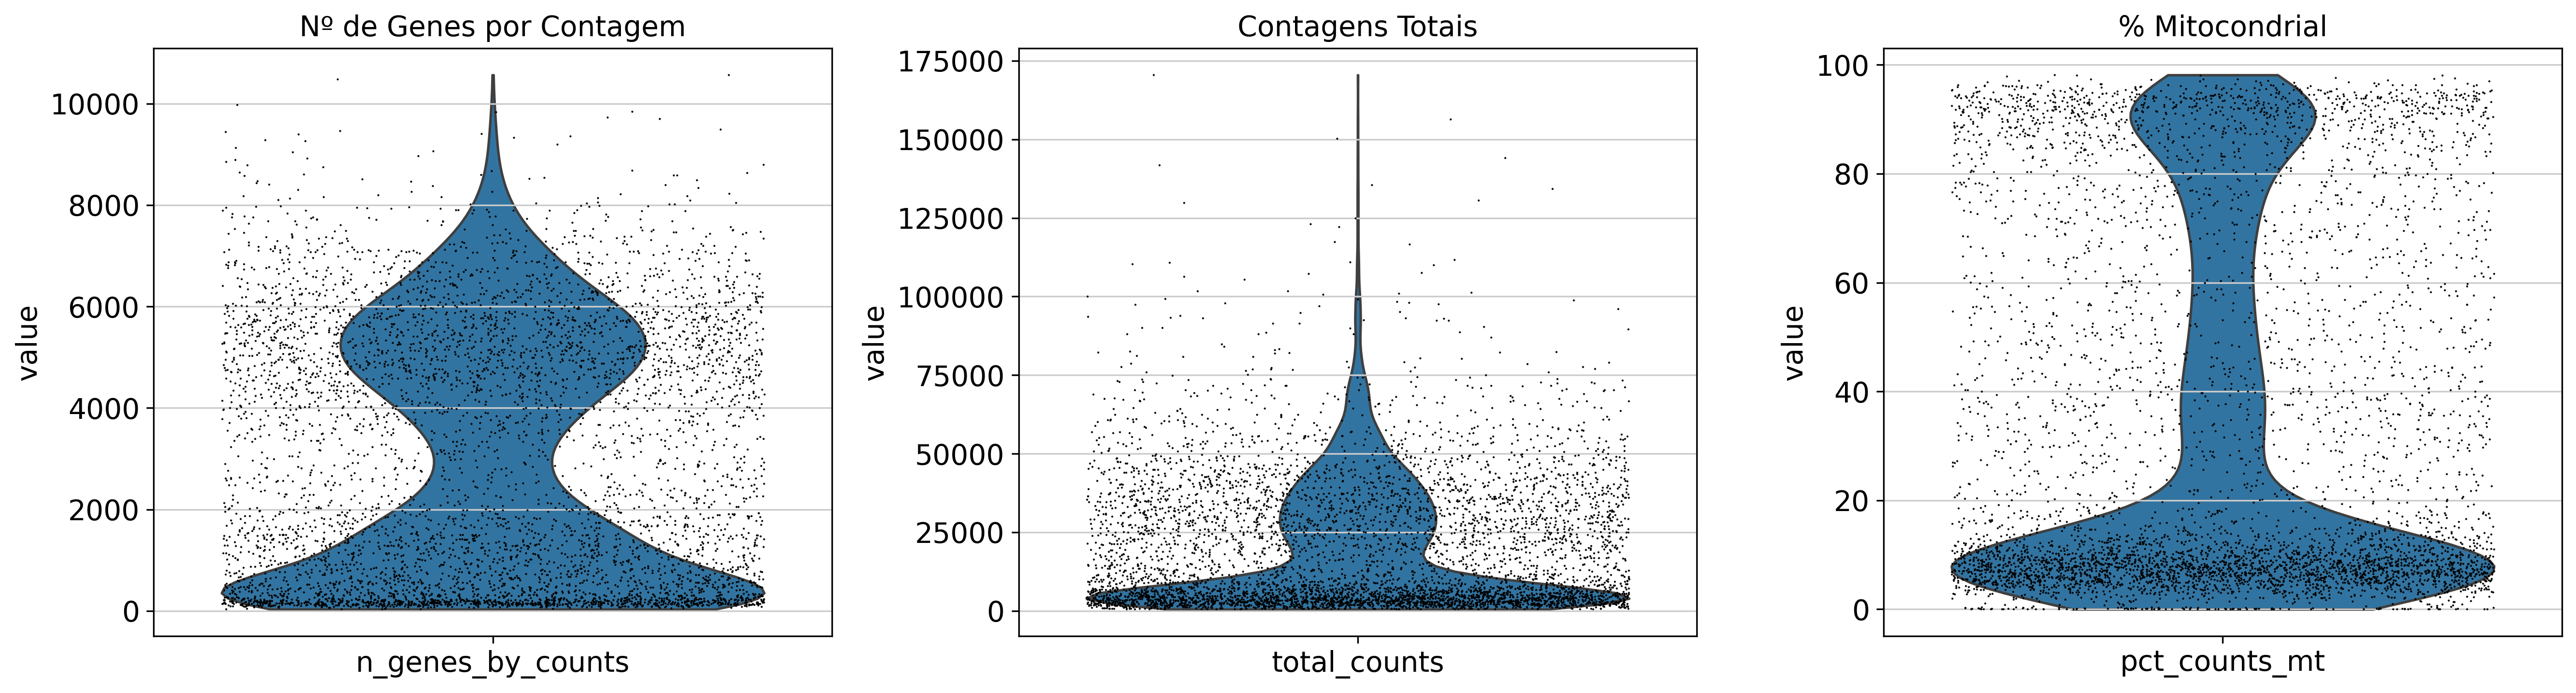

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, multi_panel=False, show=False, ax=axes[0])
axes[0].set_title('Nº de Genes por Contagem')

sc.pl.violin(adata, 'total_counts', jitter=0.4, multi_panel=False, show=False, ax=axes[1])
axes[1].set_title('Contagens Totais')

sc.pl.violin(adata, 'pct_counts_mt', jitter=0.4, multi_panel=False, show=False, ax=axes[2])
axes[2].set_title('% Mitocondrial')

plt.tight_layout()
plt.show()

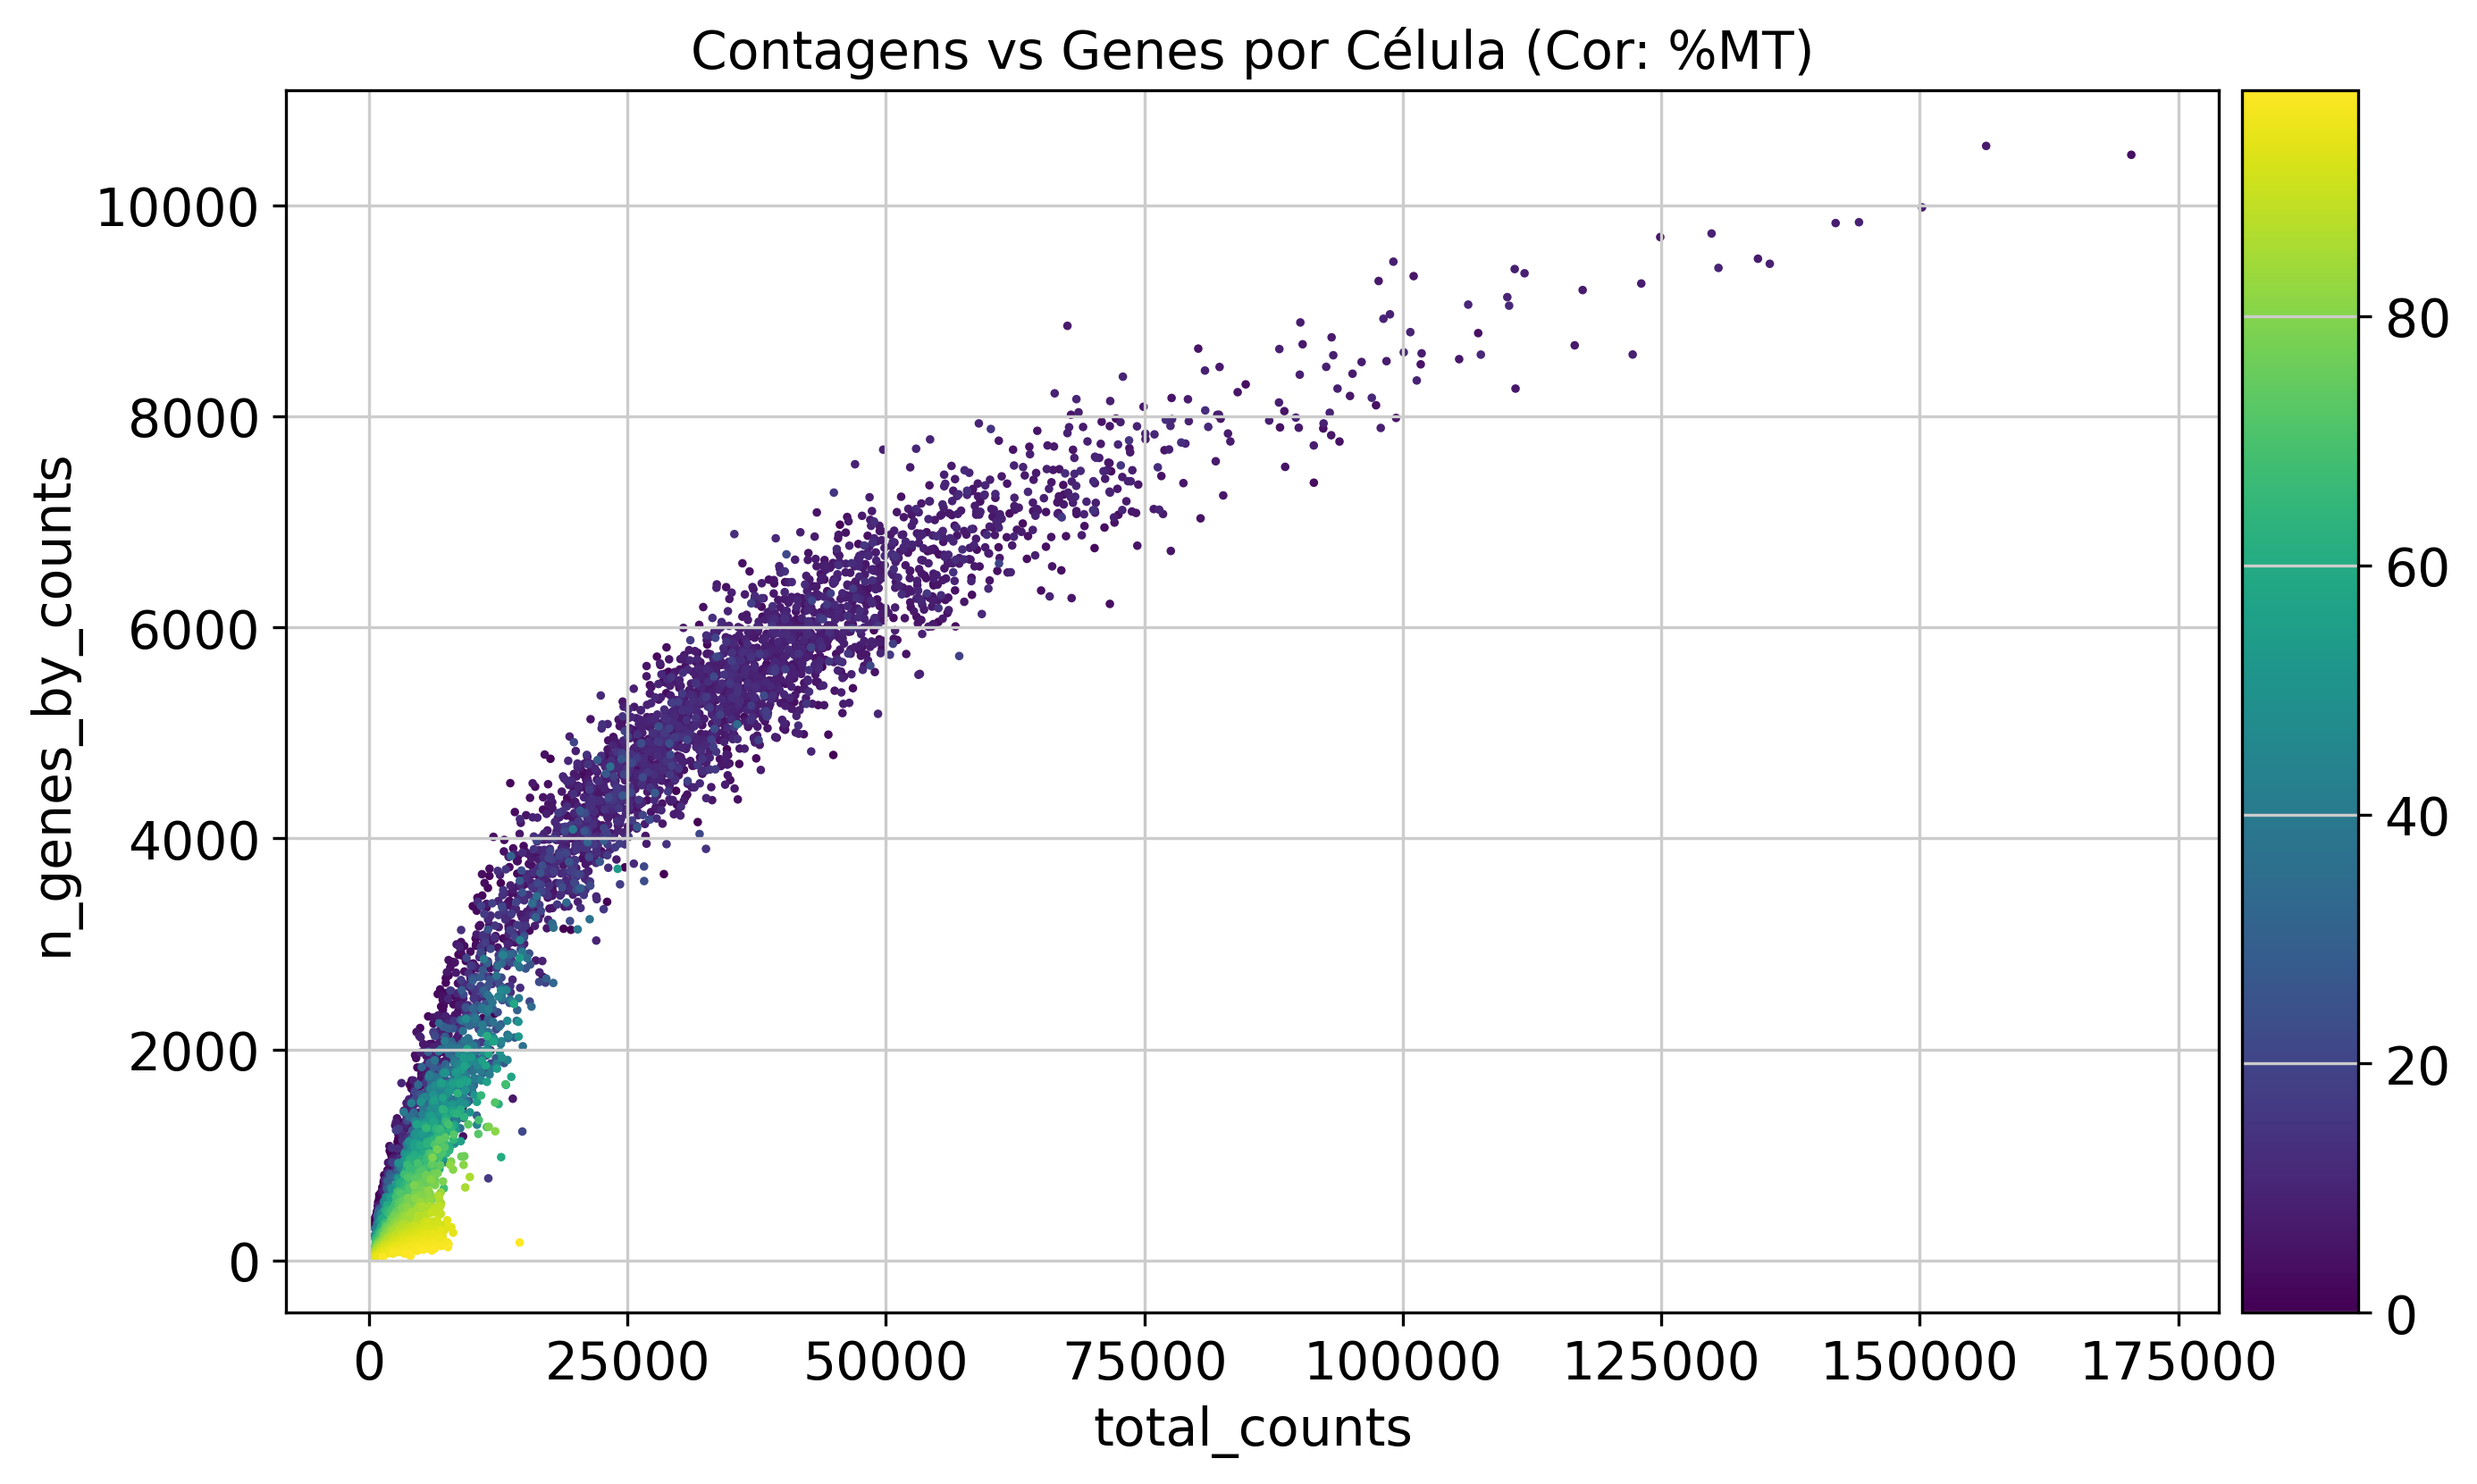

In [24]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', title='Contagens vs Genes por Célula (Cor: %MT)')
plt.show()

In [25]:
# Filtragem de células e genes
print("Aplicando filtros de qualidade...")
initial_cells = adata.shape[0]
initial_genes = adata.shape[1]

Aplicando filtros de qualidade...


In [26]:
min_total_counts = 500
max_total_counts = adata.obs['total_counts'].quantile(0.98)
min_genes = 200
max_genes = adata.obs['n_genes_by_counts'].quantile(0.98)

In [27]:
print(f"Filtrando células: min_total_counts={min_total_counts}, max_total_counts={max_total_counts:.0f}, min_genes={min_genes}, max_genes={max_genes:.0f}")
adata = adata[adata.obs['total_counts'] > min_total_counts]
adata = adata[adata.obs['total_counts'] < max_total_counts]
adata = adata[adata.obs['n_genes_by_counts'] > min_genes]
adata = adata[adata.obs['n_genes_by_counts'] < max_genes]

Filtrando células: min_total_counts=500, max_total_counts=72781, min_genes=200, max_genes=7690


In [28]:
pct_mt_threshold = 10
print(f"Filtrando células com % mitocondrial > {pct_mt_threshold}%")
adata = adata[adata.obs['pct_counts_mt'] < pct_mt_threshold, :]

Filtrando células com % mitocondrial > 10%


In [29]:
# Genes:
min_cells_for_gene = 3
print(f"Filtrando genes expressos em menos de {min_cells_for_gene} células")
sc.pp.filter_genes(adata, min_cells=min_cells_for_gene)

final_cells = adata.shape[0]
final_genes = adata.shape[1]
print(f"Células restantes após filtro: {final_cells} (removidas: {initial_cells - final_cells})")
print(f"Genes restantes após filtro: {final_genes} (removidos: {initial_genes - final_genes})")

Filtrando genes expressos em menos de 3 células
filtered out 14998 genes that are detected in less than 3 cells


/home/fnunes/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Células restantes após filtro: 2248 (removidas: 3432)
Genes restantes após filtro: 21603 (removidos: 14998)


# QC após filtros

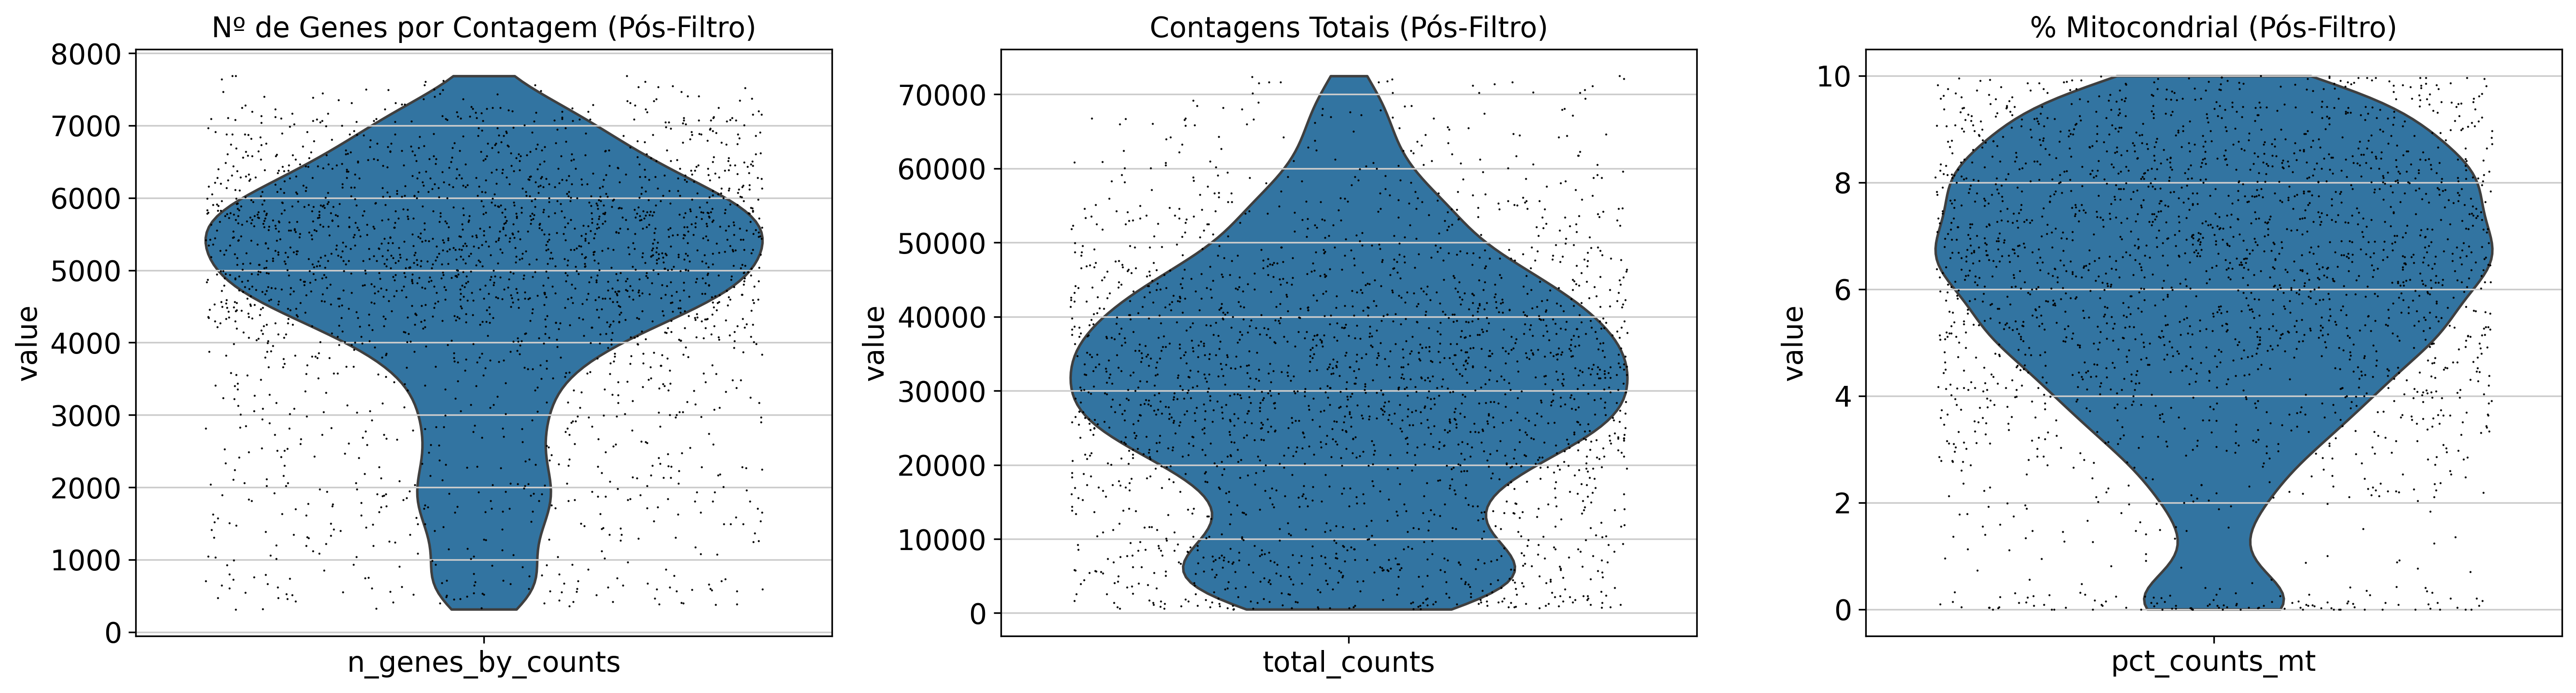

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, multi_panel=False, show=False, ax=axes[0])
axes[0].set_title('Nº de Genes por Contagem (Pós-Filtro)')

sc.pl.violin(adata, 'total_counts', jitter=0.4, multi_panel=False, show=False, ax=axes[1])
axes[1].set_title('Contagens Totais (Pós-Filtro)')

sc.pl.violin(adata, 'pct_counts_mt', jitter=0.4, multi_panel=False, show=False, ax=axes[2])
axes[2].set_title('% Mitocondrial (Pós-Filtro)')

plt.tight_layout()
plt.show()

# Normalização e Log-transformação

In [31]:
sc.pp.normalize_total(adata, target_sum=1e4) #normaliza para 10000 contagens por célula
sc.pp.log1p(adata) # log1p transformação (log(x+1))

normalizing counts per cell
    finished (0:00:00)


In [32]:
# Salva uma cópia dos dados brutos (normalizados e log-transformados) no .raw
adata.raw = adata.copy()

# Feature Selection HVGs seurat

In [33]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [34]:
adata.var

gene_ids    feature_types  genome     mt   ribo  \
AL627309.1  ENSG00000238009  Gene Expression  GRCh38  False  False   
AL627309.5  ENSG00000241860  Gene Expression  GRCh38  False  False   
AP006222.2  ENSG00000286448  Gene Expression  GRCh38  False  False   
LINC01409   ENSG00000237491  Gene Expression  GRCh38  False  False   
FAM87B      ENSG00000177757  Gene Expression  GRCh38  False  False   
...                     ...              ...     ...    ...    ...   
AL592183.1  ENSG00000273748  Gene Expression  GRCh38  False  False   
AC240274.1  ENSG00000271254  Gene Expression  GRCh38  False  False   
AC004556.3  ENSG00000276345  Gene Expression  GRCh38  False  False   
AC007325.4  ENSG00000278817  Gene Expression  GRCh38  False  False   
AC007325.2  ENSG00000277196  Gene Expression  GRCh38  False  False   

            n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
AL627309.1                 27     0.004754              99.524648   
AL627309.5                 55     0.009859              99.031690   
AP006222.2                161     0.029930              97.165493   
LINC01409                 365     0.071303              93.573944   
FAM87B                      3     0.000528              99.947183   
...                       ...          ...                    ...   
AL592183.1                 56     0.010035              99.014085   
AC240274.1                 38     0.007746              99.330986   
AC004556.3               1171     0.290845              79.383803   
AC007325.4                282     0.053873              95.035211   
AC007325.2                  3     0.000528              99.947183   

            total_counts  n_cells  highly_variable     means  dispersions  \
AL627309.1          27.0       16            False  0.002643    -0.379775   
AL627309.5          56.0       22            False  0.002946    -1.147866   
AP006222.2         170.0      101             True  0.015736     0.703434   
LINC01409          405.0      214            False  0.036923    -0.276104   
FAM87B               3.0        3            False  0.000728    -0.297176   
...                  ...      ...              ...       ...          ...   
AL592183.1          57.0       38            False  0.005968    -0.694627   
AC240274.1          44.0       29            False  0.007445    -0.026215   
AC004556.3        1652.0      784            False  0.153865     0.041676   
AC007325.4         306.0      196             True  0.035504     0.950929   
AC007325.2           3.0        3            False  0.000394    -1.073062   

            dispersions_norm  
AL627309.1         -0.167606  
AL627309.5         -1.174832  
AP006222.2          1.252845  
LINC01409          -0.031658  
FAM87B             -0.059291  
...                      ...  
AL592183.1         -0.580483  
AC240274.1          0.296030  
AC004556.3          0.385058  
AC007325.4          1.577394  
AC007325.2         -1.076738  

[21603 rows x 14 columns]

# numero de genes HVGs = 4010

In [35]:
np.sum(adata.var.highly_variable)

np.int64(4010)

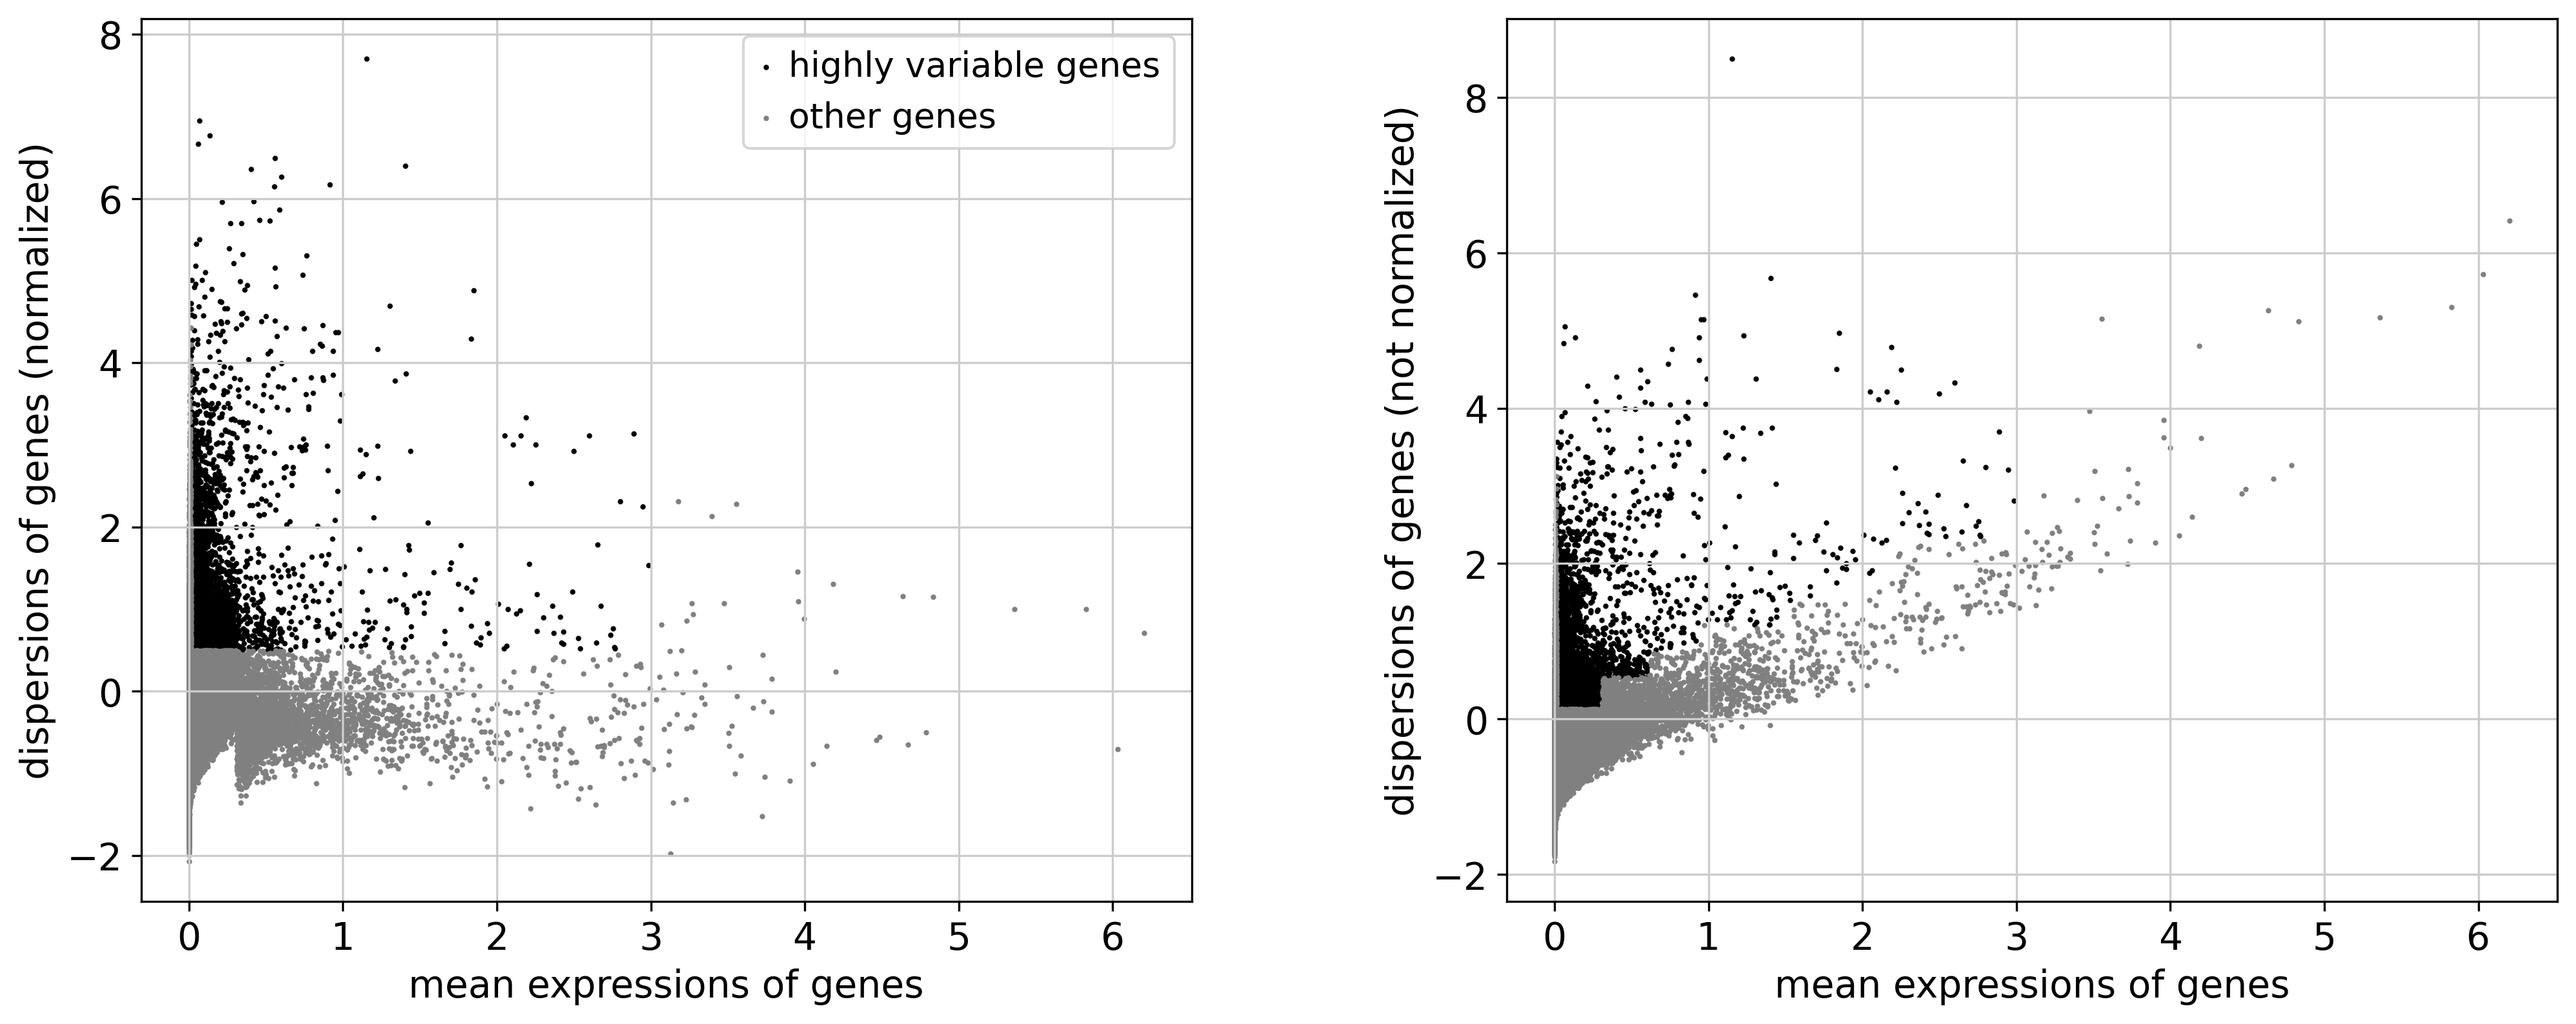

In [36]:
sc.pl.highly_variable_genes(adata)
plt.show()

# Filtrar anndata para incluir apenas HVGs

In [37]:
adata = adata[:, adata.var.highly_variable]
print(f"Dimensões AnnData após seleção de HVGs: {adata.shape}")

Dimensões AnnData após seleção de HVGs: (2248, 4010)


# Data scaling

In [38]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/fnunes/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


# PCA - 50 pcs

In [39]:
n_pca_components = 50
sc.pp.pca(adata, n_comps=n_pca_components)

computing PCA
    with n_comps=50
    finished (0:00:00)


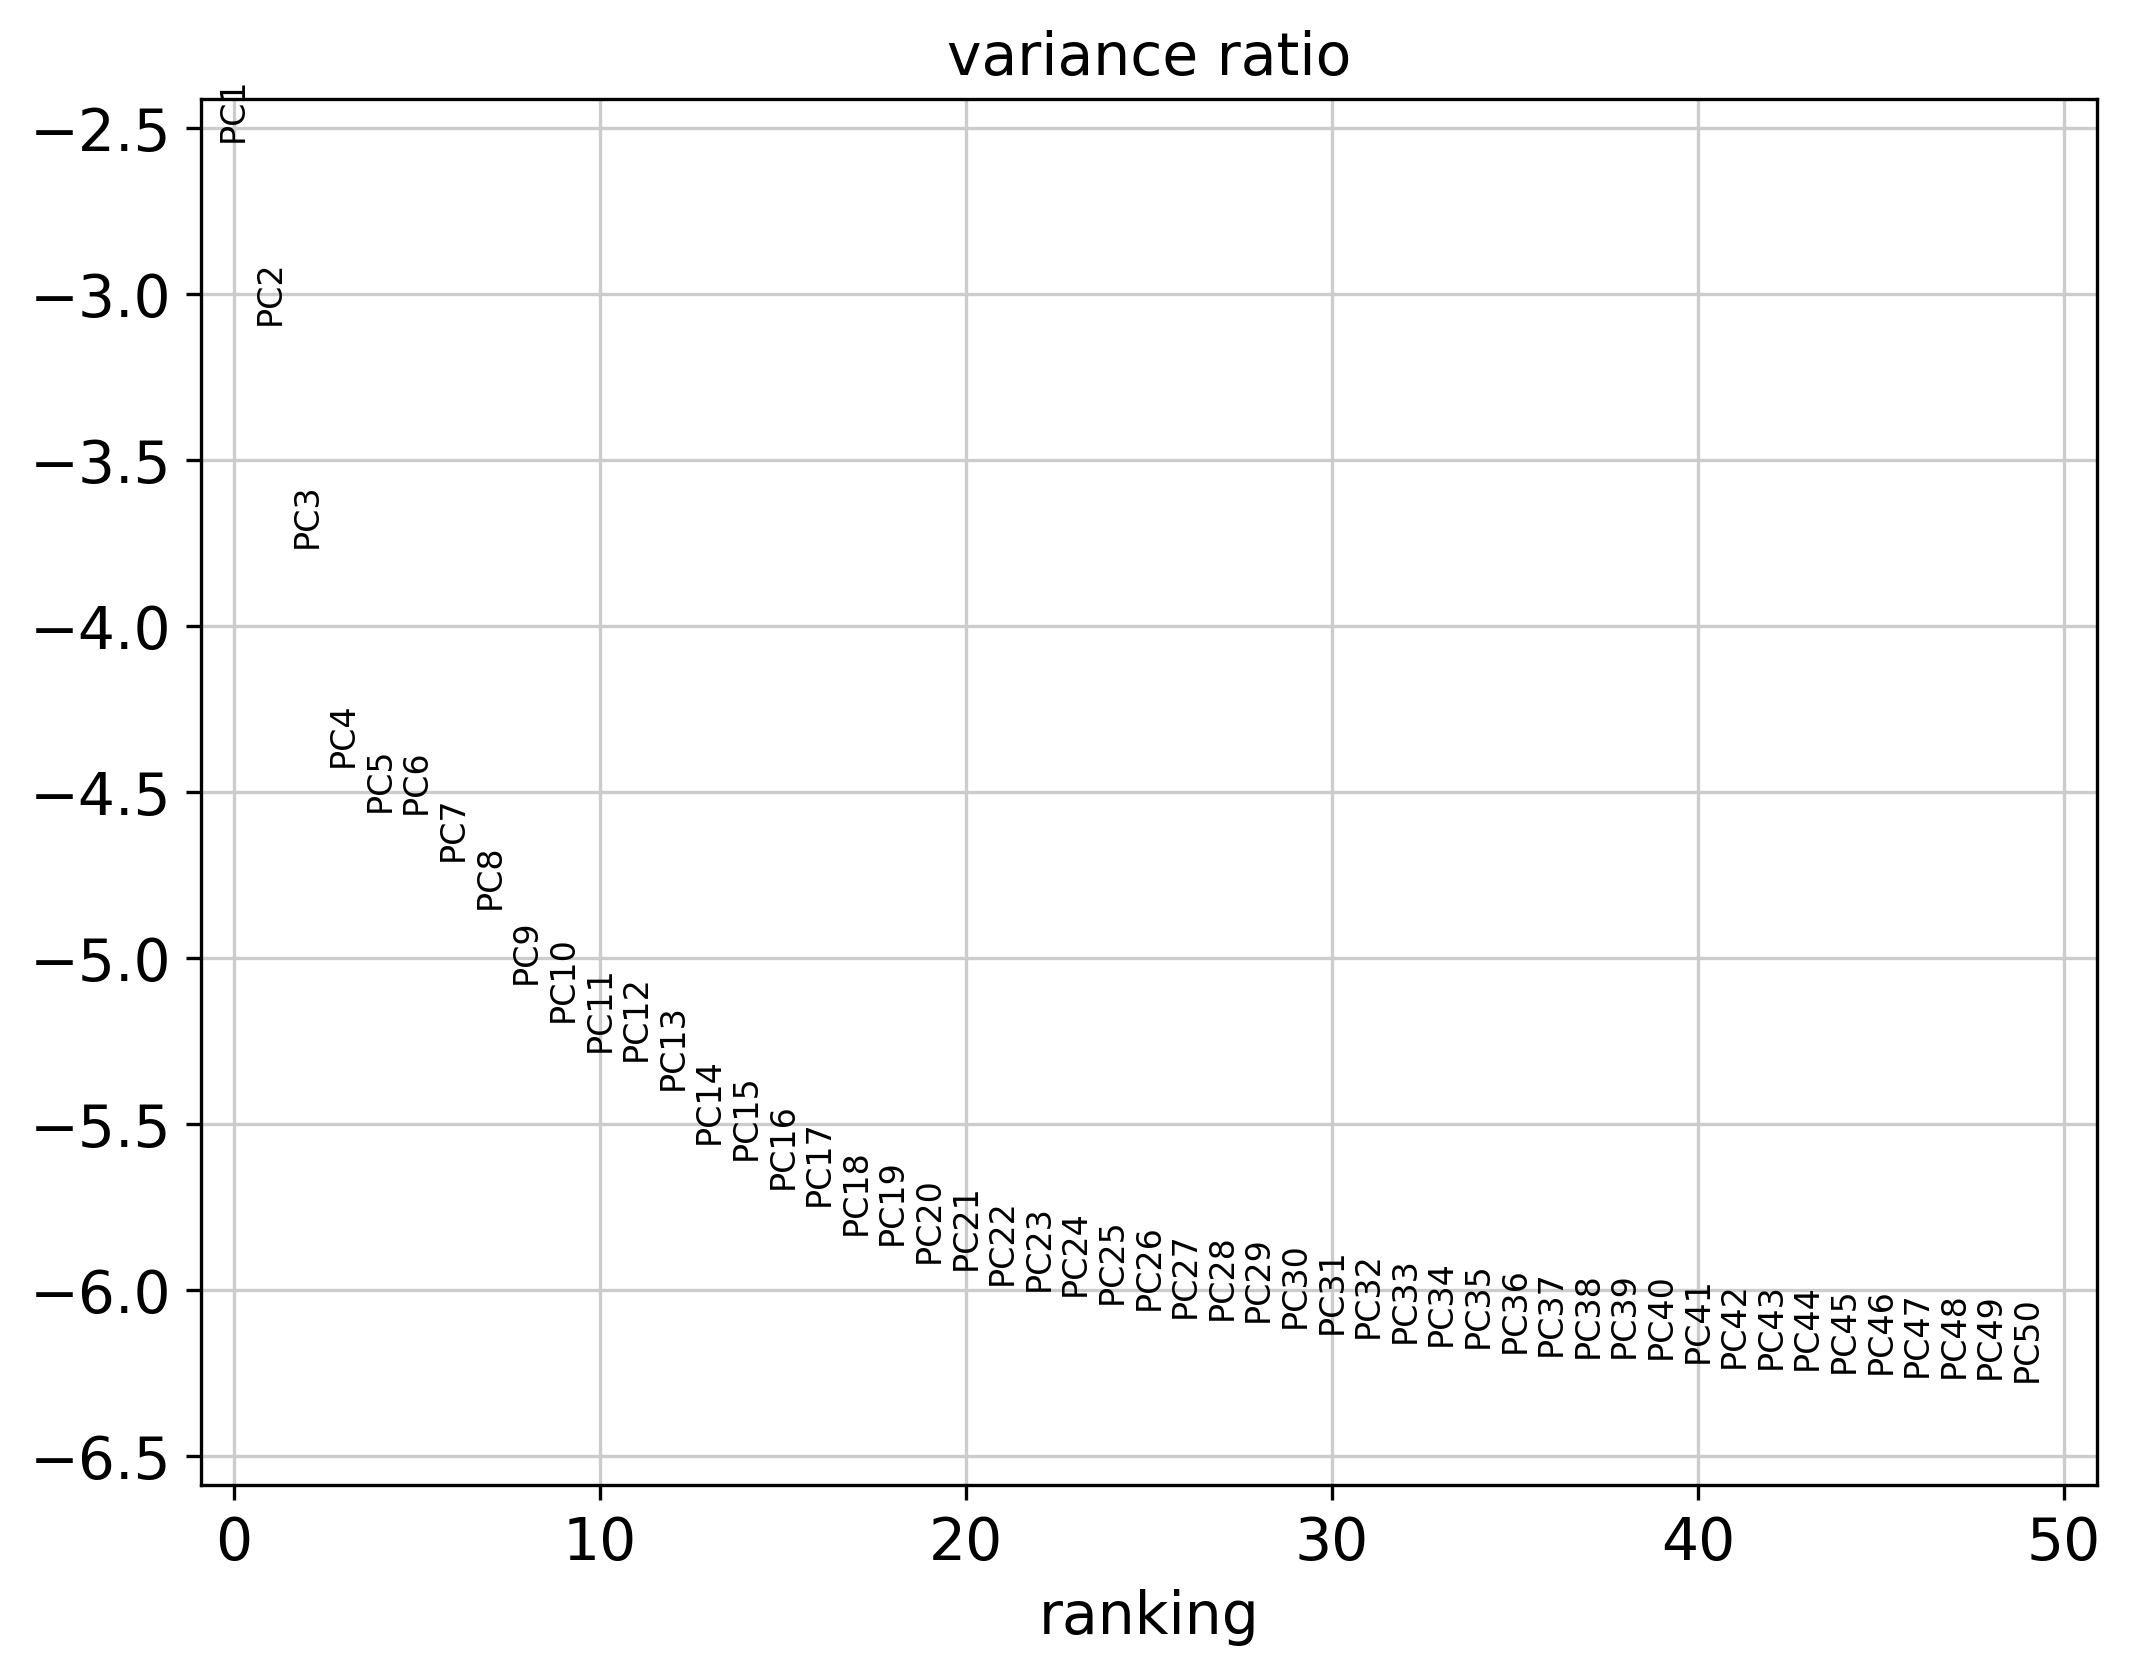

In [40]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=n_pca_components)
plt.show()

# Neihjbor graph

In [41]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


# UMAP de embeddings

In [42]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


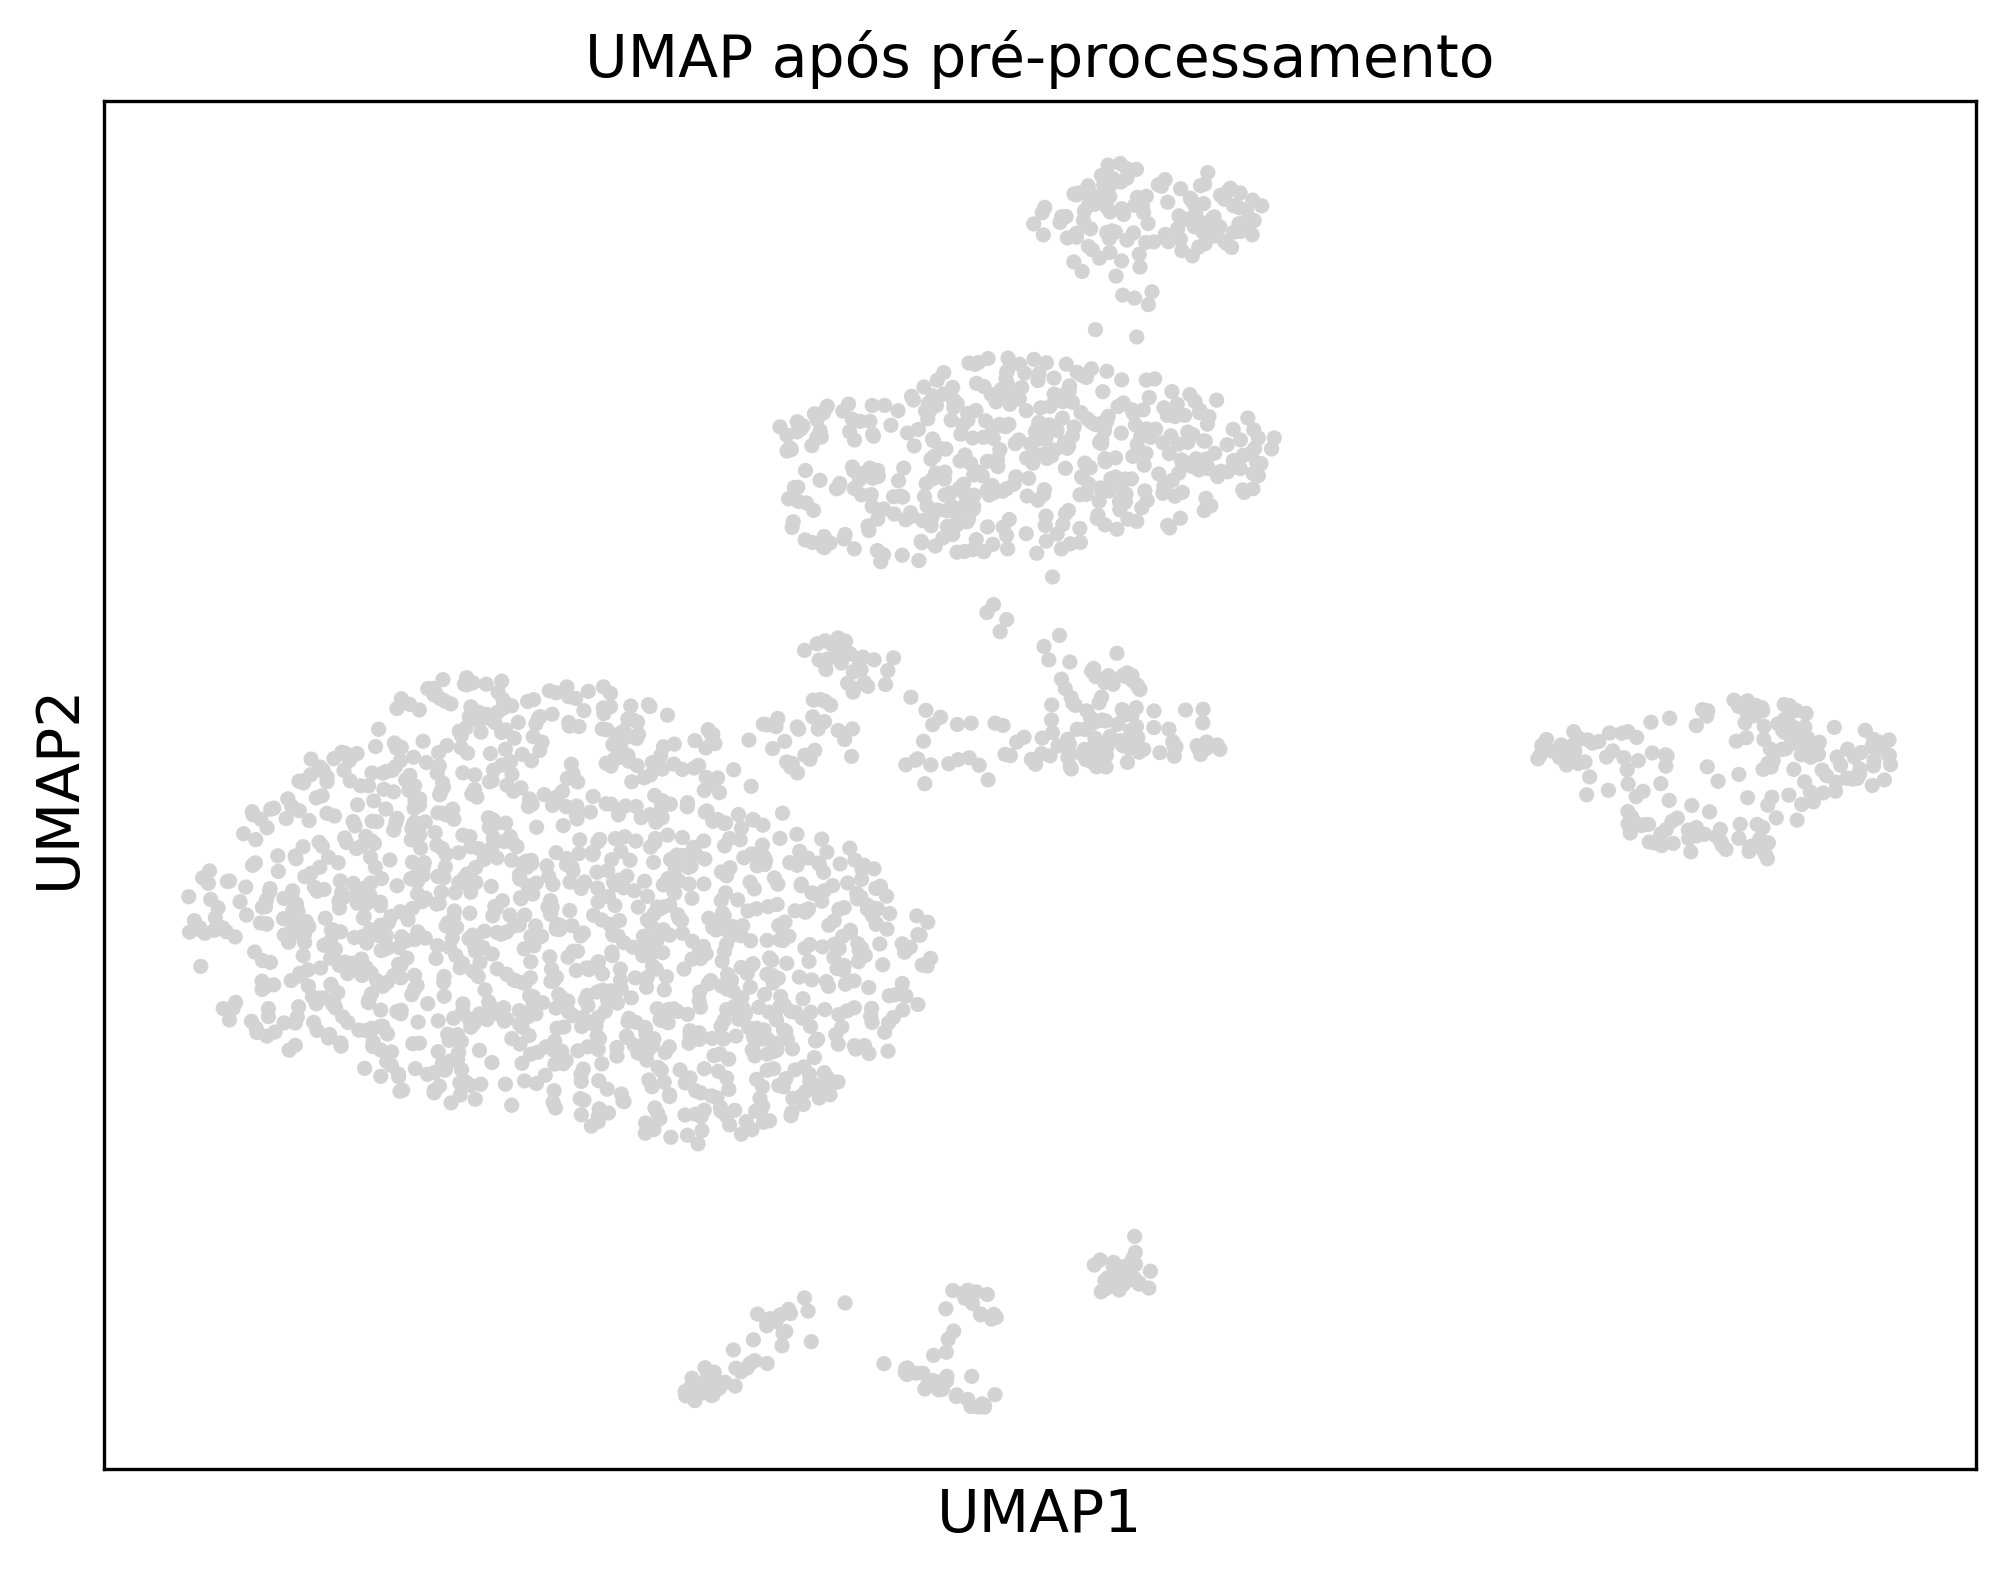

In [43]:
sc.pl.umap(adata, title='UMAP após pré-processamento')
plt.show()

# Agrupamento (Clustering - Leiden)

In [44]:
resolution_value = 0.5
sc.tl.leiden(adata, resolution=resolution_value)
print(f" Leiden com resolução {resolution_value}.")

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
 Leiden com resolução 0.5.


/tmp/ipykernel_1166841/4175054355.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution_value)


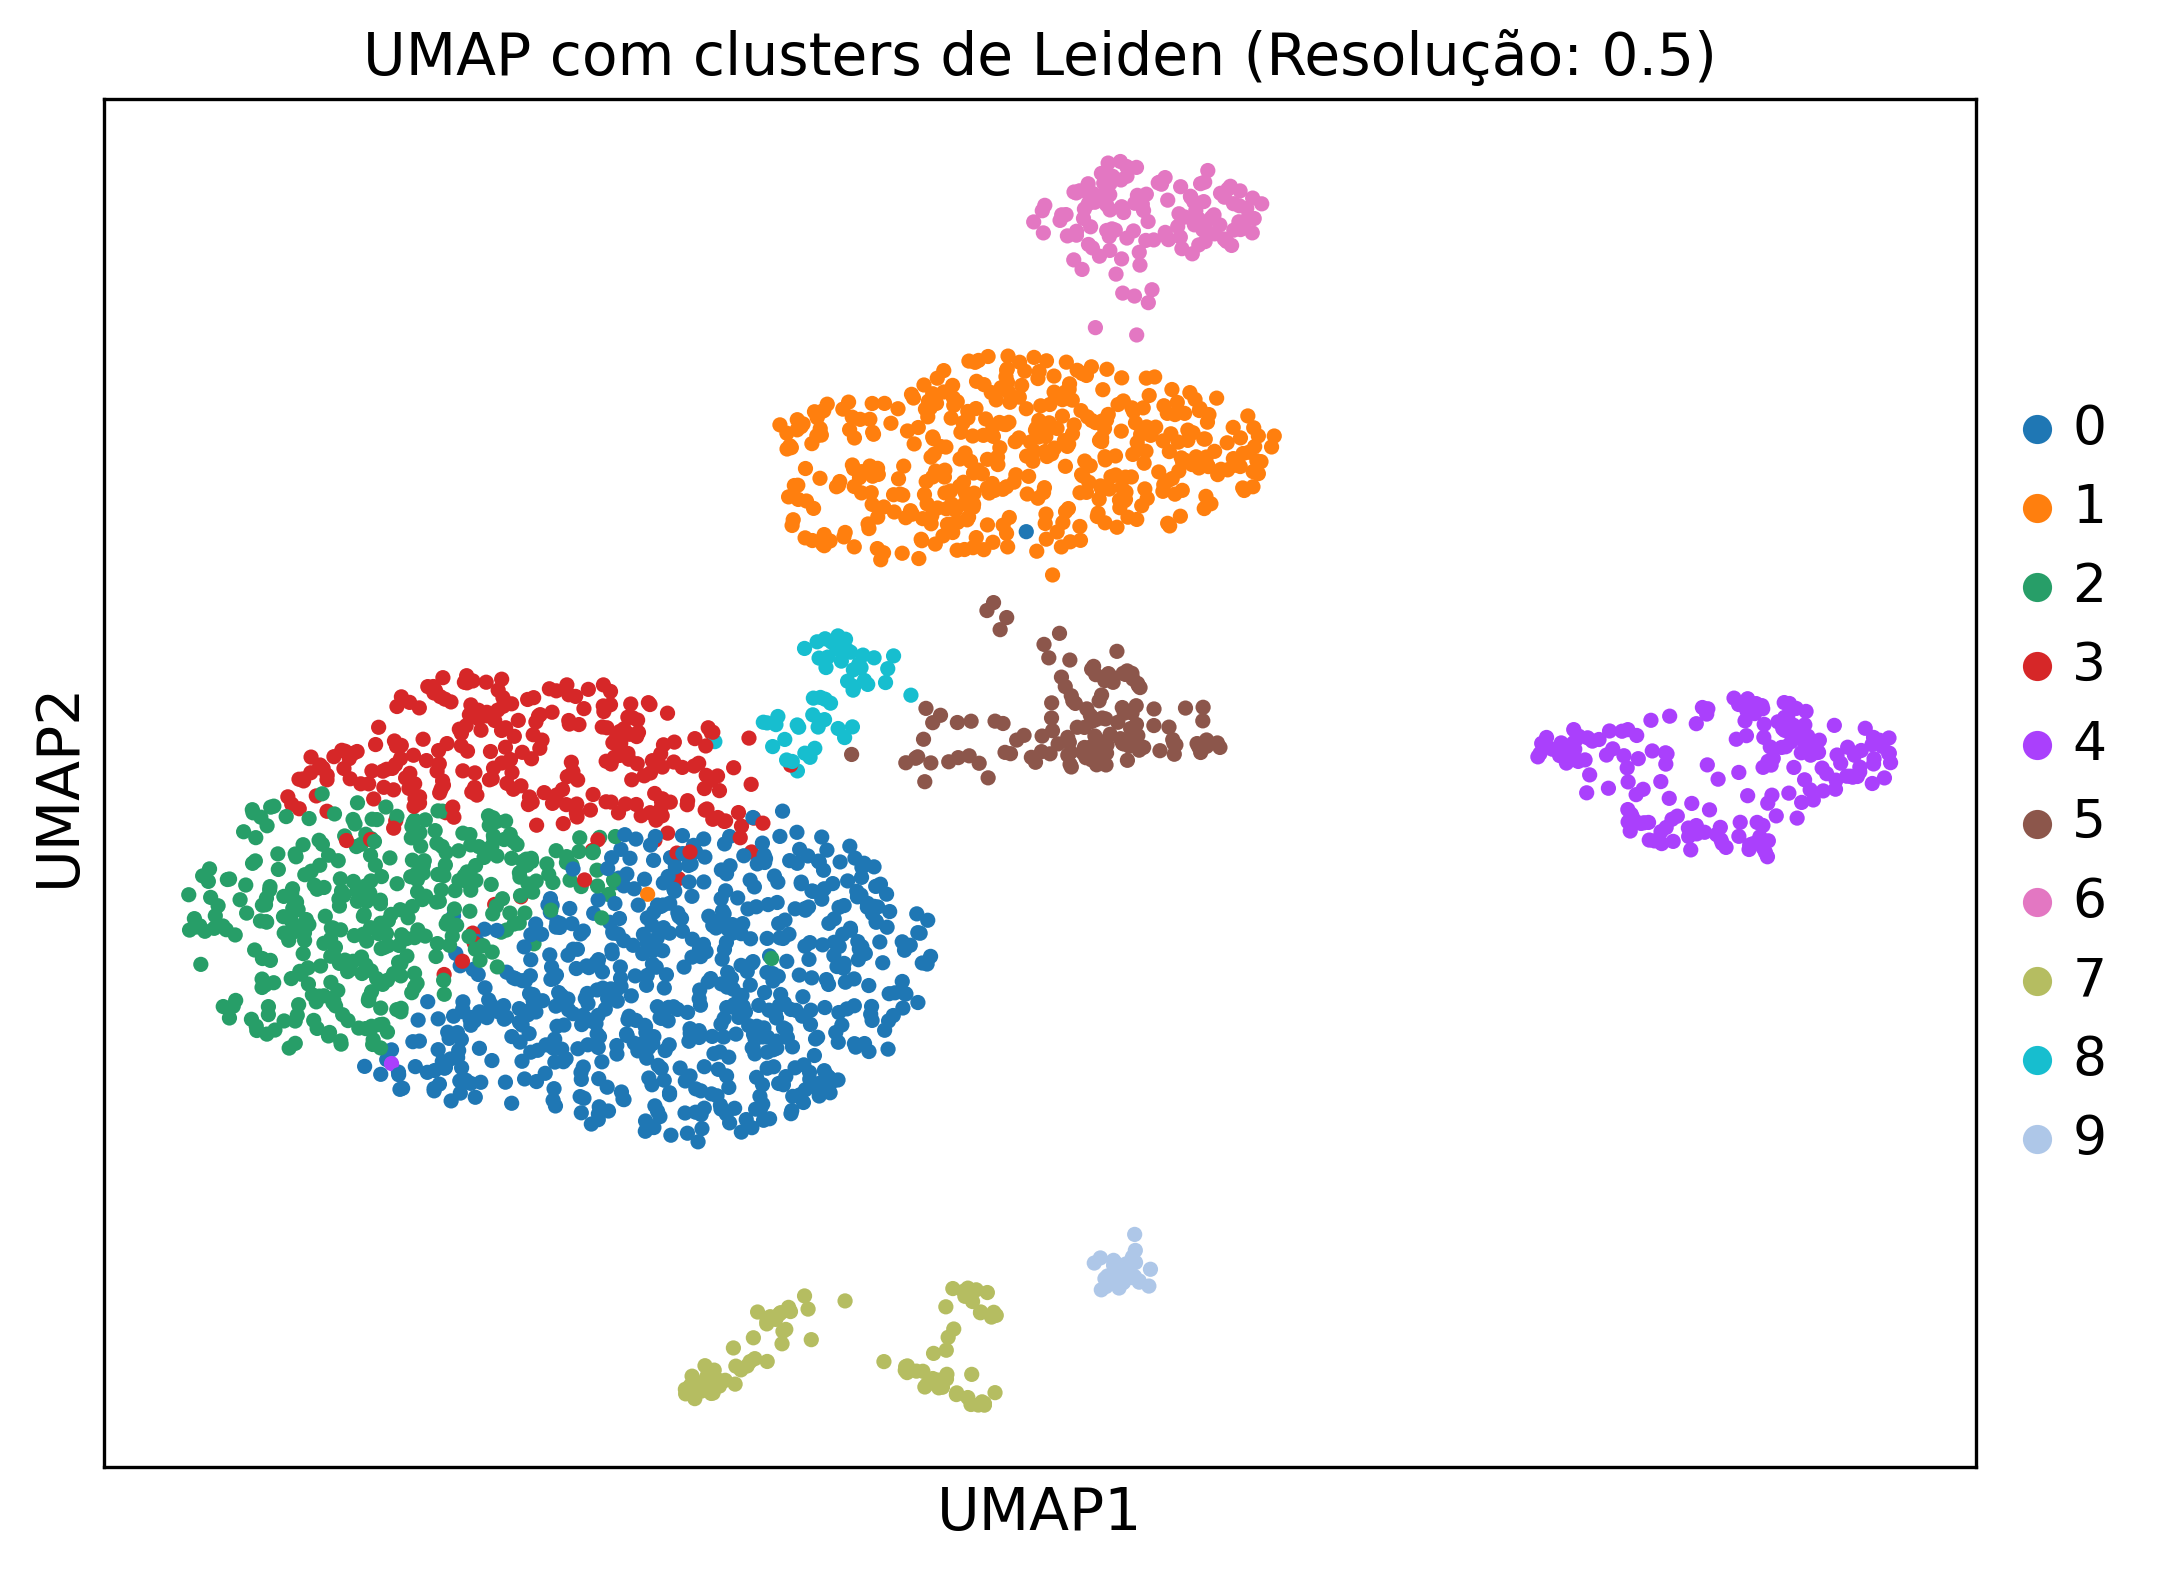

In [45]:
sc.pl.umap(adata, color='leiden', title=f'UMAP com clusters de Leiden (Resolução: {resolution_value})')
plt.show()

# salvar dados processados em .h5ad

In [46]:
output_file = 'breast_cancer_processed.h5ad'
adata.write(output_file)

In [48]:
adata.obs_names

Index(['AAACCCAGTCGTCATA-1', 'AAACCCATCCTTCTTC-1', 'AAACCCATCGCCCAGA-1',
       'AAACGAAAGCTCGCAC-1', 'AAACGAAAGGTAATCA-1', 'AAACGCTAGAGAGCAA-1',
       'AAAGAACCAGAACATA-1', 'AAAGAACCATATGGCT-1', 'AAAGAACGTGCATCTA-1',
       'AAAGAACTCTCCCAAC-1',
       ...
       'TTTCCTCTCTCTCCGA-1', 'TTTCGATTCGACATAC-1', 'TTTGACTCAACATACC-1',
       'TTTGATCGTGAATTAG-1', 'TTTGGAGGTTGCCTAA-1', 'TTTGGTTCATTGCCTC-1',
       'TTTGGTTGTGATCGTT-1', 'TTTGGTTGTGGAGGTT-1', 'TTTGGTTTCTAGACCA-1',
       'TTTGTTGTCGATGCAT-1'],
      dtype='object', length=2248)

##########################################################


# mais exploração e tentando anotar as celulas
# sabemos que temos 10 tipos apriori

In [49]:
adata.var.head()

gene_ids    feature_types  genome     mt   ribo  \
AP006222.2  ENSG00000286448  Gene Expression  GRCh38  False  False   
FAM41C      ENSG00000230368  Gene Expression  GRCh38  False  False   
HES4        ENSG00000188290  Gene Expression  GRCh38  False  False   
ISG15       ENSG00000187608  Gene Expression  GRCh38  False  False   
TNFRSF4     ENSG00000186827  Gene Expression  GRCh38  False  False   

            n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
AP006222.2                161     0.029930              97.165493   
FAM41C                    276     0.052289              95.140845   
HES4                     2597     1.413204              54.278169   
ISG15                    2672     2.650000              52.957746   
TNFRSF4                    29     0.013204              99.489437   

            total_counts  n_cells  highly_variable     means  dispersions  \
AP006222.2         170.0      101             True  0.015736     0.703434   
FAM41C             297.0      172             True  0.029508     0.761998   
HES4              8027.0     1589             True  0.621496     0.951188   
ISG15            15052.0     1748             True  1.109645     3.369066   
TNFRSF4             75.0       25             True  0.026532     1.477006   

            dispersions_norm      mean       std  
AP006222.2          1.252845  0.011706  0.069726  
FAM41C              1.329642  0.022051  0.096437  
HES4                0.587044  0.471673  0.480588  
ISG15               2.616266  0.646808  0.703820  
TNFRSF4             2.267258  0.011846  0.125579

normalizing counts per cell
    finished (0:00:00)


/home/fnunes/miniconda3/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


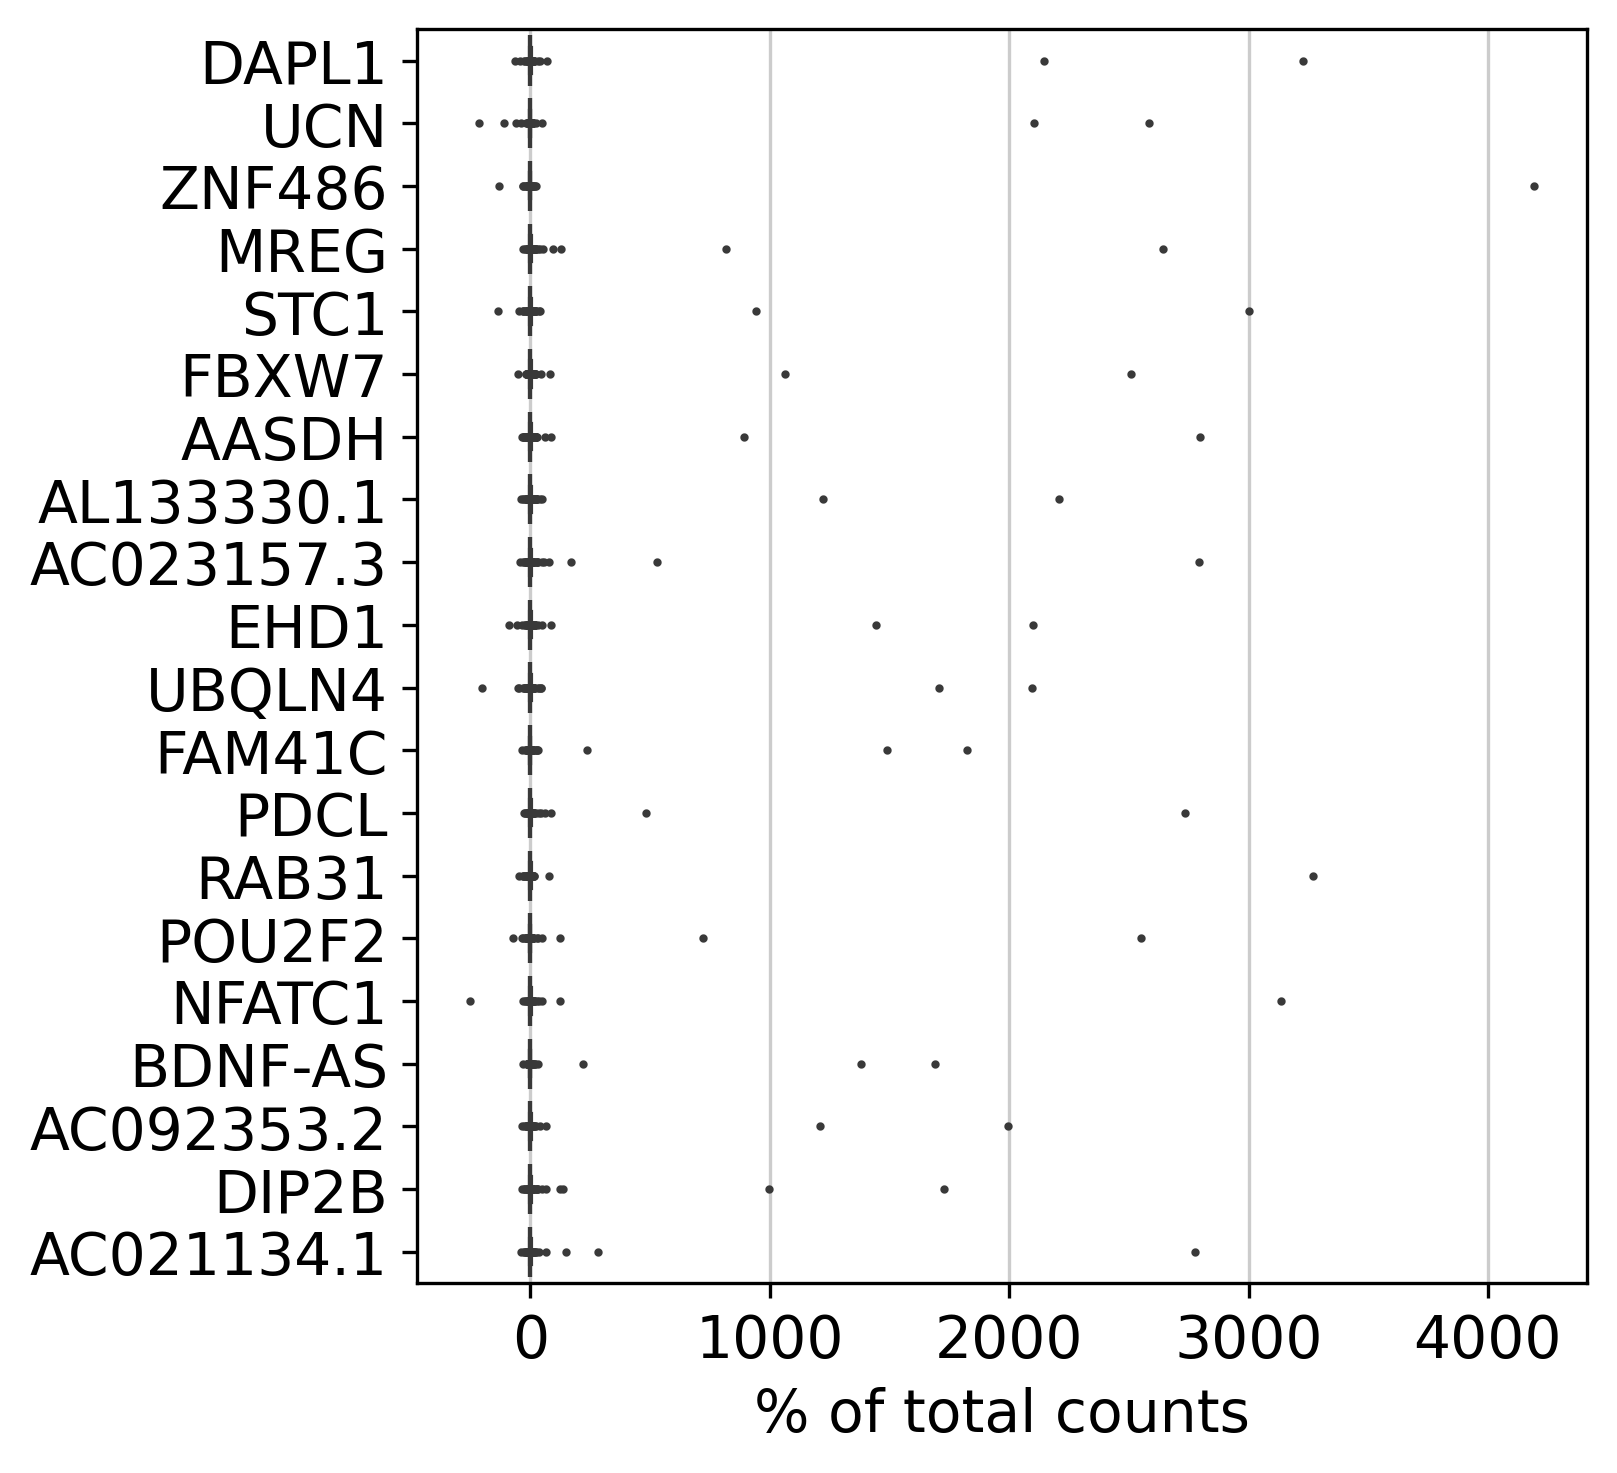

In [50]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Find marker genes
* sc.tl.rank_genes_groups(adata, "clusters", method="t-test"): This function performs differential gene expression analysis between different clusters defined by the "clusters" column in the adata.obs dataframe. It compares the gene expression profiles between the clusters using a statistical test, such as the t-test, to identify genes that are differentially expressed between the clusters. The results of the analysis are stored in the adata object.

In [56]:
sc.tl.leiden(adata, resolution=0.6, key_added="clusters")

running Leiden clustering
    finished: found 11 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


In [57]:
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")  #Group by clusters and perform differential gene expression analysis using t-tets (also try 'wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [58]:
adata.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTCGTCATA-1               6058       49372.0           2388.0   
AAACCCATCCTTCTTC-1               2081        7170.0            279.0   
AAACCCATCGCCCAGA-1                389         711.0              5.0   
AAACGAAAGCTCGCAC-1               4984       44434.0           1490.0   
AAACGAAAGGTAATCA-1               3459       10951.0            238.0   
...                               ...           ...              ...   
TTTGGTTCATTGCCTC-1               6448       55491.0           3677.0   
TTTGGTTGTGATCGTT-1               4934       28384.0           2409.0   
TTTGGTTGTGGAGGTT-1               4419       24987.0            777.0   
TTTGGTTTCTAGACCA-1               7122       64627.0           4276.0   
TTTGTTGTCGATGCAT-1               4656       29854.0           2214.0   

                    pct_counts_mt  total_counts_ribo  pct_counts_ribo leiden  \
AAACCCAGTCGTCATA-1       4.836750             8641.0        17.501823      0   
AAACCCATCCTTCTTC-1       3.891213              678.0         9.456067      4   
AAACCCATCGCCCAGA-1       0.703235              150.0        21.097046      5   
AAACGAAAGCTCGCAC-1       3.353288             3510.0         7.899357      6   
AAACGAAAGGTAATCA-1       2.173318             1402.0        12.802484      9   
...                           ...                ...              ...    ...   
TTTGGTTCATTGCCTC-1       6.626300             8166.0        14.715899      2   
TTTGGTTGTGATCGTT-1       8.487176             4372.0        15.403044      0   
TTTGGTTGTGGAGGTT-1       3.109617             2551.0        10.209309      1   
TTTGGTTTCTAGACCA-1       6.616430            10089.0        15.611122      2   
TTTGTTGTCGATGCAT-1       7.416092             4441.0        14.875728      0   

                   clusters  
AAACCCAGTCGTCATA-1        4  
AAACCCATCCTTCTTC-1        5  
AAACCCATCGCCCAGA-1        6  
AAACGAAAGCTCGCAC-1        7  
AAACGAAAGGTAATCA-1       10  
...                     ...  
TTTGGTTCATTGCCTC-1        2  
TTTGGTTGTGATCGTT-1        4  
TTTGGTTGTGGAGGTT-1        0  
TTTGGTTTCTAGACCA-1        2  
TTTGTTGTCGATGCAT-1        1  

[2248 rows x 8 columns]

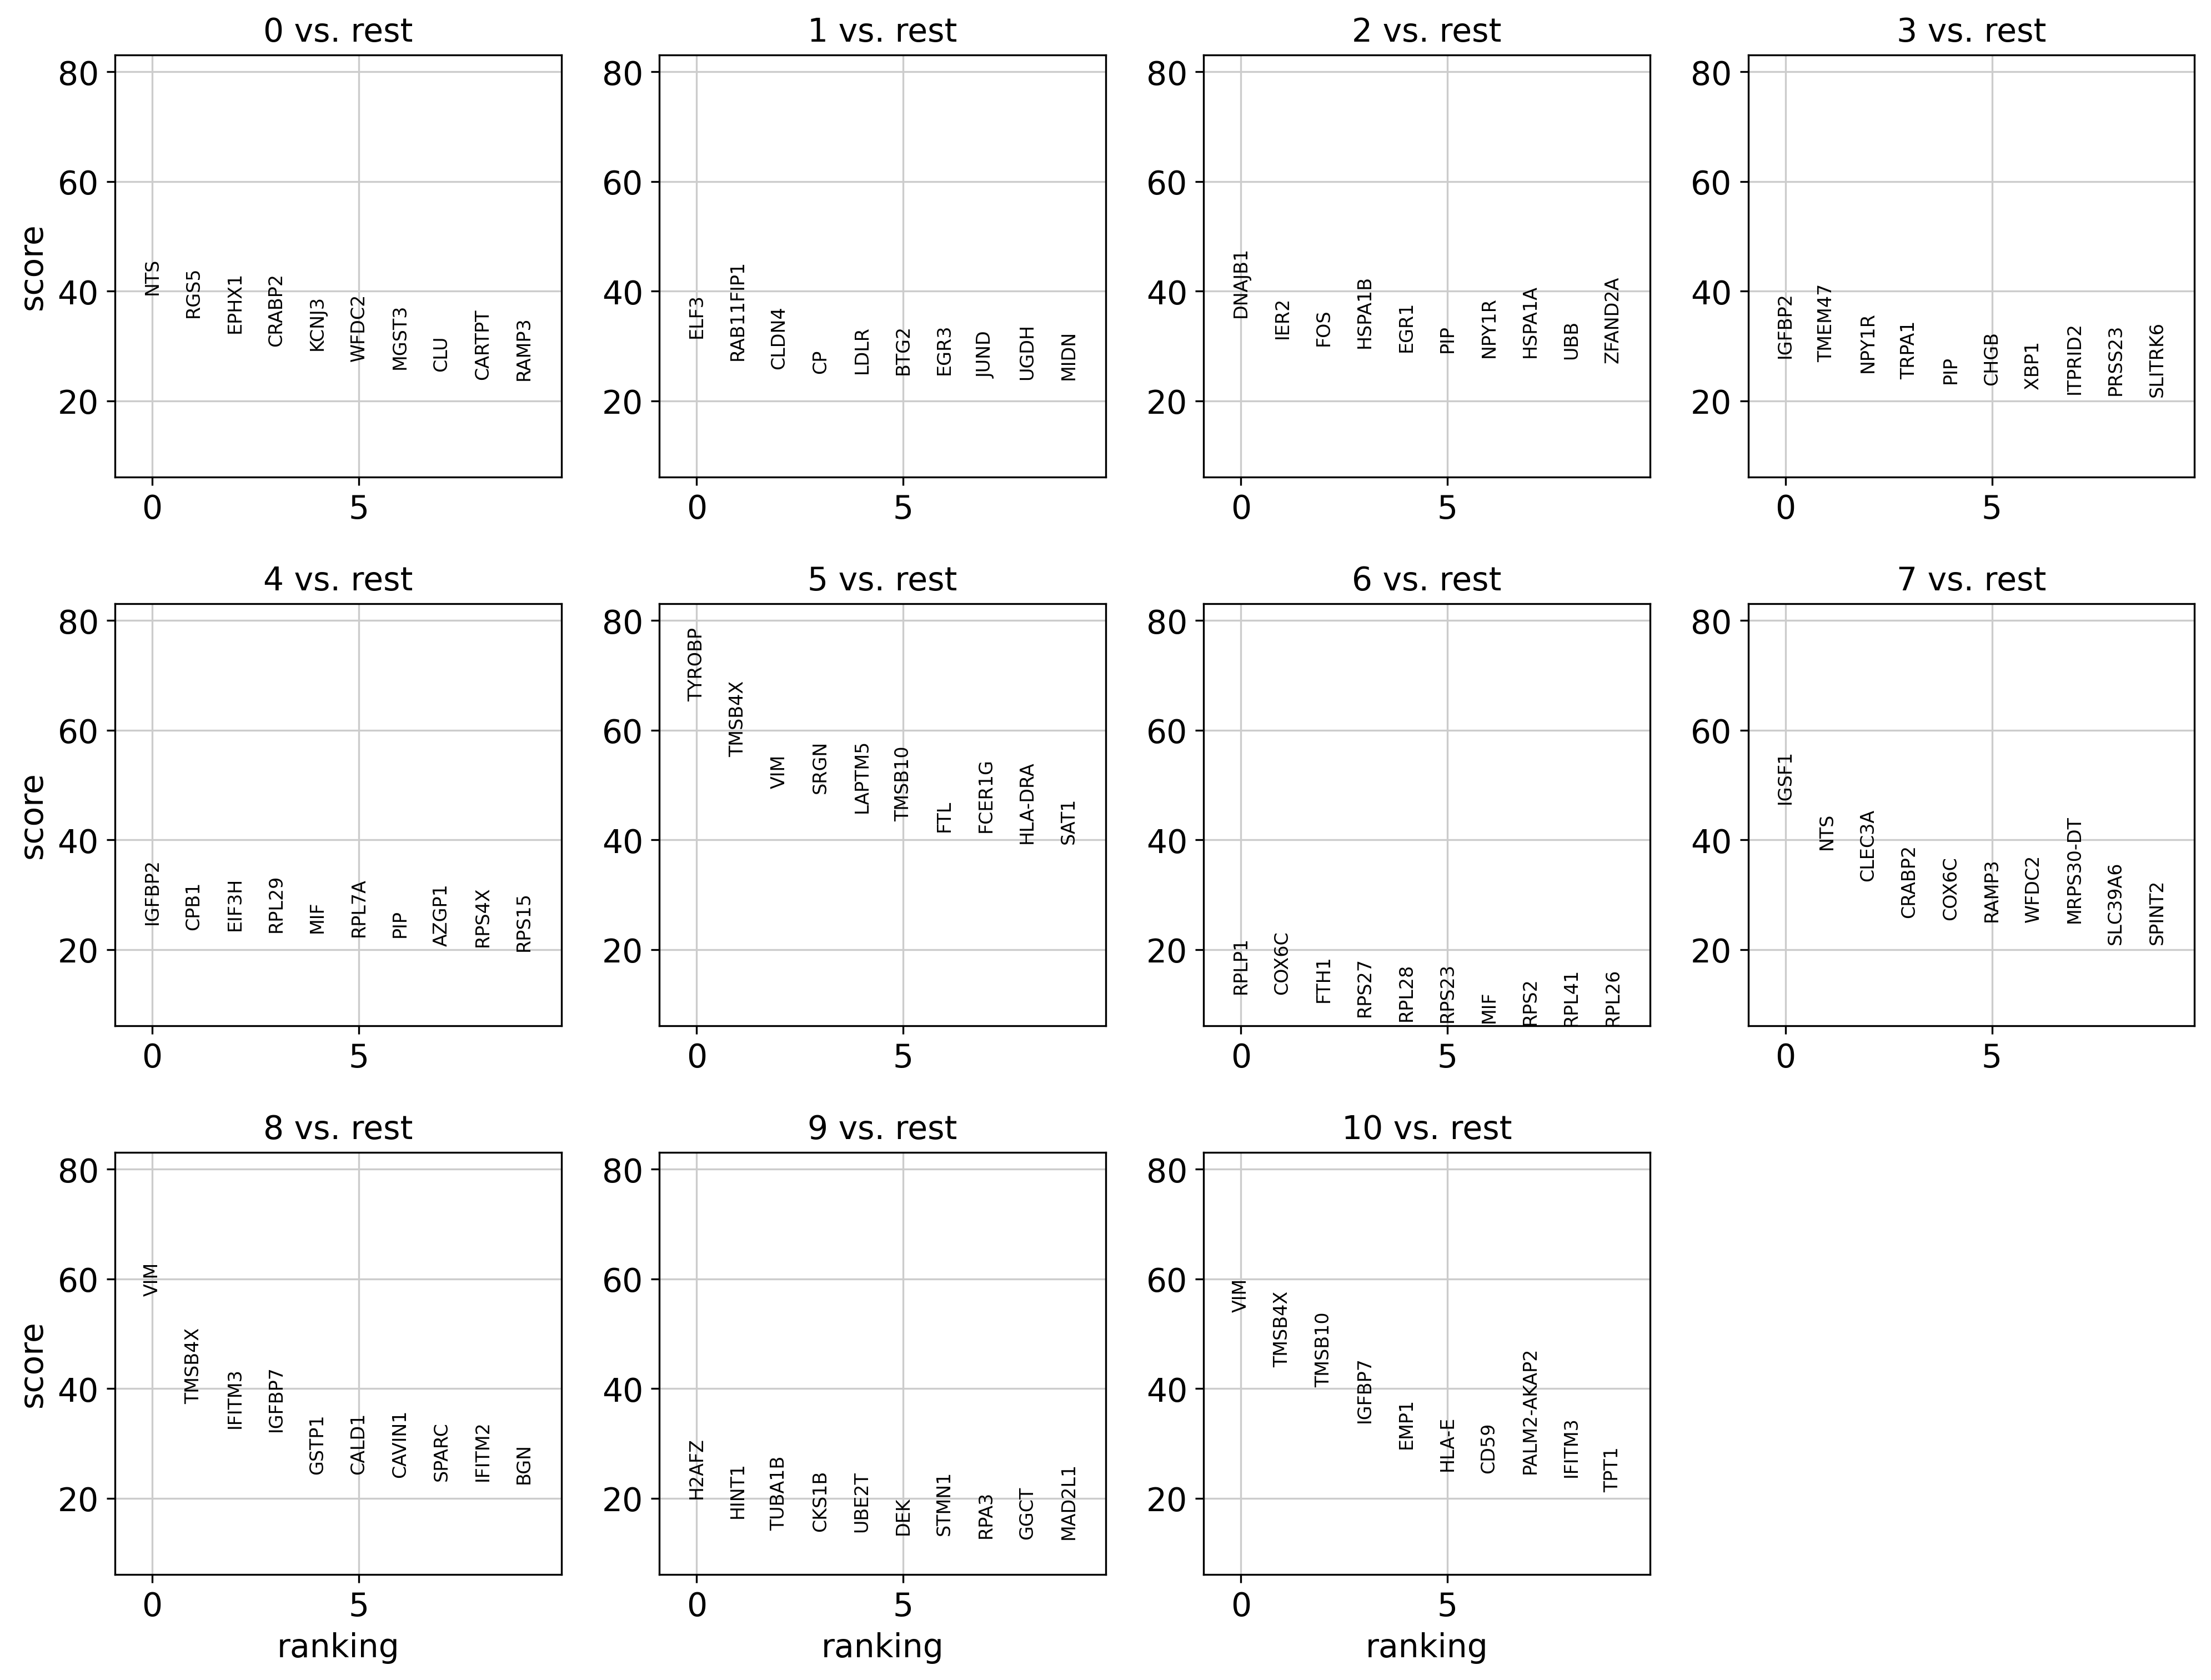

In [62]:
sc.pl.rank_genes_groups(adata, n_genes=10)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: 6


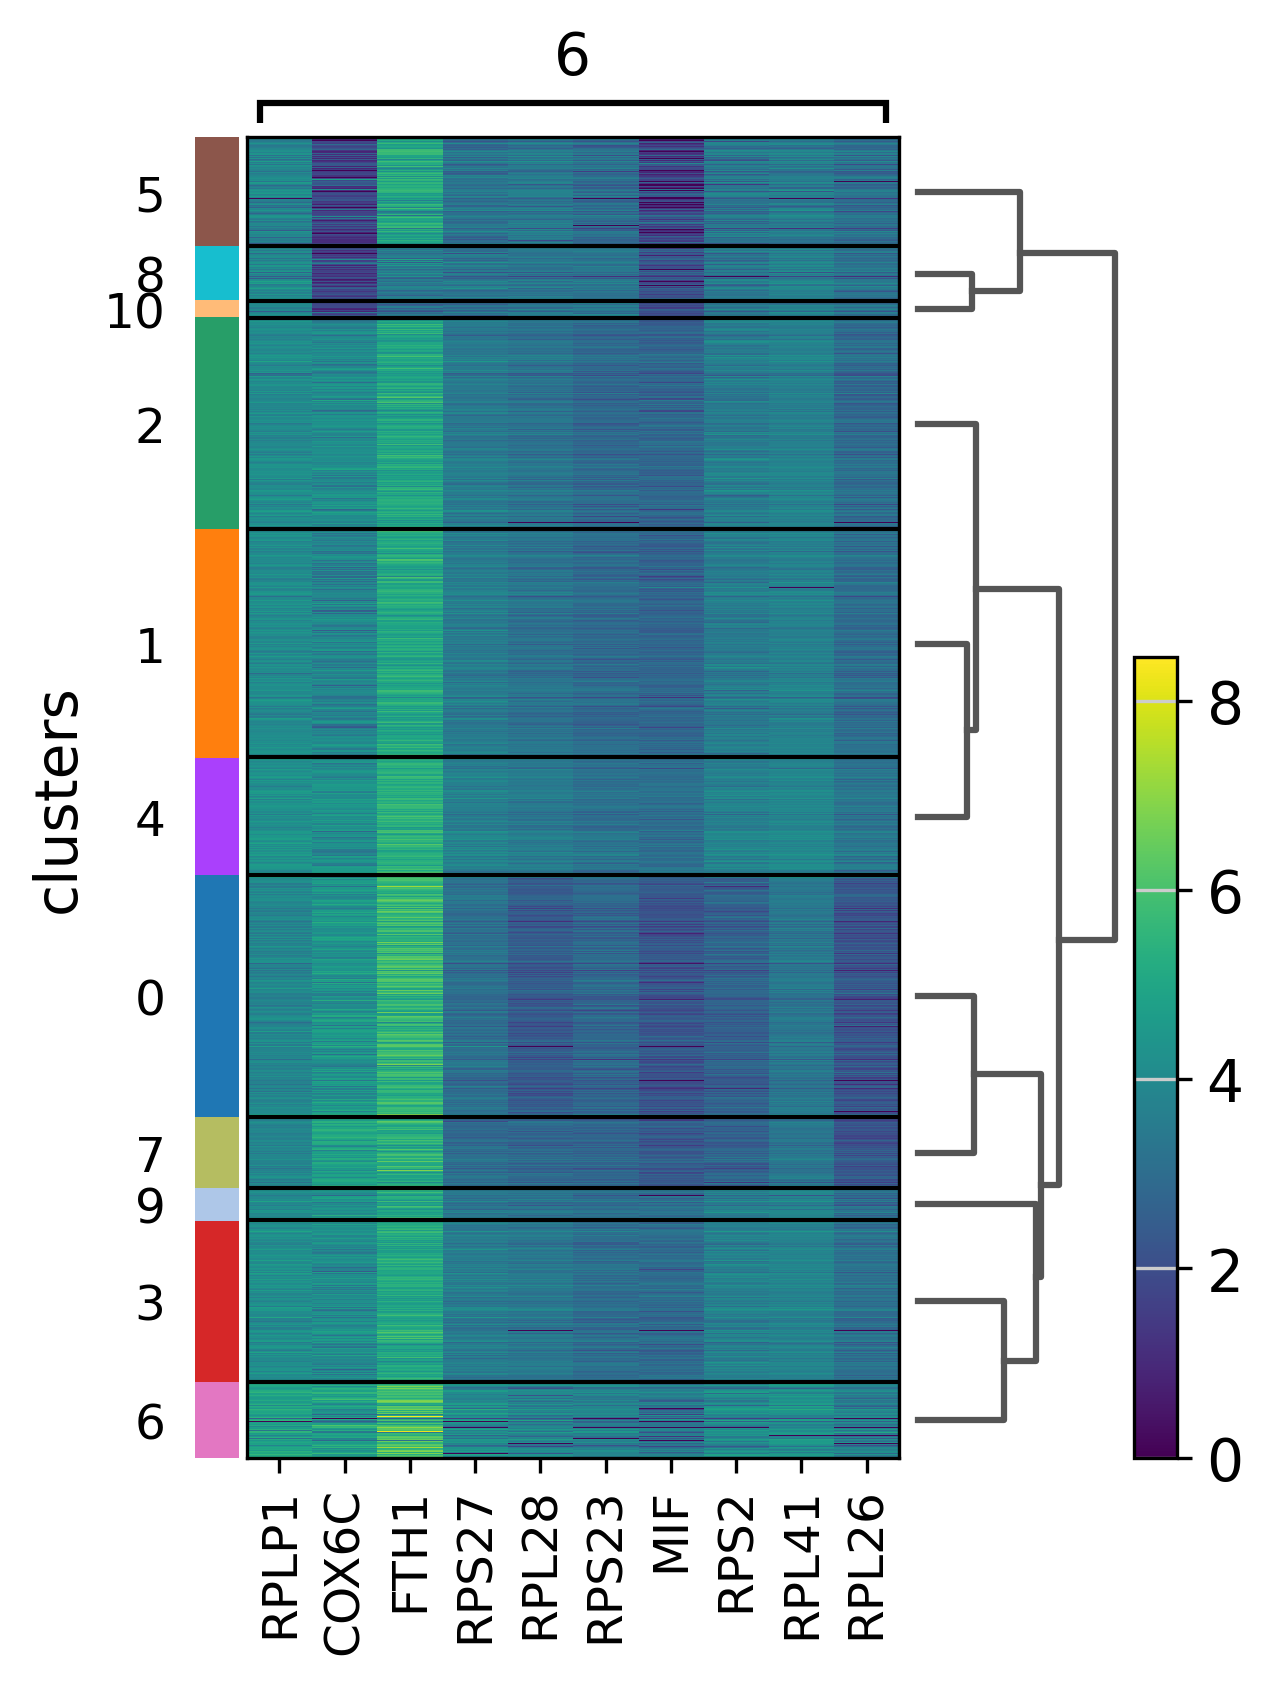

In [63]:
sc.pl.rank_genes_groups_heatmap(adata, groups="6", n_genes=10, groupby="clusters")

# Print the top n genes per cluster. 

In [64]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names

In [65]:
top_features = {}
n_top_genes = 10  
for group in groups:
    top_features[group] = result["names"][group][:n_top_genes]  

for group, features in top_features.items():
    print(f"Cluster {group} top features:")
    for feature in features:
        print(feature)
    print()

Cluster 0 top features:
NTS
RGS5
EPHX1
CRABP2
KCNJ3
WFDC2
MGST3
CLU
CARTPT
RAMP3

Cluster 1 top features:
ELF3
RAB11FIP1
CLDN4
CP
LDLR
BTG2
EGR3
JUND
UGDH
MIDN

Cluster 2 top features:
DNAJB1
IER2
FOS
HSPA1B
EGR1
PIP
NPY1R
HSPA1A
UBB
ZFAND2A

Cluster 3 top features:
IGFBP2
TMEM47
NPY1R
TRPA1
PIP
CHGB
XBP1
ITPRID2
PRSS23
SLITRK6

Cluster 4 top features:
IGFBP2
CPB1
EIF3H
RPL29
MIF
RPL7A
PIP
AZGP1
RPS4X
RPS15

Cluster 5 top features:
TYROBP
TMSB4X
VIM
SRGN
LAPTM5
TMSB10
FTL
FCER1G
HLA-DRA
SAT1

Cluster 6 top features:
RPLP1
COX6C
FTH1
RPS27
RPL28
RPS23
MIF
RPS2
RPL41
RPL26

Cluster 7 top features:
IGSF1
NTS
CLEC3A
CRABP2
COX6C
RAMP3
WFDC2
MRPS30-DT
SLC39A6
SPINT2

Cluster 8 top features:
VIM
TMSB4X
IFITM3
IGFBP7
GSTP1
CALD1
CAVIN1
SPARC
IFITM2
BGN

Cluster 9 top features:
H2AFZ
HINT1
TUBA1B
CKS1B
UBE2T
DEK
STMN1
RPA3
GGCT
MAD2L1

Cluster 10 top features:
VIM
TMSB4X
TMSB10
IGFBP7
EMP1
HLA-E
CD59
PALM2-AKAP2
IFITM3
TPT1



# save results in csv

In [66]:
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv("scanpy_result.csv")

# Identifying cell types for each cluster
### SCSA: cell type annotation for single-cell RNA-seq data
### para que funcione é necessario um ambiente python: conda create -n scsa_legacy python=3.8 pandas=1.3.5 numpy=1.21

In [68]:
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [69]:
df = pd.read_csv('SCSA/result.txt', sep='\t')
df.head()

Cell Type   Z-score  Cluster
0                   Natural killer cell  3.538797        0
1                  Intestinal stem cell  3.297663        0
2                          Sertoli cell  3.114592        0
3  Mitotic arrest phase fetal germ cell  2.849341        0
4           Natural killer T (NKT) cell  2.719696        0

In [71]:
highest_zscores = df.groupby('Cluster')['Z-score'].idxmax()

cell_types_with_highest_zscores = df.loc[highest_zscores, 'Cell Type'].tolist()

In [72]:
cell_types_with_highest_zscores

['Natural killer cell',
 'B cell',
 'Memory B cell',
 'Astrocyte',
 'Epithelial cell',
 'Macrophage',
 'Neural stem cell',
 'Mesenchymal stem cell',
 'Neural progenitor cell',
 'Endothelial cell']

# criar um dic para key=cell/ value=cluster

In [73]:
cluster_to_cell_type = {cluster_num: cell_type for cluster_num, cell_type in enumerate(cell_types_with_highest_zscores)}
cluster_to_cell_type

{0: 'Natural killer cell',
 1: 'B cell',
 2: 'Memory B cell',
 3: 'Astrocyte',
 4: 'Epithelial cell',
 5: 'Macrophage',
 6: 'Neural stem cell',
 7: 'Mesenchymal stem cell',
 8: 'Neural progenitor cell',
 9: 'Endothelial cell'}

In [74]:
adata.obs['clusters']

AAACCCAGTCGTCATA-1     4
AAACCCATCCTTCTTC-1     5
AAACCCATCGCCCAGA-1     6
AAACGAAAGCTCGCAC-1     7
AAACGAAAGGTAATCA-1    10
                      ..
TTTGGTTCATTGCCTC-1     2
TTTGGTTGTGATCGTT-1     4
TTTGGTTGTGGAGGTT-1     0
TTTGGTTTCTAGACCA-1     2
TTTGTTGTCGATGCAT-1     1
Name: clusters, Length: 2248, dtype: category
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']

In [75]:
# transformar para int
adata.obs['clusters'] = adata.obs['clusters'].astype(int)

In [76]:
adata.obs['cell_types'] = adata.obs['clusters'].map(cluster_to_cell_type)

In [77]:
adata.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAGTCGTCATA-1               6058       49372.0           2388.0   
AAACCCATCCTTCTTC-1               2081        7170.0            279.0   
AAACCCATCGCCCAGA-1                389         711.0              5.0   
AAACGAAAGCTCGCAC-1               4984       44434.0           1490.0   
AAACGAAAGGTAATCA-1               3459       10951.0            238.0   
...                               ...           ...              ...   
TTTGGTTCATTGCCTC-1               6448       55491.0           3677.0   
TTTGGTTGTGATCGTT-1               4934       28384.0           2409.0   
TTTGGTTGTGGAGGTT-1               4419       24987.0            777.0   
TTTGGTTTCTAGACCA-1               7122       64627.0           4276.0   
TTTGTTGTCGATGCAT-1               4656       29854.0           2214.0   

                    pct_counts_mt  total_counts_ribo  pct_counts_ribo leiden  \
AAACCCAGTCGTCATA-1       4.836750             8641.0        17.501823      0   
AAACCCATCCTTCTTC-1       3.891213              678.0         9.456067      4   
AAACCCATCGCCCAGA-1       0.703235              150.0        21.097046      5   
AAACGAAAGCTCGCAC-1       3.353288             3510.0         7.899357      6   
AAACGAAAGGTAATCA-1       2.173318             1402.0        12.802484      9   
...                           ...                ...              ...    ...   
TTTGGTTCATTGCCTC-1       6.626300             8166.0        14.715899      2   
TTTGGTTGTGATCGTT-1       8.487176             4372.0        15.403044      0   
TTTGGTTGTGGAGGTT-1       3.109617             2551.0        10.209309      1   
TTTGGTTTCTAGACCA-1       6.616430            10089.0        15.611122      2   
TTTGTTGTCGATGCAT-1       7.416092             4441.0        14.875728      0   

                    clusters             cell_types  
AAACCCAGTCGTCATA-1         4        Epithelial cell  
AAACCCATCCTTCTTC-1         5             Macrophage  
AAACCCATCGCCCAGA-1         6       Neural stem cell  
AAACGAAAGCTCGCAC-1         7  Mesenchymal stem cell  
AAACGAAAGGTAATCA-1        10                    NaN  
...                      ...                    ...  
TTTGGTTCATTGCCTC-1         2          Memory B cell  
TTTGGTTGTGATCGTT-1         4        Epithelial cell  
TTTGGTTGTGGAGGTT-1         0    Natural killer cell  
TTTGGTTTCTAGACCA-1         2          Memory B cell  
TTTGTTGTCGATGCAT-1         1                 B cell  

[2248 rows x 9 columns]

In [78]:
adata.obs["cell_types"].unique()

array(['Epithelial cell', 'Macrophage', 'Neural stem cell',
       'Mesenchymal stem cell', nan, 'Endothelial cell', 'B cell',
       'Memory B cell', 'Astrocyte', 'Natural killer cell',
       'Neural progenitor cell'], dtype=object)

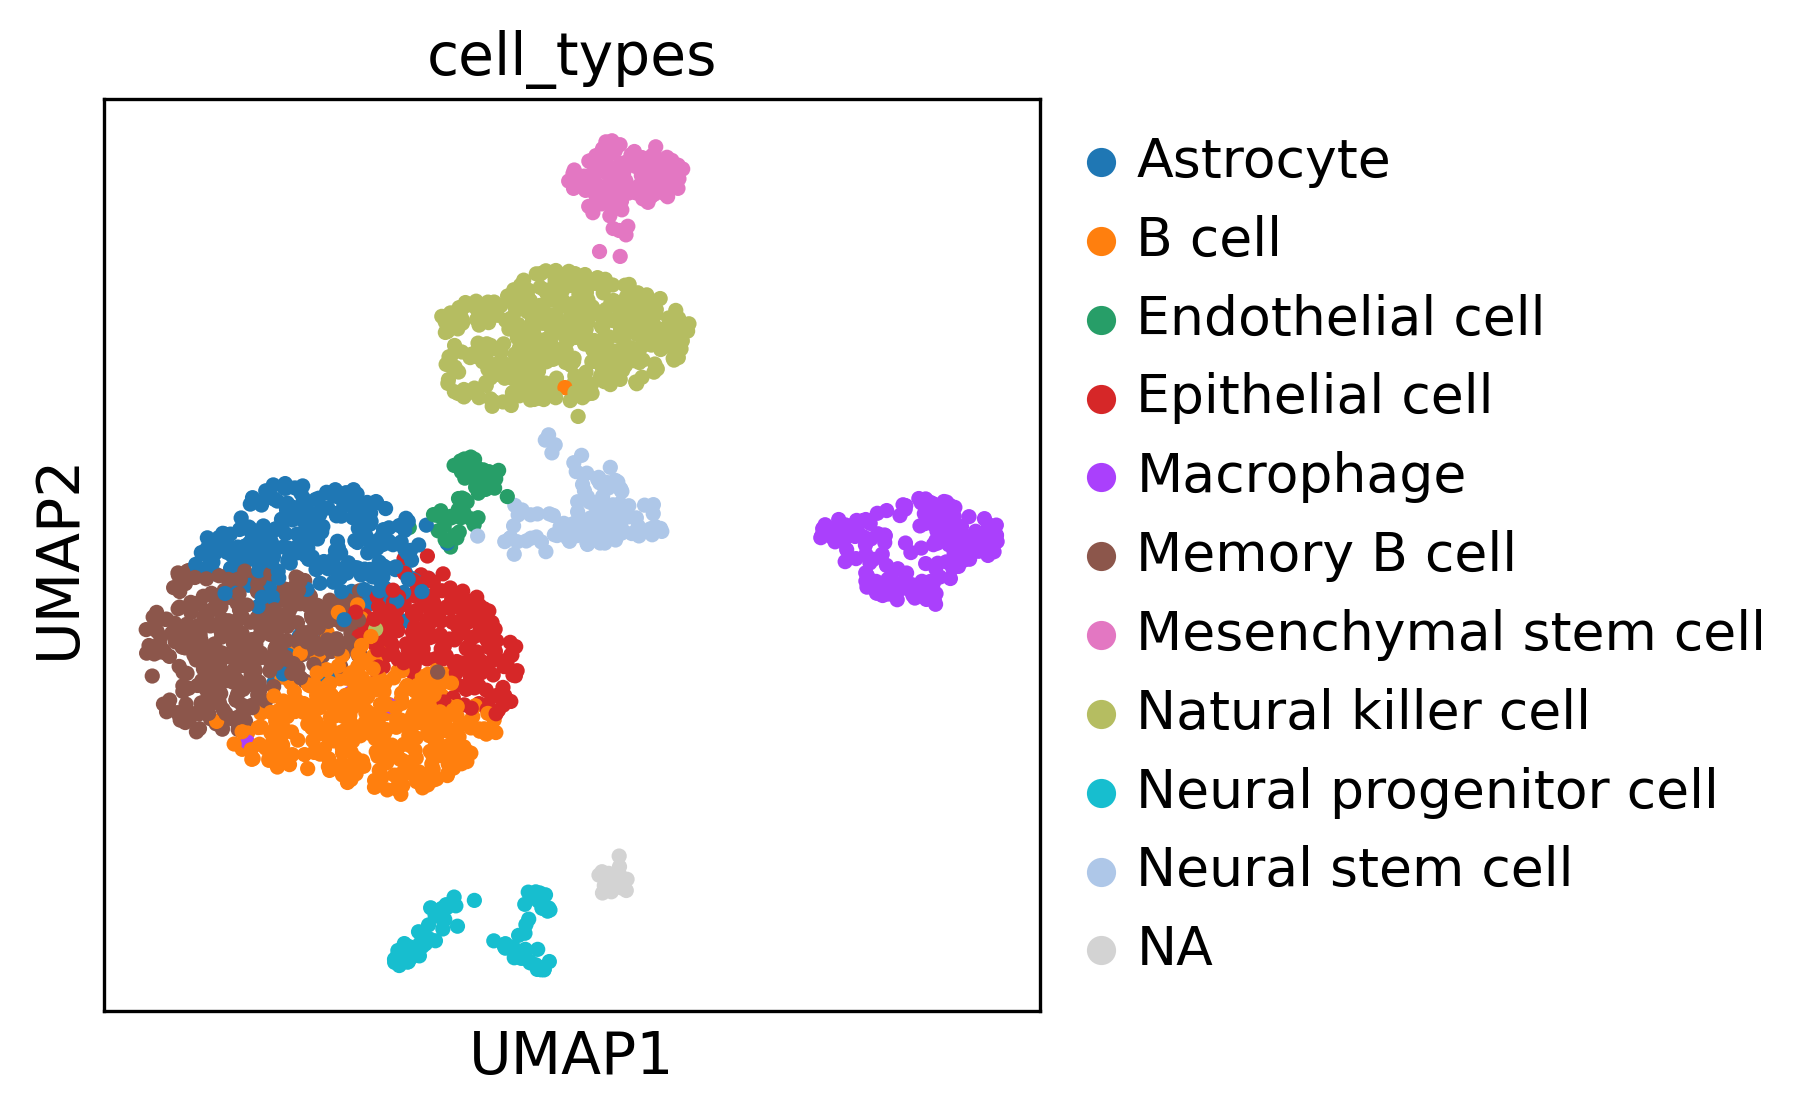

In [79]:
sc.pl.umap(adata, color="cell_types")

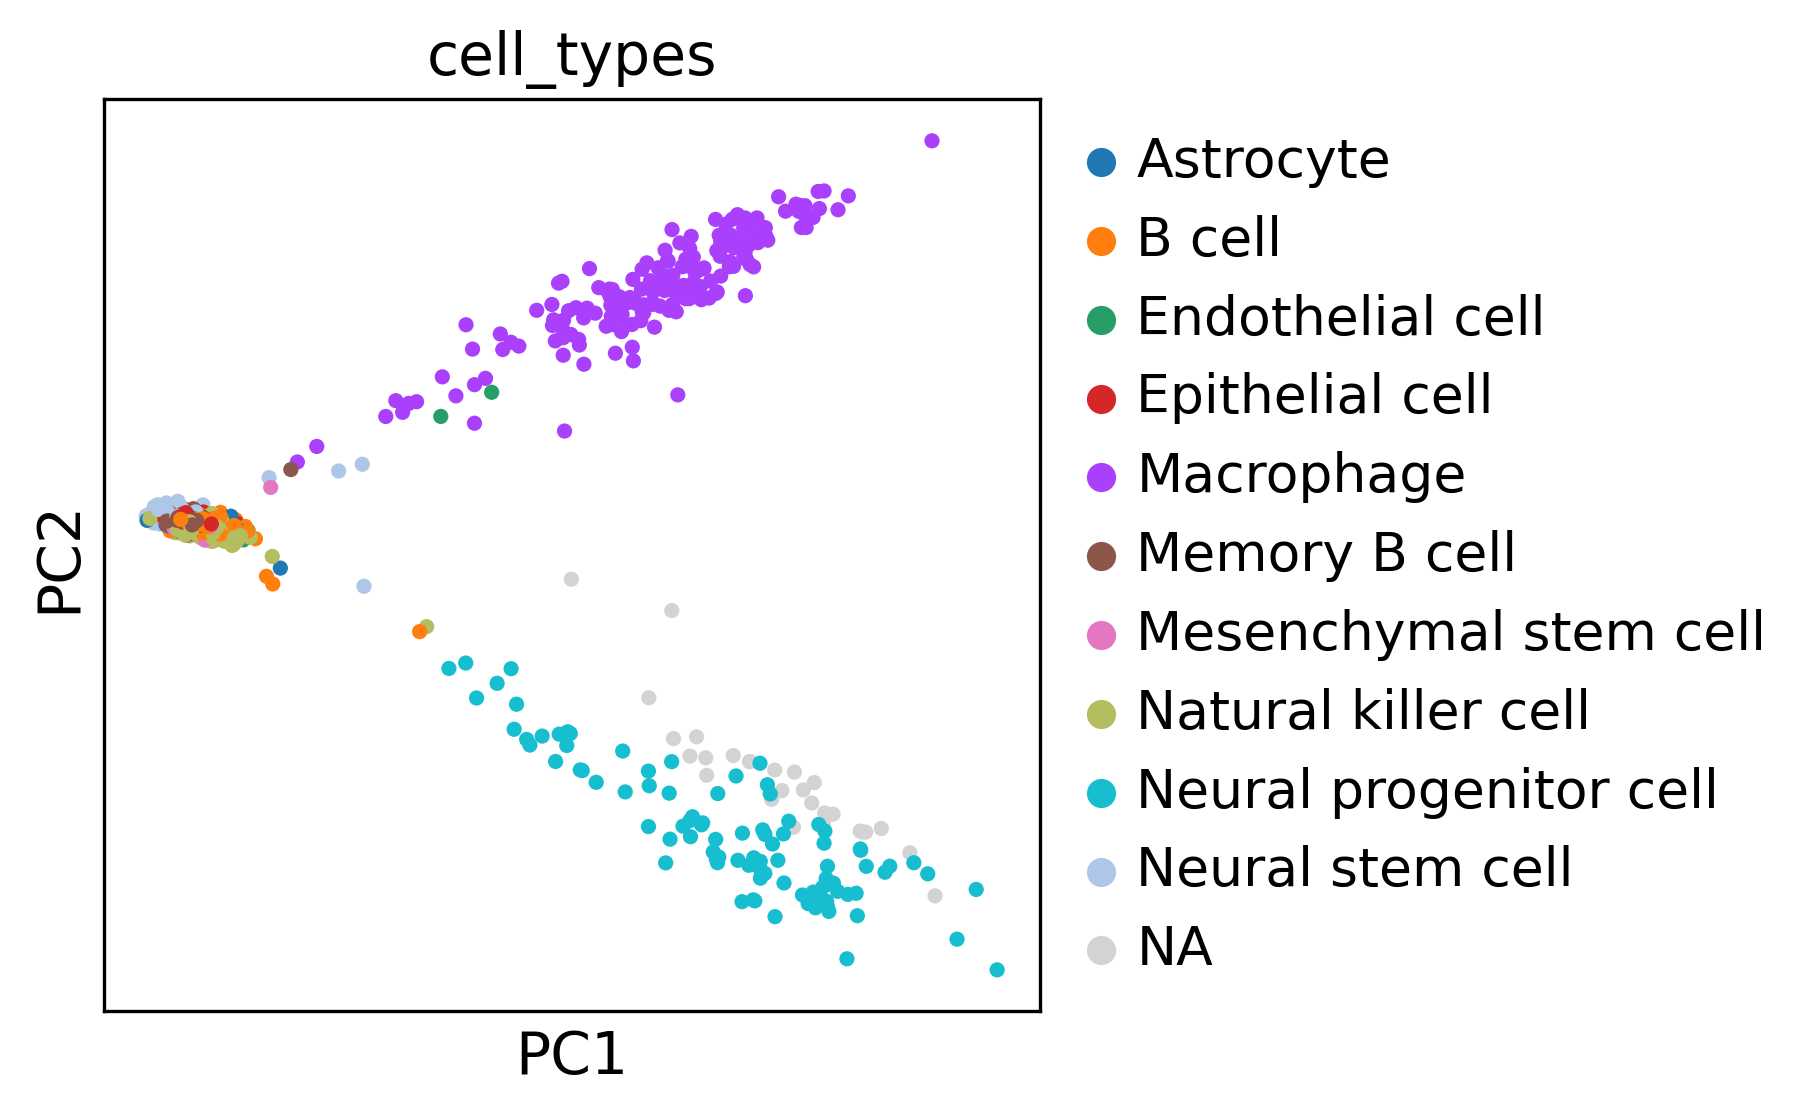

In [80]:
sc.pl.pca(adata, color="cell_types")

# verificar balanceamento de classes

nº de amostras por classe na coluna 'cell_types':

cell_types
Natural killer cell       412
B cell                    389
Memory B cell             360
Astrocyte                 275
Epithelial cell           200
Macrophage                185
Neural stem cell          129
Mesenchymal stem cell     121
Neural progenitor cell     93
Endothelial cell           55
Name: count, dtype: int64

 nº total de classes únicas: 10
Classe com o maior número de amostras: Natural killer cell (412 células)
Classe com o menor número de amostras: Endothelial cell (55 células)


/tmp/ipykernel_1166841/1396549273.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


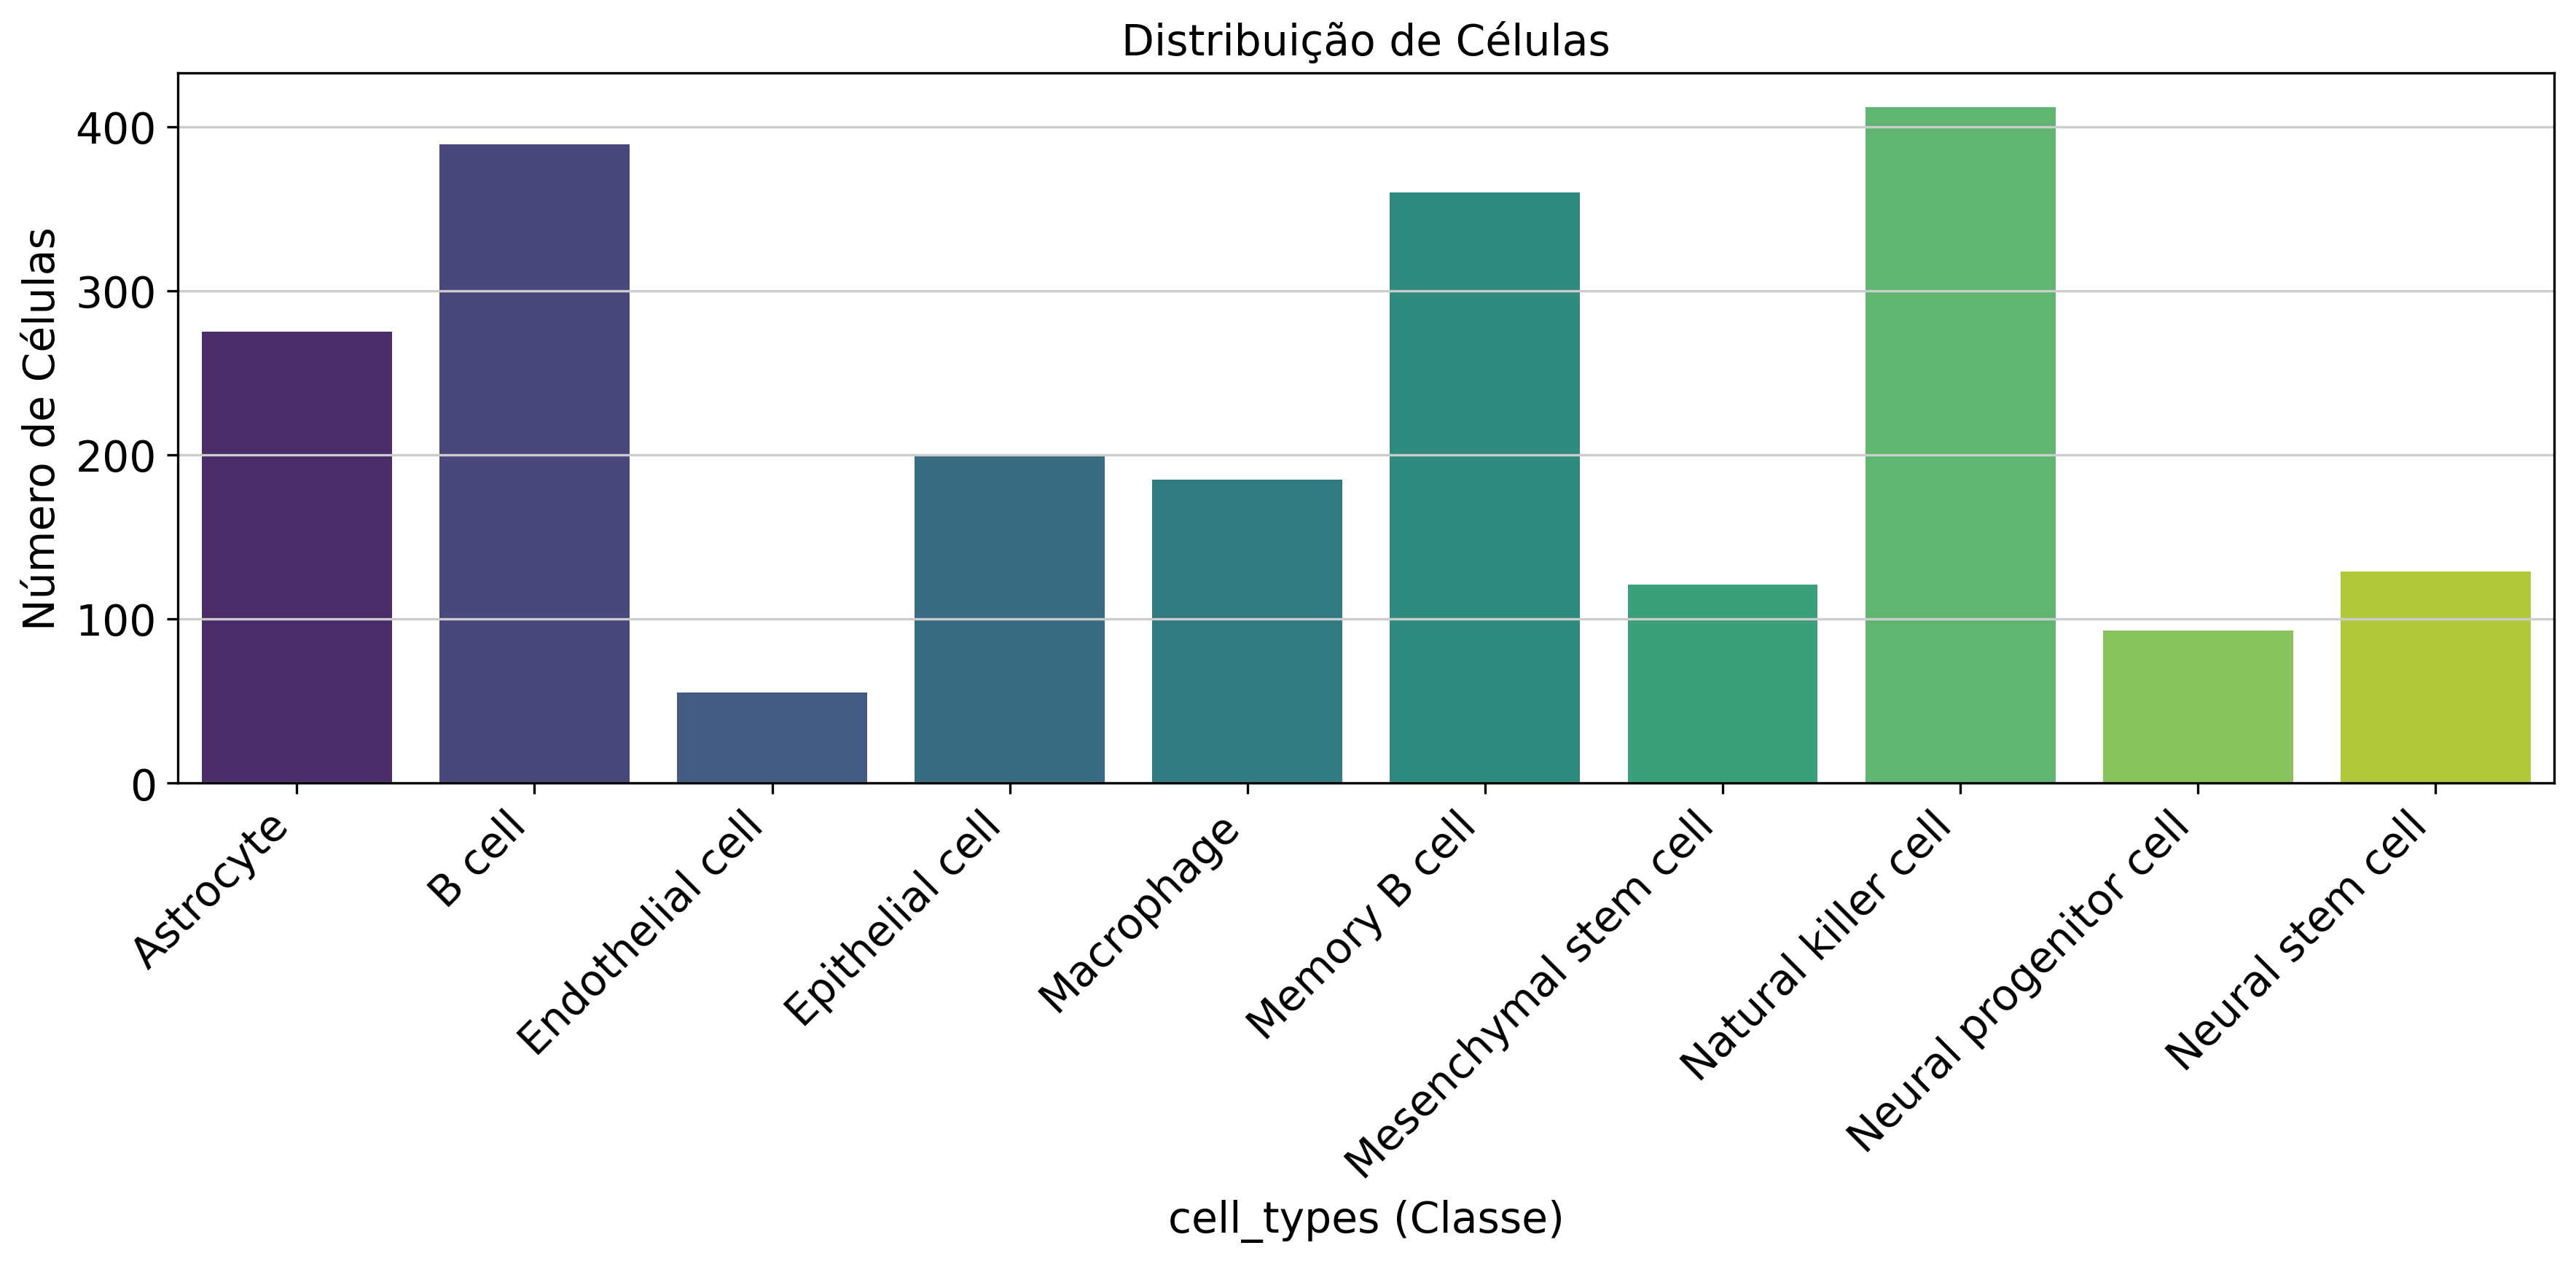

In [81]:
class_column = 'cell_types'
if class_column in adata.obs.columns:
    print(f"nº de amostras por classe na coluna '{class_column}':\n")
    class_counts = adata.obs[class_column].value_counts()
    print(class_counts)

    print(f"\n nº total de classes únicas: {len(class_counts)}")
    print(f"Classe com o maior número de amostras: {class_counts.index[0]} ({class_counts.iloc[0]} células)")
    print(f"Classe com o menor número de amostras: {class_counts.index[-1]} ({class_counts.iloc[-1]} células)")

    plt.figure(figsize=(12, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.xlabel(f'{class_column} (Classe)')
    plt.ylabel('Número de Células')
    plt.title('Distribuição de Células')
    plt.xticks(rotation=45, ha='right') #rotaciona os rótulos para melhor leitura
    plt.tight_layout() #austa o layout para que os rótulos não se sobreponham
    plt.show()

In [82]:
print(f"{adata.n_obs} células x {adata.n_vars} genes")

2248 células x 4010 genes


In [83]:
output_file = 'breast_cancer_annotated.h5ad'
adata.write(output_file)

# Abordagem ML

In [85]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import shap

In [88]:
#criar tensor

In [87]:
X = torch.tensor(adata.X, dtype=torch.float32)

# Label encoder multiclass

In [123]:
adata_filtered_for_ml = adata[~adata.obs['cell_types'].isna()].copy()
X = torch.tensor(adata_filtered_for_ml.X, dtype=torch.float32)
le = LabelEncoder()
# Fit_transform nos cell_types JÁ FILTRADOS
y_encoded = le.fit_transform(adata_filtered_for_ml.obs['cell_types'])
y = torch.tensor(y_encoded, dtype=torch.long)

In [126]:
num_classes = len(le.classes_)
input_dim = X.shape[1]

print(f"Dimensão das features (X - HVGs): {X.shape}")
print(f"Dimensão dos labels (y): {y.shape}")
print(f"Número de classes únicas: {num_classes}")
print(f"Tipos de células (rótulos originais): {le.classes_}")

Dimensão das features (X - HVGs): torch.Size([2219, 4010])
Dimensão dos labels (y): torch.Size([2219])
Número de classes únicas: 10
Tipos de células (rótulos originais): ['Astrocyte' 'B cell' 'Endothelial cell' 'Epithelial cell' 'Macrophage'
 'Memory B cell' 'Mesenchymal stem cell' 'Natural killer cell'
 'Neural progenitor cell' 'Neural stem cell']


# MLP (PyTorch Lightning)

In [141]:
class MLPClassifier(pl.LightningModule):
    def __init__(self, input_dim, num_classes, hidden_dim, dropout_rate, learning_rate):
        super().__init__()
        self.save_hyperparameters()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        f1 = f1_score(y.cpu(), preds.cpu(), average='weighted', zero_division=0) # zero_division para evitar warnings
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'val_loss': loss, 'val_acc': acc, 'val_f1': f1}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())
        f1 = f1_score(y.cpu(), preds.cpu(), average='weighted', zero_division=0)

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_f1', f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'test_loss': loss, 'test_acc': acc, 'test_f1': f1}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Hyperopt e Stratified K-Fold

In [156]:
space = {
    'hidden_dim': hp.choice('hidden_dim', [64, 128, 256, 512]),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'epochs': hp.choice('epochs', [50, 100, 150])
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

def objective(params):
    print(f"\n--- Testando hiperparâmetros: {params} ---")
    
    fold_accuracies = []
    fold_f1_scores = []
    
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Iniciando Fold {fold + 1}/{n_splits}")
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=os.cpu_count(), persistent_workers=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=os.cpu_count(), persistent_workers=True)

        model = MLPClassifier(input_dim=input_dim, num_classes=num_classes,
                              hidden_dim=params['hidden_dim'],
                              dropout_rate=params['dropout_rate'],
                              learning_rate=params['learning_rate'])

        early_stop_callback = EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,
            patience=10,
            verbose=False,
            mode='min'
        )

        trainer = pl.Trainer(
            max_epochs=params['epochs'],
            callbacks=[early_stop_callback],
            enable_progress_bar=False,
            logger=pl.loggers.TensorBoardLogger("lightning_logs_hyperopt/", name="mlp_tuning")
        )

        trainer.fit(model, train_loader, val_loader)

        val_results = trainer.validate(model, val_loader)
        avg_val_acc = val_results[0]['val_acc']
        avg_val_f1 = val_results[0]['val_f1']
        
        fold_accuracies.append(avg_val_acc)
        fold_f1_scores.append(avg_val_f1)
        
    avg_acc_over_folds = np.mean(fold_accuracies)
    avg_f1_over_folds = np.mean(fold_f1_scores)

    print(f"Média de Acurácia nos Folds: {avg_acc_over_folds:.4f}")
    print(f"Média de F1-Score nos Folds: {avg_f1_over_folds:.4f}")

    return {'loss': 1 - avg_acc_over_folds, 'status': STATUS_OK, 'avg_acc': avg_acc_over_folds, 'avg_f1': avg_f1_over_folds}

trials = Trials()
best_params_raw = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50, # Aumentar para um número maior para tunagem real (e.g., 50, 100)
    trials=trials
)

print("\n--- Melhor Conjunto de Hiperparâmetros encontrado ---")

final_best_params = space_eval(space, best_params_raw)

print(final_best_params)

                                                      
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.33551328684952175, 'epochs': 50, 'hidden_dim': 64, 'learning_rate': 0.005729492060669428} ---
Iniciando Fold 1/5                                    
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8941441178321838     │
│          val_f1           │    0.8918554782867432     │
│         val_loss          │    0.5098651647567749     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                    
  0%|          | 0/50 [00:14<?, ?trial/s, best loss=?]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9182286858558655     │
│         val_loss          │    0.2812832295894623     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                    
  0%|          | 0/50 [00:28<?, ?trial/s, best loss=?]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8963963985443115     │
│          val_f1           │    0.8947797417640686     │
│         val_loss          │    0.3362322151660919     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                    
  0%|          | 0/50 [00:43<?, ?trial/s, best loss=?]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9128063321113586     │
│         val_loss          │    0.26740020513534546    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                    
  0%|          | 0/50 [00:57<?, ?trial/s, best loss=?]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.918735921382904     │
│          val_f1           │    0.9184987545013428     │
│         val_loss          │    0.2856560945510864     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9081                   
Média de F1-Score nos Folds: 0.9072                   
                                                                                 
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.33398083715253557, 'epochs': 50, 'hidden_dim': 512, 'learning_rate': 0.0015216377989307206} ---
Iniciando Fold 1/5                                                               
  2%|▏         | 1/50 [01:11<58:45, 71.94s/trial, best loss: 0.09192849397659297]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9034070372581482     │
│         val_loss          │    0.34052208065986633    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                               
  2%|▏         | 1/50 [01:32<58:45, 71.94s/trial, best loss: 0.09192849397659297]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9033127427101135     │
│         val_loss          │    0.22080282866954803    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                               
  2%|▏         | 1/50 [01:52<58:45, 71.94s/trial, best loss: 0.09192849397659297]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9086039066314697     │
│         val_loss          │    0.2357417196035385     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                               
  2%|▏         | 1/50 [02:10<58:45, 71.94s/trial, best loss: 0.09192849397659297]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.934684693813324     │
│          val_f1           │    0.9347699284553528     │
│         val_loss          │    0.15727178752422333    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                               
  2%|▏         | 1/50 [02:29<58:45, 71.94s/trial, best loss: 0.09192849397659297]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9277652502059937     │
│          val_f1           │    0.9264751672744751     │
│         val_loss          │    0.22575703263282776    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9162                                              
Média de F1-Score nos Folds: 0.9153                                              
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.27258475238333824, 'epochs': 100, 'hidden_dim': 256, 'learning_rate': 0.007926238928746353} ---
Iniciando Fold 1/5                                                                 
  4%|▍         | 2/50 [02:45<1:07:56, 84.92s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8671171069145203     │
│          val_f1           │    0.8605912923812866     │
│         val_loss          │     8.547856330871582     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
  4%|▍         | 2/50 [03:01<1:07:56, 84.92s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8648648858070374     │
│          val_f1           │    0.8673185706138611     │
│         val_loss          │     1.276336431503296     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
  4%|▍         | 2/50 [03:15<1:07:56, 84.92s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8558558821678162     │
│          val_f1           │    0.8503813743591309     │
│         val_loss          │     2.439537763595581     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
  4%|▍         | 2/50 [03:29<1:07:56, 84.92s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.880630612373352     │
│          val_f1           │    0.8782999515533447     │
│         val_loss          │    1.3715647459030151     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
  4%|▍         | 2/50 [03:44<1:07:56, 84.92s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8803611993789673     │
│          val_f1           │    0.8765870928764343     │
│         val_loss          │    1.0839107036590576     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.8698                                                
Média de F1-Score nos Folds: 0.8666                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.13162485491775178, 'epochs': 100, 'hidden_dim': 256, 'learning_rate': 0.009376273700175027} ---
Iniciando Fold 1/5                                                                 
  6%|▌         | 3/50 [03:59<1:02:19, 79.57s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8603603839874268     │
│          val_f1           │    0.8555536866188049     │
│         val_loss          │    5.5152387619018555     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
  6%|▌         | 3/50 [04:15<1:02:19, 79.57s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8783783912658691     │
│          val_f1           │    0.8778656125068665     │
│         val_loss          │     1.944733738899231     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
  6%|▌         | 3/50 [04:30<1:02:19, 79.57s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9112248420715332     │
│         val_loss          │    0.6972288489341736     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
  6%|▌         | 3/50 [04:45<1:02:19, 79.57s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8851351141929626     │
│          val_f1           │    0.8838716149330139     │
│         val_loss          │    1.6293147802352905     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
  6%|▌         | 3/50 [05:00<1:02:19, 79.57s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8690744638442993     │
│          val_f1           │    0.8651610016822815     │
│         val_loss          │    1.4596976041793823     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.8810                                                
Média de F1-Score nos Folds: 0.8787                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.3696865505077721, 'epochs': 50, 'hidden_dim': 64, 'learning_rate': 0.002946383183057236} ---
Iniciando Fold 1/5                                                                 
  8%|▊         | 4/50 [05:15<1:00:05, 78.37s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8828828930854797     │
│          val_f1           │    0.8819352984428406     │
│         val_loss          │    0.3957568407058716     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
  8%|▊         | 4/50 [05:29<1:00:05, 78.37s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9118679165840149     │
│         val_loss          │    0.20743419229984283    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
  8%|▊         | 4/50 [05:43<1:00:05, 78.37s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8963963985443115     │
│          val_f1           │     0.891644299030304     │
│         val_loss          │    0.29859909415245056    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
  8%|▊         | 4/50 [05:56<1:00:05, 78.37s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9191601872444153     │
│         val_loss          │    0.21784383058547974    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
  8%|▊         | 4/50 [06:10<1:00:05, 78.37s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8893905282020569     │
│          val_f1           │    0.8855471611022949     │
│         val_loss          │    0.2979664206504822     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9000                                                
Média de F1-Score nos Folds: 0.8980                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.14098788346525906, 'epochs': 50, 'hidden_dim': 512, 'learning_rate': 0.00023357741165803787} ---
Iniciando Fold 1/5                                                               
 10%|█         | 5/50 [06:24<56:17, 75.05s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9075651168823242     │
│         val_loss          │    0.25824856758117676    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                               
 10%|█         | 5/50 [06:44<56:17, 75.05s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9082216024398804     │
│         val_loss          │    0.2096540927886963     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                               
 10%|█         | 5/50 [07:06<56:17, 75.05s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9135972857475281     │
│         val_loss          │    0.22248438000679016    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                               
 10%|█         | 5/50 [07:28<56:17, 75.05s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9324324131011963     │
│          val_f1           │    0.9321104288101196     │
│         val_loss          │    0.1583595722913742     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                               
 10%|█         | 5/50 [07:53<56:17, 75.05s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9119638800621033     │
│          val_f1           │    0.9110623002052307     │
│         val_loss          │    0.23431673645973206    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9162                                              
Média de F1-Score nos Folds: 0.9145                                              
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.18624554518638312, 'epochs': 50, 'hidden_dim': 64, 'learning_rate': 0.0006201746237494293} ---
Iniciando Fold 1/5                                                                 
 12%|█▏        | 6/50 [08:13<1:03:31, 86.61s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9036752581596375     │
│         val_loss          │    0.2669750154018402     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 12%|█▏        | 6/50 [08:31<1:03:31, 86.61s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8963963985443115     │
│          val_f1           │    0.8961227536201477     │
│         val_loss          │    0.19785165786743164    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 12%|█▏        | 6/50 [08:48<1:03:31, 86.61s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │     0.89932781457901      │
│         val_loss          │    0.23643387854099274    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 12%|█▏        | 6/50 [09:03<1:03:31, 86.61s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9234234094619751     │
│          val_f1           │    0.9236329197883606     │
│         val_loss          │    0.16996406018733978    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 12%|█▏        | 6/50 [09:22<1:03:31, 86.61s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9097065329551697     │
│          val_f1           │     0.907593309879303     │
│         val_loss          │     0.223366379737854     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9085                                                
Média de F1-Score nos Folds: 0.9061                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.308538714865056, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0002522075393801047} ---
Iniciando Fold 1/5                                                                 
 14%|█▍        | 7/50 [09:37<1:01:26, 85.73s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9144144058227539     │
│          val_f1           │    0.9120000600814819     │
│         val_loss          │    0.25827544927597046    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 14%|█▍        | 7/50 [10:00<1:01:26, 85.73s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9103984236717224     │
│         val_loss          │    0.20180892944335938    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 14%|█▍        | 7/50 [10:24<1:01:26, 85.73s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9082586169242859     │
│         val_loss          │    0.21038447320461273    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 14%|█▍        | 7/50 [10:45<1:01:26, 85.73s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9391891956329346     │
│          val_f1           │    0.9389086365699768     │
│         val_loss          │    0.15150099992752075    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 14%|█▍        | 7/50 [11:10<1:01:26, 85.73s/trial, best loss: 0.08381631374359133]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9209932088851929     │
│          val_f1           │    0.9180849194526672     │
│         val_loss          │    0.2159111648797989     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9193                                                
Média de F1-Score nos Folds: 0.9175                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.214478768849522, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.00816635357657673} ---
Iniciando Fold 1/5                                                                 
 16%|█▌        | 8/50 [11:36<1:07:17, 96.14s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8603603839874268     │
│          val_f1           │    0.8586187362670898     │
│         val_loss          │     7.919883728027344     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 16%|█▌        | 8/50 [11:52<1:07:17, 96.14s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8445945978164673     │
│          val_f1           │    0.8426346778869629     │
│         val_loss          │    2.8717496395111084     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 16%|█▌        | 8/50 [12:07<1:07:17, 96.14s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8963963985443115     │
│          val_f1           │    0.8969628810882568     │
│         val_loss          │    1.7026598453521729     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 16%|█▌        | 8/50 [12:22<1:07:17, 96.14s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.880630612373352     │
│          val_f1           │    0.8782964944839478     │
│         val_loss          │     3.503594160079956     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 16%|█▌        | 8/50 [12:38<1:07:17, 96.14s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8600451350212097     │
│          val_f1           │    0.8593655228614807     │
│         val_loss          │    2.4449946880340576     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.8684                                                
Média de F1-Score nos Folds: 0.8672                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.3363294195818546, 'epochs': 150, 'hidden_dim': 64, 'learning_rate': 0.009014560611823867} ---
Iniciando Fold 1/5                                                                 
 18%|█▊        | 9/50 [12:54<1:01:52, 90.55s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8761261105537415     │
│          val_f1           │     0.873792827129364     │
│         val_loss          │    0.9357094168663025     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 18%|█▊        | 9/50 [13:06<1:01:52, 90.55s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9085397124290466     │
│         val_loss          │     0.37957963347435      │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 18%|█▊        | 9/50 [13:18<1:01:52, 90.55s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9009009003639221     │
│          val_f1           │    0.9002895355224609     │
│         val_loss          │    0.40601328015327454    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 18%|█▊        | 9/50 [13:30<1:01:52, 90.55s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │     0.908539354801178     │
│         val_loss          │    0.31114310026168823    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 18%|█▊        | 9/50 [13:42<1:01:52, 90.55s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8961625099182129     │
│          val_f1           │    0.8917751908302307     │
│         val_loss          │    0.5463393926620483     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.8986                                                
Média de F1-Score nos Folds: 0.8966                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.3947866685414697, 'epochs': 150, 'hidden_dim': 128, 'learning_rate': 0.002527818576178291} ---
Iniciando Fold 1/5                                                                
 20%|██        | 10/50 [13:54<54:06, 81.16s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8896396160125732     │
│          val_f1           │    0.8893172740936279     │
│         val_loss          │    0.46139299869537354    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 20%|██        | 10/50 [14:09<54:06, 81.16s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9064942598342896     │
│         val_loss          │    0.2613539397716522     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 20%|██        | 10/50 [14:26<54:06, 81.16s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.8999523520469666     │
│         val_loss          │    0.3459062874317169     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 20%|██        | 10/50 [14:41<54:06, 81.16s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.8994683027267456     │
│         val_loss          │    0.31528475880622864    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 20%|██        | 10/50 [14:58<54:06, 81.16s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8781038522720337     │
│          val_f1           │    0.8716602921485901     │
│         val_loss          │    0.36347898840904236    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.8972                                               
Média de F1-Score nos Folds: 0.8934                                               
                                                                                  
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.40934718016476335, 'epochs': 100, 'hidden_dim': 64, 'learning_rate': 0.0035576985025258813} ---
Iniciando Fold 1/5                                                                
 22%|██▏       | 11/50 [15:13<52:20, 80.54s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8896396160125732     │
│          val_f1           │    0.8888449668884277     │
│         val_loss          │    0.34289759397506714    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 22%|██▏       | 11/50 [15:26<52:20, 80.54s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9156030416488647     │
│         val_loss          │    0.22530777752399445    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 22%|██▏       | 11/50 [15:38<52:20, 80.54s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8963963985443115     │
│          val_f1           │    0.8936997056007385     │
│         val_loss          │    0.2806828022003174     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 22%|██▏       | 11/50 [15:50<52:20, 80.54s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9263840317726135     │
│         val_loss          │    0.21547436714172363    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 22%|██▏       | 11/50 [16:04<52:20, 80.54s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.9064039587974548     │
│         val_loss          │    0.2465764731168747     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9072                                               
Média de F1-Score nos Folds: 0.9062                                               
                                                                                  
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.10262029340330314, 'epochs': 100, 'hidden_dim': 64, 'learning_rate': 0.00021711203895647988} ---
Iniciando Fold 1/5                                                                
 24%|██▍       | 12/50 [16:16<47:37, 75.19s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.8998988270759583     │
│         val_loss          │    0.2811921238899231     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 24%|██▍       | 12/50 [16:35<47:37, 75.19s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9116447567939758     │
│         val_loss          │    0.2081361562013626     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 24%|██▍       | 12/50 [16:54<47:37, 75.19s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9017754793167114     │
│         val_loss          │    0.21625642478466034    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 24%|██▍       | 12/50 [17:13<47:37, 75.19s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9183498024940491     │
│         val_loss          │    0.17873667180538177    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 24%|██▍       | 12/50 [17:36<47:37, 75.19s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9006772041320801     │
│          val_f1           │    0.8984788060188293     │
│         val_loss          │    0.22674725949764252    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9076                                               
Média de F1-Score nos Folds: 0.9060                                               
                                                                                  
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.23271474259922842, 'epochs': 50, 'hidden_dim': 512, 'learning_rate': 0.00010778959197045962} ---
Iniciando Fold 1/5                                                                
 26%|██▌       | 13/50 [17:55<50:50, 82.43s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9004212617874146     │
│         val_loss          │    0.2590744197368622     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 26%|██▌       | 13/50 [18:20<50:50, 82.43s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9038757681846619     │
│         val_loss          │    0.2111034244298935     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 26%|██▌       | 13/50 [18:49<50:50, 82.43s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9082213640213013     │
│         val_loss          │    0.20992915332317352    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 26%|██▌       | 13/50 [19:16<50:50, 82.43s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9234234094619751     │
│          val_f1           │    0.9229291677474976     │
│         val_loss          │    0.16226764023303986    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 26%|██▌       | 13/50 [19:54<50:50, 82.43s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.9033867120742798     │
│         val_loss          │    0.21435372531414032    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9099                                               
Média de F1-Score nos Folds: 0.9078                                               
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.27776845581580023, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0008856508097429256} ---
Iniciando Fold 1/5                                                                   
 28%|██▊       | 14/50 [20:22<1:01:03, 101.78s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9082247018814087     │
│         val_loss          │     0.286160945892334     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 28%|██▊       | 14/50 [20:41<1:01:03, 101.78s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9279279112815857     │
│          val_f1           │     0.926843523979187     │
│         val_loss          │    0.18929147720336914    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 28%|██▊       | 14/50 [20:59<1:01:03, 101.78s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9147513508796692     │
│         val_loss          │    0.21950429677963257    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 28%|██▊       | 14/50 [21:17<1:01:03, 101.78s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9369369149208069     │
│          val_f1           │    0.9372575283050537     │
│         val_loss          │    0.1456865519285202     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 28%|██▊       | 14/50 [21:36<1:01:03, 101.78s/trial, best loss: 0.08066622018814085]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9164785742759705     │
│          val_f1           │    0.9149550795555115     │
│         val_loss          │    0.21761226654052734    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9216                                                  
Média de F1-Score nos Folds: 0.9204                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.31102033566746856, 'epochs': 150, 'hidden_dim': 64, 'learning_rate': 0.0001326973600132025} ---
Iniciando Fold 1/5                                                                
 30%|███       | 15/50 [21:55<57:49, 99.12s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8986486196517944     │
│          val_f1           │    0.8946972489356995     │
│         val_loss          │    0.2617100775241852     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 30%|███       | 15/50 [22:17<57:49, 99.12s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │     0.904093861579895     │
│         val_loss          │    0.19674524664878845    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 30%|███       | 15/50 [22:45<57:49, 99.12s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9028041958808899     │
│         val_loss          │    0.2117064893245697     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 30%|███       | 15/50 [23:10<57:49, 99.12s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9167839288711548     │
│         val_loss          │    0.1788889467716217     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 30%|███       | 15/50 [23:36<57:49, 99.12s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9119638800621033     │
│          val_f1           │    0.9091591835021973     │
│         val_loss          │    0.23418709635734558    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9076                                               
Média de F1-Score nos Folds: 0.9055                                               
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.22382864157010798, 'epochs': 50, 'hidden_dim': 64, 'learning_rate': 0.002508357969500528} ---
Iniciando Fold 1/5                                                                   
 32%|███▏      | 16/50 [24:01<1:00:44, 107.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8941441178321838     │
│          val_f1           │    0.8943098783493042     │
│         val_loss          │    0.4226651191711426     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 32%|███▏      | 16/50 [24:18<1:00:44, 107.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9113907814025879     │
│         val_loss          │    0.2744879126548767     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 32%|███▏      | 16/50 [24:36<1:00:44, 107.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9018046855926514     │
│         val_loss          │    0.3514558672904968     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 32%|███▏      | 16/50 [24:54<1:00:44, 107.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9009669423103333     │
│         val_loss          │    0.22600585222244263    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 32%|███▏      | 16/50 [25:17<1:00:44, 107.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9029345512390137     │
│          val_f1           │    0.8977978825569153     │
│         val_loss          │    0.2932814359664917     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9031                                                  
Média de F1-Score nos Folds: 0.9013                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.39139361268259565, 'epochs': 100, 'hidden_dim': 64, 'learning_rate': 0.0011840962627404524} ---
Iniciando Fold 1/5                                                                 
 34%|███▍      | 17/50 [25:35<56:48, 103.28s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9009009003639221     │
│          val_f1           │    0.9005768895149231     │
│         val_loss          │    0.2899901568889618     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 34%|███▍      | 17/50 [25:51<56:48, 103.28s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9279279112815857     │
│          val_f1           │    0.9277059435844421     │
│         val_loss          │    0.19217537343502045    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 34%|███▍      | 17/50 [26:08<56:48, 103.28s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9066480398178101     │
│         val_loss          │    0.23563505709171295    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 34%|███▍      | 17/50 [26:24<56:48, 103.28s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9181665778160095     │
│         val_loss          │    0.18799839913845062    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 34%|███▍      | 17/50 [26:41<56:48, 103.28s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9142212271690369     │
│          val_f1           │    0.9130743145942688     │
│         val_loss          │    0.21980491280555725    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9144                                                
Média de F1-Score nos Folds: 0.9132                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.24321991690000277, 'epochs': 100, 'hidden_dim': 256, 'learning_rate': 0.00043143626187516657} ---
Iniciando Fold 1/5                                                                
 36%|███▌      | 18/50 [26:56<51:34, 96.71s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9083899259567261     │
│         val_loss          │    0.26718586683273315    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 36%|███▌      | 18/50 [27:13<51:34, 96.71s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9144144058227539     │
│          val_f1           │    0.9132788181304932     │
│         val_loss          │    0.19514523446559906    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 36%|███▌      | 18/50 [27:30<51:34, 96.71s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9078769683837891     │
│         val_loss          │    0.21008047461509705    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 36%|███▌      | 18/50 [27:46<51:34, 96.71s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9254556894302368     │
│         val_loss          │    0.16448616981506348    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 36%|███▌      | 18/50 [28:04<51:34, 96.71s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │     0.905185878276825     │
│         val_loss          │    0.22216761112213135    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9135                                               
Média de F1-Score nos Folds: 0.9120                                               
                                                                                  
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.24789323680408246, 'epochs': 150, 'hidden_dim': 256, 'learning_rate': 0.00021804398989320537} ---
Iniciando Fold 1/5                                                                
 38%|███▊      | 19/50 [28:20<47:57, 92.82s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │      0.9058877825737      │
│         val_loss          │    0.26124319434165955    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 38%|███▊      | 19/50 [28:37<47:57, 92.82s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │     0.905357301235199     │
│         val_loss          │    0.22039411962032318    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 38%|███▊      | 19/50 [28:56<47:57, 92.82s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9111903309822083     │
│         val_loss          │    0.21955527365207672    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 38%|███▊      | 19/50 [29:16<47:57, 92.82s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9260978102684021     │
│         val_loss          │    0.16005291044712067    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 38%|███▊      | 19/50 [29:38<47:57, 92.82s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9142212271690369     │
│          val_f1           │    0.9111264944076538     │
│         val_loss          │    0.21722710132598877    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9135                                               
Média de F1-Score nos Folds: 0.9119                                               
                                                                                  
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.4920816359894645, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0006047681726727525} ---
Iniciando Fold 1/5                                                                
 40%|████      | 20/50 [29:57<46:59, 94.00s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9112369418144226     │
│         val_loss          │    0.2688443958759308     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 40%|████      | 20/50 [30:16<46:59, 94.00s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9073219895362854     │
│         val_loss          │    0.1971481591463089     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 40%|████      | 20/50 [30:37<46:59, 94.00s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8986486196517944     │
│          val_f1           │    0.8961419463157654     │
│         val_loss          │    0.23433393239974976    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 40%|████      | 20/50 [30:57<46:59, 94.00s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9279279112815857     │
│          val_f1           │    0.9275707602500916     │
│         val_loss          │    0.17282001674175262    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 40%|████      | 20/50 [31:20<46:59, 94.00s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9209932088851929     │
│          val_f1           │    0.9185537695884705     │
│         val_loss          │    0.23807168006896973    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9135                                               
Média de F1-Score nos Folds: 0.9122                                               
                                                                                  
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.47555520270325297, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0004193745083484863} ---
Iniciando Fold 1/5                                                                
 42%|████▏     | 21/50 [31:43<47:10, 97.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9137353301048279     │
│         val_loss          │    0.25962287187576294    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 42%|████▏     | 21/50 [32:04<47:10, 97.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9211711883544922     │
│          val_f1           │    0.9189549088478088     │
│         val_loss          │    0.19460774958133698    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 42%|████▏     | 21/50 [32:25<47:10, 97.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8986486196517944     │
│          val_f1           │    0.8972261548042297     │
│         val_loss          │    0.2183750718832016     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 42%|████▏     | 21/50 [32:49<47:10, 97.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9244489669799805     │
│         val_loss          │    0.15179398655891418    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 42%|████▏     | 21/50 [33:15<47:10, 97.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.9037020802497864     │
│         val_loss          │    0.2119140326976776     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9139                                               
Média de F1-Score nos Folds: 0.9116                                               
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.4485787555784716, 'epochs': 100, 'hidden_dim': 128, 'learning_rate': 0.0007648179165261838} ---
Iniciando Fold 1/5                                                                 
 44%|████▍     | 22/50 [33:37<47:49, 102.47s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9116907715797424     │
│         val_loss          │    0.2755463719367981     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 44%|████▍     | 22/50 [33:54<47:49, 102.47s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9059667587280273     │
│         val_loss          │    0.2112828493118286     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 44%|████▍     | 22/50 [34:13<47:49, 102.47s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8963963985443115     │
│          val_f1           │    0.8923512101173401     │
│         val_loss          │    0.2523036301136017     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 44%|████▍     | 22/50 [34:32<47:49, 102.47s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9173315763473511     │
│         val_loss          │    0.18059462308883667    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 44%|████▍     | 22/50 [34:52<47:49, 102.47s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9119638800621033     │
│          val_f1           │    0.9093509316444397     │
│         val_loss          │    0.23465056717395782    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9090                                                
Média de F1-Score nos Folds: 0.9073                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.29217192295871264, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.00033623888645833424} ---
Iniciando Fold 1/5                                                                
 46%|████▌     | 23/50 [35:09<44:43, 99.41s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9007262587547302     │
│         val_loss          │    0.2713351845741272     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                
 46%|████▌     | 23/50 [35:30<44:43, 99.41s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9234234094619751     │
│          val_f1           │    0.9231680035591125     │
│         val_loss          │    0.18945001065731049    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                
 46%|████▌     | 23/50 [35:54<44:43, 99.41s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9133134484291077     │
│         val_loss          │    0.20797356963157654    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                
 46%|████▌     | 23/50 [36:17<44:43, 99.41s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9301801919937134     │
│          val_f1           │    0.9296873211860657     │
│         val_loss          │    0.1506822258234024     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                
 46%|████▌     | 23/50 [36:43<44:43, 99.41s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9097065329551697     │
│          val_f1           │     0.905095636844635     │
│         val_loss          │    0.21748316287994385    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9166                                               
Média de F1-Score nos Folds: 0.9144                                               
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.19014535301115787, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0016159459917766902} ---
Iniciando Fold 1/5                                                                 
 48%|████▊     | 24/50 [37:12<46:05, 106.36s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8941441178321838     │
│          val_f1           │    0.8938962817192078     │
│         val_loss          │    0.5016254186630249     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 48%|████▊     | 24/50 [37:41<46:05, 106.36s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9060956239700317     │
│         val_loss          │    0.25103339552879333    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 48%|████▊     | 24/50 [38:13<46:05, 106.36s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9164693355560303     │
│         val_loss          │    0.2806652784347534     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 48%|████▊     | 24/50 [38:45<46:05, 106.36s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9243133664131165     │
│         val_loss          │    0.18904100358486176    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 48%|████▊     | 24/50 [39:16<46:05, 106.36s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8961625099182129     │
│          val_f1           │    0.8921293616294861     │
│         val_loss          │    0.24458962678909302    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9085                                                
Média de F1-Score nos Folds: 0.9066                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.2749706460086312, 'epochs': 100, 'hidden_dim': 128, 'learning_rate': 0.0001518270376580598} ---
Iniciando Fold 1/5                                                                 
 50%|█████     | 25/50 [39:48<50:38, 121.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9089217782020569     │
│         val_loss          │    0.25483056902885437    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 50%|█████     | 25/50 [40:26<50:38, 121.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9157083034515381     │
│         val_loss          │    0.20070207118988037    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 50%|█████     | 25/50 [41:11<50:38, 121.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9069182276725769     │
│         val_loss          │    0.22297924757003784    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 50%|█████     | 25/50 [41:48<50:38, 121.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9159899950027466     │
│         val_loss          │    0.17283709347248077    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 50%|█████     | 25/50 [42:36<50:38, 121.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │     0.904520571231842     │
│         val_loss          │     0.225287064909935     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9130                                                
Média de F1-Score nos Folds: 0.9104                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.44281258924669153, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0009358301849433462} ---
Iniciando Fold 1/5                                                                 
 52%|█████▏    | 26/50 [43:20<59:08, 147.86s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8941441178321838     │
│          val_f1           │    0.8915489315986633     │
│         val_loss          │    0.3009028434753418     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 52%|█████▏    | 26/50 [43:51<59:08, 147.86s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9144144058227539     │
│          val_f1           │    0.9131218791007996     │
│         val_loss          │    0.21293962001800537    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 52%|█████▏    | 26/50 [44:24<59:08, 147.86s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.8991222381591797     │
│         val_loss          │    0.24462756514549255    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 52%|█████▏    | 26/50 [44:56<59:08, 147.86s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.934684693813324     │
│          val_f1           │    0.9335185289382935     │
│         val_loss          │    0.15050801634788513    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 52%|█████▏    | 26/50 [45:28<59:08, 147.86s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9164785742759705     │
│          val_f1           │    0.9131274819374084     │
│         val_loss          │    0.22896309196949005    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9126                                                
Média de F1-Score nos Folds: 0.9101                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.3600232098424096, 'epochs': 150, 'hidden_dim': 512, 'learning_rate': 0.00031297191689871716} ---
Iniciando Fold 1/5                                                                 
 54%|█████▍    | 27/50 [45:59<58:12, 151.85s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │     0.901016116142273     │
│         val_loss          │     0.273877888917923     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 54%|█████▍    | 27/50 [46:33<58:12, 151.85s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9105920195579529     │
│         val_loss          │    0.19239069521427155    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 54%|█████▍    | 27/50 [47:11<58:12, 151.85s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │     0.904571533203125     │
│         val_loss          │    0.21224373579025269    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 54%|█████▍    | 27/50 [47:41<58:12, 151.85s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9249842762947083     │
│         val_loss          │    0.15892870724201202    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 54%|█████▍    | 27/50 [48:19<58:12, 151.85s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9277652502059937     │
│          val_f1           │    0.9245272278785706     │
│         val_loss          │    0.21934294700622559    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9153                                                
Média de F1-Score nos Folds: 0.9131                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.31101891291927414, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0005186762649654278} ---
Iniciando Fold 1/5                                                                 
 56%|█████▌    | 28/50 [48:51<57:55, 157.97s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9066060185432434     │
│         val_loss          │    0.2562199532985687     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 56%|█████▌    | 28/50 [49:17<57:55, 157.97s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9064152240753174     │
│         val_loss          │    0.19299258291721344    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 56%|█████▌    | 28/50 [49:43<57:55, 157.97s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9185853004455566     │
│         val_loss          │    0.19606462121009827    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 56%|█████▌    | 28/50 [50:09<57:55, 157.97s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9369369149208069     │
│          val_f1           │    0.9374549388885498     │
│         val_loss          │    0.15113654732704163    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 56%|█████▌    | 28/50 [50:35<57:55, 157.97s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9051918983459473     │
│          val_f1           │    0.9041808843612671     │
│         val_loss          │    0.22056682407855988    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9153                                                
Média de F1-Score nos Folds: 0.9146                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.18369501135593053, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.004980935711574993} ---
Iniciando Fold 1/5                                                                 
 58%|█████▊    | 29/50 [51:01<52:21, 149.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8445945978164673     │
│          val_f1           │    0.8390125036239624     │
│         val_loss          │    4.8350114822387695     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 58%|█████▊    | 29/50 [51:29<52:21, 149.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8918918967247009     │
│          val_f1           │    0.8897685408592224     │
│         val_loss          │    1.6066662073135376     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 58%|█████▊    | 29/50 [51:57<52:21, 149.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8716216087341309     │
│          val_f1           │    0.8642159104347229     │
│         val_loss          │     2.278545379638672     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 58%|█████▊    | 29/50 [52:24<52:21, 149.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8986486196517944     │
│          val_f1           │    0.8950952291488647     │
│         val_loss          │     1.539147138595581     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 58%|█████▊    | 29/50 [52:55<52:21, 149.62s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8961625099182129     │
│          val_f1           │    0.8976910710334778     │
│         val_loss          │     2.059230089187622     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.8806                                                
Média de F1-Score nos Folds: 0.8772                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.3264624633473255, 'epochs': 100, 'hidden_dim': 128, 'learning_rate': 0.0017231394983994103} ---
Iniciando Fold 1/5                                                                 
 60%|██████    | 30/50 [53:25<49:17, 147.87s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9032489657402039     │
│         val_loss          │    0.2922534644603729     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 60%|██████    | 30/50 [53:49<49:17, 147.87s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │     0.904259204864502     │
│         val_loss          │    0.2278100848197937     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 60%|██████    | 30/50 [54:15<49:17, 147.87s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9047101736068726     │
│         val_loss          │    0.23840881884098053    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 60%|██████    | 30/50 [54:39<49:17, 147.87s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9279279112815857     │
│          val_f1           │    0.9284397959709167     │
│         val_loss          │    0.18407095968723297    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 60%|██████    | 30/50 [55:03<49:17, 147.87s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9097065329551697     │
│          val_f1           │    0.9067474007606506     │
│         val_loss          │    0.24843396246433258    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9108                                                
Média de F1-Score nos Folds: 0.9095                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.27592981105065345, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0012688479083587656} ---
Iniciando Fold 1/5                                                                 
 62%|██████▏   | 31/50 [55:28<44:26, 140.35s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8941441178321838     │
│          val_f1           │    0.8923901915550232     │
│         val_loss          │    0.46128392219543457    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 62%|██████▏   | 31/50 [55:56<44:26, 140.35s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9174748063087463     │
│         val_loss          │    0.2088489532470703     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 62%|██████▏   | 31/50 [56:25<44:26, 140.35s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9066656827926636     │
│         val_loss          │    0.2822105586528778     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 62%|██████▏   | 31/50 [56:54<44:26, 140.35s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9301801919937134     │
│          val_f1           │     0.929945707321167     │
│         val_loss          │    0.1864357739686966     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 62%|██████▏   | 31/50 [57:30<44:26, 140.35s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.9024600982666016     │
│         val_loss          │    0.24394726753234863    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9112                                                
Média de F1-Score nos Folds: 0.9098                                                
                                                                                   
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.3500117181825032, 'epochs': 150, 'hidden_dim': 256, 'learning_rate': 0.0008487866654114329} ---
Iniciando Fold 1/5                                                                 
 64%|██████▍   | 32/50 [58:01<43:17, 144.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9009009003639221     │
│          val_f1           │    0.8985326886177063     │
│         val_loss          │     0.291204571723938     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                 
 64%|██████▍   | 32/50 [58:29<43:17, 144.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9168773293495178     │
│         val_loss          │    0.18574510514736176    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                 
 64%|██████▍   | 32/50 [58:55<43:17, 144.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9211711883544922     │
│          val_f1           │    0.9184560775756836     │
│         val_loss          │    0.21703185141086578    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                 
 64%|██████▍   | 32/50 [59:24<43:17, 144.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9279279112815857     │
│          val_f1           │    0.9271295666694641     │
│         val_loss          │    0.15686443448066711    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                 
 64%|██████▍   | 32/50 [59:55<43:17, 144.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.918735921382904     │
│          val_f1           │    0.9171335697174072     │
│         val_loss          │     0.230478435754776     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9175                                                
Média de F1-Score nos Folds: 0.9156                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.1566888921868435, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.00015996652965866482} ---
Iniciando Fold 1/5                                                                   
 66%|██████▌   | 33/50 [1:00:22<40:35, 143.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9066961407661438     │
│         val_loss          │    0.25666487216949463    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 66%|██████▌   | 33/50 [1:01:01<40:35, 143.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9029689431190491     │
│         val_loss          │    0.21183845400810242    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 66%|██████▌   | 33/50 [1:01:47<40:35, 143.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9086121320724487     │
│         val_loss          │    0.22241096198558807    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 66%|██████▌   | 33/50 [1:02:28<40:35, 143.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9198136925697327     │
│         val_loss          │    0.16488635540008545    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 66%|██████▌   | 33/50 [1:03:16<40:35, 143.29s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.9062021374702454     │
│         val_loss          │    0.22471943497657776    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9094                                                  
Média de F1-Score nos Folds: 0.9089                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.26074571536815794, 'epochs': 50, 'hidden_dim': 512, 'learning_rate': 0.0003087685192805778} ---
Iniciando Fold 1/5                                                                   
 68%|██████▊   | 34/50 [1:03:47<43:07, 161.73s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9074865579605103     │
│         val_loss          │    0.25836727023124695    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 68%|██████▊   | 34/50 [1:04:19<43:07, 161.73s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9144144058227539     │
│          val_f1           │     0.913570761680603     │
│         val_loss          │    0.19642871618270874    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 68%|██████▊   | 34/50 [1:04:55<43:07, 161.73s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │    0.9172515869140625     │
│         val_loss          │    0.2063109129667282     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 68%|██████▊   | 34/50 [1:05:30<43:07, 161.73s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9279279112815857     │
│          val_f1           │    0.9278054237365723     │
│         val_loss          │    0.16611476242542267    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 68%|██████▊   | 34/50 [1:06:10<43:07, 161.73s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9142212271690369     │
│          val_f1           │    0.9119967222213745     │
│         val_loss          │    0.22380611300468445    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9171                                                  
Média de F1-Score nos Folds: 0.9156                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.2868501473441804, 'epochs': 100, 'hidden_dim': 256, 'learning_rate': 0.0007436115672192206} ---
Iniciando Fold 1/5                                                                   
 70%|███████   | 35/50 [1:06:43<41:29, 165.95s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9143235087394714     │
│         val_loss          │    0.2545061409473419     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 70%|███████   | 35/50 [1:07:10<41:29, 165.95s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9080914258956909     │
│         val_loss          │    0.19141411781311035    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 70%|███████   | 35/50 [1:07:40<41:29, 165.95s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9056428074836731     │
│         val_loss          │    0.21970677375793457    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 70%|███████   | 35/50 [1:08:08<41:29, 165.95s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9252420663833618     │
│         val_loss          │    0.15495289862155914    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 70%|███████   | 35/50 [1:08:38<41:29, 165.95s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9142212271690369     │
│          val_f1           │    0.9149479269981384     │
│         val_loss          │    0.23129379749298096    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9148                                                  
Média de F1-Score nos Folds: 0.9136                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.42753019054890384, 'epochs': 50, 'hidden_dim': 512, 'learning_rate': 0.0020353086574719445} ---
Iniciando Fold 1/5                                                                   
 72%|███████▏  | 36/50 [1:09:08<37:15, 159.67s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8490990996360779     │
│          val_f1           │    0.8473365306854248     │
│         val_loss          │    1.2896536588668823     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 72%|███████▏  | 36/50 [1:09:44<37:15, 159.67s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │     0.904434323310852     │
│         val_loss          │    0.2470705658197403     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 72%|███████▏  | 36/50 [1:10:40<37:15, 159.67s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.8987419605255127     │
│         val_loss          │    0.32351553440093994    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 72%|███████▏  | 36/50 [1:11:17<37:15, 159.67s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9234234094619751     │
│          val_f1           │    0.9223805069923401     │
│         val_loss          │    0.24196332693099976    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 72%|███████▏  | 36/50 [1:12:05<37:15, 159.67s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8961625099182129     │
│          val_f1           │    0.8921270966529846     │
│         val_loss          │    0.6808033585548401     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.8950                                                  
Média de F1-Score nos Folds: 0.8930                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.3748515646725695, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.003886367211516546} ---
Iniciando Fold 1/5                                                                   
 74%|███████▍  | 37/50 [1:12:40<38:01, 175.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8896396160125732     │
│          val_f1           │    0.8892037272453308     │
│         val_loss          │    0.7859382033348083     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 74%|███████▍  | 37/50 [1:13:10<38:01, 175.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9120234847068787     │
│         val_loss          │    0.23610907793045044    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 74%|███████▍  | 37/50 [1:13:40<38:01, 175.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9159398078918457     │
│         val_loss          │    0.33252739906311035    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 74%|███████▍  | 37/50 [1:14:08<38:01, 175.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9234234094619751     │
│          val_f1           │     0.923176109790802     │
│         val_loss          │    0.24285021424293518    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 74%|███████▍  | 37/50 [1:14:36<38:01, 175.53s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9097065329551697     │
│          val_f1           │     0.91014164686203      │
│         val_loss          │    0.3203916549682617     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9103                                                  
Média de F1-Score nos Folds: 0.9101                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.20978654565510585, 'epochs': 50, 'hidden_dim': 128, 'learning_rate': 0.00010851564929043122} ---
Iniciando Fold 1/5                                                                   
 76%|███████▌  | 38/50 [1:15:04<33:09, 165.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9064227342605591     │
│         val_loss          │    0.25742435455322266    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 76%|███████▌  | 38/50 [1:15:40<33:09, 165.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9069331288337708     │
│         val_loss          │    0.20863236486911774    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 76%|███████▌  | 38/50 [1:16:21<33:09, 165.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9060298204421997     │
│         val_loss          │    0.23010119795799255    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 76%|███████▌  | 38/50 [1:17:03<33:09, 165.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │     0.918989896774292     │
│         val_loss          │    0.17030344903469086    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 76%|███████▌  | 38/50 [1:17:47<33:09, 165.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.9035830497741699     │
│         val_loss          │    0.22937899827957153    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9103                                                  
Média de F1-Score nos Folds: 0.9084                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.3377530159458372, 'epochs': 150, 'hidden_dim': 512, 'learning_rate': 0.0002586861756739595} ---
Iniciando Fold 1/5                                                                   
 78%|███████▊  | 39/50 [1:18:28<32:31, 177.43s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9068926572799683     │
│         val_loss          │    0.25386545062065125    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 78%|███████▊  | 39/50 [1:19:01<32:31, 177.43s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │     0.905723512172699     │
│         val_loss          │    0.1952453851699829     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 78%|███████▊  | 39/50 [1:19:43<32:31, 177.43s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9009009003639221     │
│          val_f1           │    0.8979185819625854     │
│         val_loss          │    0.21884246170520782    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 78%|███████▊  | 39/50 [1:20:15<32:31, 177.43s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9253803491592407     │
│         val_loss          │    0.1609978824853897     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 78%|███████▊  | 39/50 [1:21:02<32:31, 177.43s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9029345512390137     │
│          val_f1           │    0.8992323279380798     │
│         val_loss          │    0.22415195405483246    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9094                                                  
Média de F1-Score nos Folds: 0.9070                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.10708480257141823, 'epochs': 100, 'hidden_dim': 256, 'learning_rate': 0.0010766857656724239} ---
Iniciando Fold 1/5                                                                   
 80%|████████  | 40/50 [1:21:38<30:11, 181.14s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8918918967247009     │
│          val_f1           │    0.8898786902427673     │
│         val_loss          │    0.3130124807357788     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 80%|████████  | 40/50 [1:22:09<30:11, 181.14s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9234234094619751     │
│          val_f1           │    0.9211701154708862     │
│         val_loss          │    0.20004600286483765    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 80%|████████  | 40/50 [1:22:39<30:11, 181.14s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │     0.902612030506134     │
│         val_loss          │    0.22939342260360718    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 80%|████████  | 40/50 [1:23:07<30:11, 181.14s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9259154200553894     │
│         val_loss          │    0.16083750128746033    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 80%|████████  | 40/50 [1:23:36<30:11, 181.14s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9164785742759705     │
│          val_f1           │    0.9127007722854614     │
│         val_loss          │    0.22606170177459717    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9126                                                  
Média de F1-Score nos Folds: 0.9105                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.15509440245174375, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0061513112368234805} ---
Iniciando Fold 1/5                                                                   
 82%|████████▏ | 41/50 [1:24:06<25:40, 171.17s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9024559855461121     │
│         val_loss          │    1.7876006364822388     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 82%|████████▏ | 41/50 [1:24:33<25:40, 171.17s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9103056192398071     │
│         val_loss          │    0.8890491127967834     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 82%|████████▏ | 41/50 [1:25:02<25:40, 171.17s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9117920398712158     │
│         val_loss          │    0.25903549790382385    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 82%|████████▏ | 41/50 [1:25:31<25:40, 171.17s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9256756901741028     │
│          val_f1           │    0.9262083172798157     │
│         val_loss          │    0.3036336898803711     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 82%|████████▏ | 41/50 [1:25:58<25:40, 171.17s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8916478753089905     │
│          val_f1           │    0.8925028443336487     │
│         val_loss          │    0.5186697840690613     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9085                                                  
Média de F1-Score nos Folds: 0.9087                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.304170498822589, 'epochs': 50, 'hidden_dim': 128, 'learning_rate': 0.0004193585091090014} ---
Iniciando Fold 1/5                                                                   
 84%|████████▍ | 42/50 [1:26:26<21:34, 161.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9002768993377686     │
│         val_loss          │     0.261532187461853     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 84%|████████▍ | 42/50 [1:26:54<21:34, 161.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9055622816085815     │
│         val_loss          │     0.193840891122818     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 84%|████████▍ | 42/50 [1:27:24<21:34, 161.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9035153985023499     │
│         val_loss          │    0.22303390502929688    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 84%|████████▍ | 42/50 [1:27:52<21:34, 161.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9279279112815857     │
│          val_f1           │    0.9280601739883423     │
│         val_loss          │    0.1620529145002365     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 84%|████████▍ | 42/50 [1:28:27<21:34, 161.83s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9097065329551697     │
│          val_f1           │    0.9057220220565796     │
│         val_loss          │    0.2297535538673401     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9108                                                  
Média de F1-Score nos Folds: 0.9086                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.20222461210280412, 'epochs': 150, 'hidden_dim': 512, 'learning_rate': 0.00018609631706740495} ---
Iniciando Fold 1/5                                                                   
 86%|████████▌ | 43/50 [1:29:00<18:35, 159.42s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9076576828956604     │
│          val_f1           │    0.9037629961967468     │
│         val_loss          │    0.2637687921524048     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 86%|████████▌ | 43/50 [1:29:40<18:35, 159.42s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9113602638244629     │
│         val_loss          │    0.19683896005153656    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 86%|████████▌ | 43/50 [1:30:19<18:35, 159.42s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9153856039047241     │
│         val_loss          │    0.2125483602285385     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 86%|████████▌ | 43/50 [1:30:57<18:35, 159.42s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9234234094619751     │
│          val_f1           │    0.9235936999320984     │
│         val_loss          │    0.15270455181598663    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 86%|████████▌ | 43/50 [1:31:46<18:35, 159.42s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9142212271690369     │
│          val_f1           │    0.9114230871200562     │
│         val_loss          │    0.21851813793182373    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9148                                                  
Média de F1-Score nos Folds: 0.9131                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.25606234420283547, 'epochs': 100, 'hidden_dim': 64, 'learning_rate': 0.0005968189594315998} ---
Iniciando Fold 1/5                                                                   
 88%|████████▊ | 44/50 [1:32:28<17:25, 174.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │     0.902111828327179     │
│         val_loss          │    0.2828536927700043     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 88%|████████▊ | 44/50 [1:32:59<17:25, 174.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9107801914215088     │
│         val_loss          │    0.21236974000930786    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 88%|████████▊ | 44/50 [1:33:40<17:25, 174.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9088991284370422     │
│         val_loss          │    0.22862903773784637    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 88%|████████▊ | 44/50 [1:34:13<17:25, 174.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9189189076423645     │
│          val_f1           │     0.916595995426178     │
│         val_loss          │    0.18236643075942993    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 88%|████████▊ | 44/50 [1:34:50<17:25, 174.20s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.8997611999511719     │
│         val_loss          │    0.23648688197135925    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9108                                                  
Média de F1-Score nos Folds: 0.9076                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 128, 'dropout_rate': 0.3245783958920461, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0001227991157029178} ---
Iniciando Fold 1/5                                                                   
 90%|█████████ | 45/50 [1:35:20<14:27, 173.44s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9045814275741577     │
│         val_loss          │    0.2585481107234955     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 90%|█████████ | 45/50 [1:36:13<14:27, 173.44s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9082859754562378     │
│         val_loss          │    0.20491522550582886    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 90%|█████████ | 45/50 [1:37:19<14:27, 173.44s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │     0.908125102519989     │
│         val_loss          │    0.21422889828681946    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 90%|█████████ | 45/50 [1:38:17<14:27, 173.44s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9144144058227539     │
│          val_f1           │    0.9155972003936768     │
│         val_loss          │    0.16943904757499695    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 90%|█████████ | 45/50 [1:39:25<14:27, 173.44s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.9063000082969666     │
│         val_loss          │    0.22306594252586365    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9094                                                  
Média de F1-Score nos Folds: 0.9086                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.4104676494069848, 'epochs': 50, 'hidden_dim': 256, 'learning_rate': 0.001445894947977258} ---
Iniciando Fold 1/5                                                                   
 92%|█████████▏| 46/50 [1:40:07<13:50, 207.52s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │     0.900917649269104     │
│         val_loss          │    0.2955997884273529     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 92%|█████████▏| 46/50 [1:40:33<13:50, 207.52s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9054054021835327     │
│          val_f1           │    0.9048588275909424     │
│         val_loss          │    0.20494700968265533    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 92%|█████████▏| 46/50 [1:40:57<13:50, 207.52s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9103978276252747     │
│         val_loss          │    0.2293662279844284     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 92%|█████████▏| 46/50 [1:41:23<13:50, 207.52s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9324324131011963     │
│          val_f1           │    0.9328031539916992     │
│         val_loss          │    0.16432258486747742    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 92%|█████████▏| 46/50 [1:41:50<13:50, 207.52s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 1.0 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 2.6 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.118     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9255079030990601     │
│          val_f1           │    0.9233630299568176     │
│         val_loss          │      0.239013671875       │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9157                                                  
Média de F1-Score nos Folds: 0.9145                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.3787522832256799, 'epochs': 100, 'hidden_dim': 64, 'learning_rate': 0.0004947387605576915} ---
Iniciando Fold 1/5                                                                   
 94%|█████████▍| 47/50 [1:42:18<09:13, 184.64s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9031531810760498     │
│          val_f1           │    0.9009126424789429     │
│         val_loss          │    0.25751760601997375    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 94%|█████████▍| 47/50 [1:42:44<09:13, 184.64s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.912162184715271     │
│          val_f1           │    0.9113985300064087     │
│         val_loss          │    0.19316060841083527    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 94%|█████████▍| 47/50 [1:43:13<09:13, 184.64s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9009009003639221     │
│          val_f1           │    0.8971813917160034     │
│         val_loss          │    0.23246583342552185    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 94%|█████████▍| 47/50 [1:43:41<09:13, 184.64s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9144144058227539     │
│          val_f1           │    0.9143200516700745     │
│         val_loss          │    0.18481041491031647    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 94%|█████████▍| 47/50 [1:44:09<09:13, 184.64s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 256 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 650    | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
257 K     Trainable params
0         Non-trainable params
257 K     Total params
1.029     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9074491858482361     │
│          val_f1           │    0.9045626521110535     │
│         val_loss          │    0.24012282490730286    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9076                                                  
Média de F1-Score nos Folds: 0.9057                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 32, 'dropout_rate': 0.23635867550399736, 'epochs': 150, 'hidden_dim': 512, 'learning_rate': 0.0021877337305319083} ---
Iniciando Fold 1/5                                                                   
 96%|█████████▌| 48/50 [1:44:36<05:41, 170.54s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8986486196517944     │
│          val_f1           │     0.897914469242096     │
│         val_loss          │     1.030548334121704     │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 96%|█████████▌| 48/50 [1:45:10<05:41, 170.54s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │     0.908496081829071     │
│         val_loss          │    0.25579026341438293    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 96%|█████████▌| 48/50 [1:45:40<05:41, 170.54s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8941441178321838     │
│          val_f1           │    0.8913559317588806     │
│         val_loss          │    0.31882989406585693    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 96%|█████████▌| 48/50 [1:46:14<05:41, 170.54s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9144144058227539     │
│          val_f1           │    0.9131054282188416     │
│         val_loss          │    0.24680107831954956    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 96%|█████████▌| 48/50 [1:46:43<05:41, 170.54s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.918735921382904     │
│          val_f1           │    0.9157809019088745     │
│         val_loss          │    0.2354642152786255     │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9072                                                  
Média de F1-Score nos Folds: 0.9053                                                  
                                                                                     
--- Testando hiperparâmetros: {'batch_size': 64, 'dropout_rate': 0.16959535723407626, 'epochs': 100, 'hidden_dim': 128, 'learning_rate': 0.0003681943668424651} ---
Iniciando Fold 1/5                                                                   
 98%|█████████▊| 49/50 [1:47:17<02:47, 167.78s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9075635671615601     │
│         val_loss          │    0.26055434346199036    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 2/5                                                                   
 98%|█████████▊| 49/50 [1:47:47<02:47, 167.78s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9099099040031433     │
│          val_f1           │    0.9090238213539124     │
│         val_loss          │    0.20701712369918823    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 3/5                                                                   
 98%|█████████▊| 49/50 [1:48:17<02:47, 167.78s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9166666865348816     │
│          val_f1           │    0.9142270684242249     │
│         val_loss          │    0.22206589579582214    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 4/5                                                                   
 98%|█████████▊| 49/50 [1:48:46<02:47, 167.78s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9234234094619751     │
│          val_f1           │    0.9231640100479126     │
│         val_loss          │    0.16734814643859863    │
└───────────────────────────┴───────────────────────────┘

Iniciando Fold 5/5                                                                   
 98%|█████████▊| 49/50 [1:49:18<02:47, 167.78s/trial, best loss: 0.07841600179672237]

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 513 K  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 1.3 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
514 K     Trainable params
0         Non-trainable params
514 K     Total params
2.059     Total estimated model par

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9097065329551697     │
│          val_f1           │    0.9078322052955627     │
│         val_loss          │    0.22070999443531036    │
└───────────────────────────┴───────────────────────────┘

Média de Acurácia nos Folds: 0.9139                                                  
Média de F1-Score nos Folds: 0.9124                                                  
100%|██████████| 50/50 [1:49:46<00:00, 131.72s/trial, best loss: 0.07841600179672237]

--- Melhor Conjunto de Hiperparâmetros encontrado ---
{'batch_size': 64, 'dropout_rate': 0.27776845581580023, 'epochs': 100, 'hidden_dim': 512, 'learning_rate': 0.0008856508097429256}


# Treinar modelo com todo dataset

In [157]:
n_splits_final = 5 
skf_final = StratifiedKFold(n_splits=n_splits_final, shuffle=True, random_state=42)

final_fold_accuracies = []
final_fold_f1_scores = []
classification_reports_per_fold = [] #armazenar relatórios de classificação de cada fold

first_fold_trained_model = None
first_fold_test_data = None

target_names_str = [str(c) for c in le.classes_] 

for fold, (train_index, test_index) in enumerate(skf_final.split(X, y)):
    print(f"\n--- Iniciando Fold {fold + 1}/{n_splits_final} para avaliação final ---")
    
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    train_dataset_fold = TensorDataset(X_train_fold, y_train_fold)
    test_dataset_fold = TensorDataset(X_test_fold, y_test_fold)

    train_loader_fold = DataLoader(train_dataset_fold, batch_size=final_best_params['batch_size'], shuffle=True, num_workers=os.cpu_count(), persistent_workers=True)
    test_loader_fold = DataLoader(test_dataset_fold, batch_size=final_best_params['batch_size'], shuffle=False, num_workers=os.cpu_count(), persistent_workers=True)

    #instanciar um NOVO modelo para cada fold
    model_fold = MLPClassifier(input_dim=input_dim, num_classes=num_classes,
                               hidden_dim=final_best_params['hidden_dim'],
                               dropout_rate=final_best_params['dropout_rate'],
                               learning_rate=final_best_params['learning_rate'])

    trainer_fold = pl.Trainer(
        max_epochs=final_best_params['epochs'],
        callbacks=[EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=False)],
        enable_progress_bar=True,
        logger=pl.loggers.TensorBoardLogger(f"lightning_logs_final_kfold/", name=f"fold_{fold+1}")
    )
    
    train_size = int(len(train_dataset_fold) * 0.8)
    val_size = len(train_dataset_fold) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_dataset_fold, [train_size, val_size])

    train_loader_subset = DataLoader(train_subset, batch_size=final_best_params['batch_size'], shuffle=True, num_workers=os.cpu_count(), persistent_workers=True)
    val_loader_subset = DataLoader(val_subset, batch_size=final_best_params['batch_size'], shuffle=False, num_workers=os.cpu_count(), persistent_workers=True)

    trainer_fold.fit(model_fold, train_loader_subset, val_loader_subset)

    test_results = trainer_fold.test(model_fold, test_loader_fold)
    fold_acc = test_results[0]['test_acc']
    fold_f1 = test_results[0]['test_f1']

    final_fold_accuracies.append(fold_acc)
    final_fold_f1_scores.append(fold_f1)

    print(f"Fold {fold + 1} - Acurácia no Teste: {fold_acc:.4f}, F1-Score no Teste: {fold_f1:.4f}")

    #  CLASSIFICATION REPORT PARA ESTA FOLD
    model_fold.eval()
    model_fold.cpu()  
    y_true_fold_for_report = []
    y_pred_fold_for_report = []

    for X_batch, y_batch in test_loader_fold:
        X_batch = X_batch.cpu() 
        with torch.no_grad(): 
            logits = model_fold(X_batch)
        preds = torch.argmax(logits, dim=1)
        y_pred_fold_for_report.extend(preds.numpy())
        y_true_fold_for_report.extend(y_batch.numpy())

    report = classification_report(y_true_fold_for_report, y_pred_fold_for_report, target_names=target_names_str, zero_division=0)
    classification_reports_per_fold.append(report)
    print(f"\n--- Classification Report para Fold {fold + 1} ---")
    print(report)
    # FIM DO CLASSIFICATION REPORT PARA ESTA FOLD

    #armazenar o modelo da primeira fold e seus dados de teste para SHAP
    if fold == 0:
        first_fold_trained_model = model_fold
        first_fold_test_data = X_test_fold


print("\n--- Avaliação Final com Stratified K-Fold ---")
print(f"Média da Acurácia no Teste (± DP): {np.mean(final_fold_accuracies):.4f} ± {np.std(final_fold_accuracies):.4f}")
print(f"Média do F1-Score no Teste (± DP): {np.mean(final_fold_f1_scores):.4f} ± {np.std(final_fold_f1_scores):.4f}")

print("\n--- Todos os Classification Reports por fold ---")
for i, report in enumerate(classification_reports_per_fold):
    print(f"\n--- Classification Report Fold {i+1} ---")
    print(report)


--- Iniciando Fold 1/5 para avaliação final ---


/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model para

/home/fnunes/miniconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 23/23 [00:00<00:00, 81.07it/s, v_num=4, train_loss_step=0.190]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 23/23 [00:00<00:00, 39.14it/s, v_num=4, train_loss_step=0.0383, val_loss=0.228, val_acc=0.924, val_f1=0.922, train_loss_epoch=0.663] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 23/23 [00:00<00:00, 70.86it/s, v_num=4, train_loss_step=0.00203, val_loss=0.238, val_acc=0.896, val_f1=0.894, train_loss_epoch=0.0322]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 23/23 [00:00<00:00, 71.96it/s, v_num=4, train_loss_step=0.00104, val_loss=0.230, val_acc=0.915, val_f1=0.915, train_loss_epoch=0.00935]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 23/23 [00:00<00:00, 52.73it/s, v_num=4, train_loss_step=0.00357, val_loss=0.232, val_acc=0.913, val_f1=0.912, train_loss_epoch=0.0046] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 23/23 [00:

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 38.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8918918967247009     │
│          test_f1          │    0.8886314034461975     │
│         test_loss         │    0.31236782670021057    │
└───────────────────────────┴───────────────────────────┘

Fold 1 - Acurácia no Teste: 0.8919, F1-Score no Teste: 0.8886


/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model para


--- Classification Report para Fold 1 ---
                        precision    recall  f1-score   support

             Astrocyte       0.85      0.85      0.85        55
                B cell       0.84      0.85      0.84        78
      Endothelial cell       0.88      0.64      0.74        11
       Epithelial cell       0.86      0.78      0.82        40
            Macrophage       0.95      1.00      0.97        37
         Memory B cell       0.81      0.86      0.83        72
 Mesenchymal stem cell       1.00      0.96      0.98        24
   Natural killer cell       0.99      0.99      0.99        83
Neural progenitor cell       0.90      1.00      0.95        18
      Neural stem cell       0.96      0.88      0.92        26

              accuracy                           0.89       444
             macro avg       0.90      0.88      0.89       444
          weighted avg       0.89      0.89      0.89       444


--- Iniciando Fold 2/5 para avaliação final ---


/home/fnunes/miniconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 23/23 [00:00<00:00, 62.26it/s, v_num=2, train_loss_step=0.0384]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 23/23 [00:00<00:00, 37.02it/s, v_num=2, train_loss_step=0.0117, val_loss=0.217, val_acc=0.927, val_f1=0.926, train_loss_epoch=0.698]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 23/23 [00:00<00:00, 74.49it/s, v_num=2, train_loss_step=0.00589, val_loss=0.214, val_acc=0.927, val_f1=0.926, train_loss_epoch=0.0434]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 23/23 [00:00<00:00, 71.58it/s, v_num=2, train_loss_step=0.00176, val_loss=0.218, val_acc=0.935, val_f1=0.935, train_loss_epoch=0.0118]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 23/23 [00:00<00:00, 58.04it/s, v_num=2, train_loss_step=0.00176, val_loss=0.212, val_acc=0.927, val_f1=0.927, train_loss_epoch=0.00452]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 23/23 [00:0

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 32.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9234234094619751     │
│          test_f1          │    0.9223357439041138     │
│         test_loss         │    0.19016434252262115    │
└───────────────────────────┴───────────────────────────┘

Fold 2 - Acurácia no Teste: 0.9234, F1-Score no Teste: 0.9223

--- Classification Report para Fold 2 ---
                        precision    recall  f1-score   support

             Astrocyte       0.91      0.91      0.91        55
                B cell       0.85      0.86      0.85        78
      Endothelial cell       1.00      1.00      1.00        11
       Epithelial cell       0.82      0.80      0.81        40
            Macrophage       1.00      1.00      1.00        37
         Memory B cell       0.88      0.93      0.91        72
 Mesenchymal stem cell       1.00      0.92      0.96        24
   Natural killer cell       1.00      1.00      1.00        82
Neural progenitor cell       1.00      1.00      1.00        19
      Neural stem cell       0.96      0.88      0.92        26

              accuracy                           0.92       444
             macro avg       0.94      0.93      0.94       444
          weighted avg       0.92      0.92      0.92       4

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model para

/home/fnunes/miniconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 23/23 [00:00<00:00, 81.00it/s, v_num=2, train_loss_step=0.244]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 23/23 [00:00<00:00, 37.49it/s, v_num=2, train_loss_step=0.00481, val_loss=0.210, val_acc=0.918, val_f1=0.921, train_loss_epoch=0.663]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 23/23 [00:00<00:00, 69.11it/s, v_num=2, train_loss_step=0.00843, val_loss=0.174, val_acc=0.930, val_f1=0.931, train_loss_epoch=0.0408]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 23/23 [00:00<00:00, 79.68it/s, v_num=2, train_loss_step=0.00172, val_loss=0.189, val_acc=0.924, val_f1=0.924, train_loss_epoch=0.00783]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 23/23 [00:00<00:00, 65.13it/s, v_num=2, train_loss_step=0.000624, val_loss=0.174, val_acc=0.935, val_f1=0.936, train_loss_epoch=0.00487]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 23/23 [00

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 65.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9211711883544922     │
│          test_f1          │    0.9197851419448853     │
│         test_loss         │    0.22734935581684113    │
└───────────────────────────┴───────────────────────────┘

Fold 3 - Acurácia no Teste: 0.9212, F1-Score no Teste: 0.9198


/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model para


--- Classification Report para Fold 3 ---
                        precision    recall  f1-score   support

             Astrocyte       0.89      0.85      0.87        55
                B cell       0.85      0.94      0.89        78
      Endothelial cell       1.00      0.91      0.95        11
       Epithelial cell       0.83      0.75      0.79        40
            Macrophage       1.00      1.00      1.00        37
         Memory B cell       0.93      0.88      0.90        72
 Mesenchymal stem cell       0.96      0.96      0.96        24
   Natural killer cell       0.96      1.00      0.98        82
Neural progenitor cell       1.00      1.00      1.00        19
      Neural stem cell       0.96      0.96      0.96        26

              accuracy                           0.92       444
             macro avg       0.94      0.92      0.93       444
          weighted avg       0.92      0.92      0.92       444


--- Iniciando Fold 4/5 para avaliação final ---


/home/fnunes/miniconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 23/23 [00:00<00:00, 67.23it/s, v_num=2, train_loss_step=0.180]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 23/23 [00:00<00:00, 44.13it/s, v_num=2, train_loss_step=0.0455, val_loss=0.270, val_acc=0.901, val_f1=0.901, train_loss_epoch=0.657]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 23/23 [00:00<00:00, 56.38it/s, v_num=2, train_loss_step=0.00914, val_loss=0.251, val_acc=0.899, val_f1=0.898, train_loss_epoch=0.0383]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 23/23 [00:00<00:00, 61.70it/s, v_num=2, train_loss_step=0.00463, val_loss=0.249, val_acc=0.896, val_f1=0.896, train_loss_epoch=0.00934]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 23/23 [00:00<00:00, 63.62it/s, v_num=2, train_loss_step=0.00394, val_loss=0.255, val_acc=0.899, val_f1=0.898, train_loss_epoch=0.00483]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 23/23 [00:0

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 56.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.934684693813324     │
│          test_f1          │    0.9351998567581177     │
│         test_loss         │    0.16877791285514832    │
└───────────────────────────┴───────────────────────────┘

Fold 4 - Acurácia no Teste: 0.9347, F1-Score no Teste: 0.9352


/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
GPU available: True (cuda), used: True



--- Classification Report para Fold 4 ---
                        precision    recall  f1-score   support

             Astrocyte       0.91      0.89      0.90        55
                B cell       0.95      0.91      0.93        78
      Endothelial cell       1.00      0.91      0.95        11
       Epithelial cell       0.84      0.93      0.88        40
            Macrophage       1.00      0.97      0.99        37
         Memory B cell       0.86      0.86      0.86        72
 Mesenchymal stem cell       1.00      1.00      1.00        24
   Natural killer cell       0.98      0.99      0.98        82
Neural progenitor cell       1.00      1.00      1.00        19
      Neural stem cell       0.96      1.00      0.98        26

              accuracy                           0.93       444
             macro avg       0.95      0.95      0.95       444
          weighted avg       0.94      0.93      0.93       444


--- Iniciando Fold 5/5 para avaliação final ---


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | layer_1      | Linear           | 2.1 M  | train
1 | dropout      | Dropout          | 0      | train
2 | output_layer | Linear           | 5.1 K  | train
3 | loss_fn      | CrossEntropyLoss | 0      | train
----------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.235     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


/home/fnunes/miniconda3/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 23/23 [00:00<00:00, 74.17it/s, v_num=2, train_loss_step=0.259]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 23/23 [00:00<00:00, 32.31it/s, v_num=2, train_loss_step=0.0406, val_loss=0.205, val_acc=0.916, val_f1=0.915, train_loss_epoch=0.682]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 23/23 [00:00<00:00, 64.30it/s, v_num=2, train_loss_step=0.000675, val_loss=0.178, val_acc=0.927, val_f1=0.927, train_loss_epoch=0.0399]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 23/23 [00:00<00:00, 67.74it/s, v_num=2, train_loss_step=0.00718, val_loss=0.192, val_acc=0.916, val_f1=0.915, train_loss_epoch=0.0104] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 23/23 [00:00<00:00, 69.25it/s, v_num=2, train_loss_step=0.000976, val_loss=0.167, val_acc=0.927, val_f1=0.926, train_loss_epoch=0.0041]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 23/23 [00:

/home/fnunes/miniconda3/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fnunes/miniconda3/lib/python3.12/site-packages ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 51.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9097065329551697     │
│          test_f1          │    0.9074496626853943     │
│         test_loss         │    0.21394020318984985    │
└───────────────────────────┴───────────────────────────┘

Fold 5 - Acurácia no Teste: 0.9097, F1-Score no Teste: 0.9074

--- Classification Report para Fold 5 ---
                        precision    recall  f1-score   support

             Astrocyte       0.96      0.89      0.92        55
                B cell       0.87      0.87      0.87        77
      Endothelial cell       1.00      1.00      1.00        11
       Epithelial cell       0.82      0.68      0.74        40
            Macrophage       1.00      1.00      1.00        37
         Memory B cell       0.77      0.92      0.84        72
 Mesenchymal stem cell       1.00      0.96      0.98        25
   Natural killer cell       0.98      0.99      0.98        83
Neural progenitor cell       1.00      1.00      1.00        18
      Neural stem cell       1.00      0.88      0.94        25

              accuracy                           0.91       443
             macro avg       0.94      0.92      0.93       443
          weighted avg       0.91      0.91      0.91       4

# Interpretação com shap


 valores SHAP para 444 amostras do conjunto de teste da primeira fold.
Tipo de raw_shap_values_array: <class 'numpy.ndarray'>
Shape de raw_shap_values_array: (444, 4010, 10)

Plotando SHAP Summary Plot para a classe: 'Astrocyte'


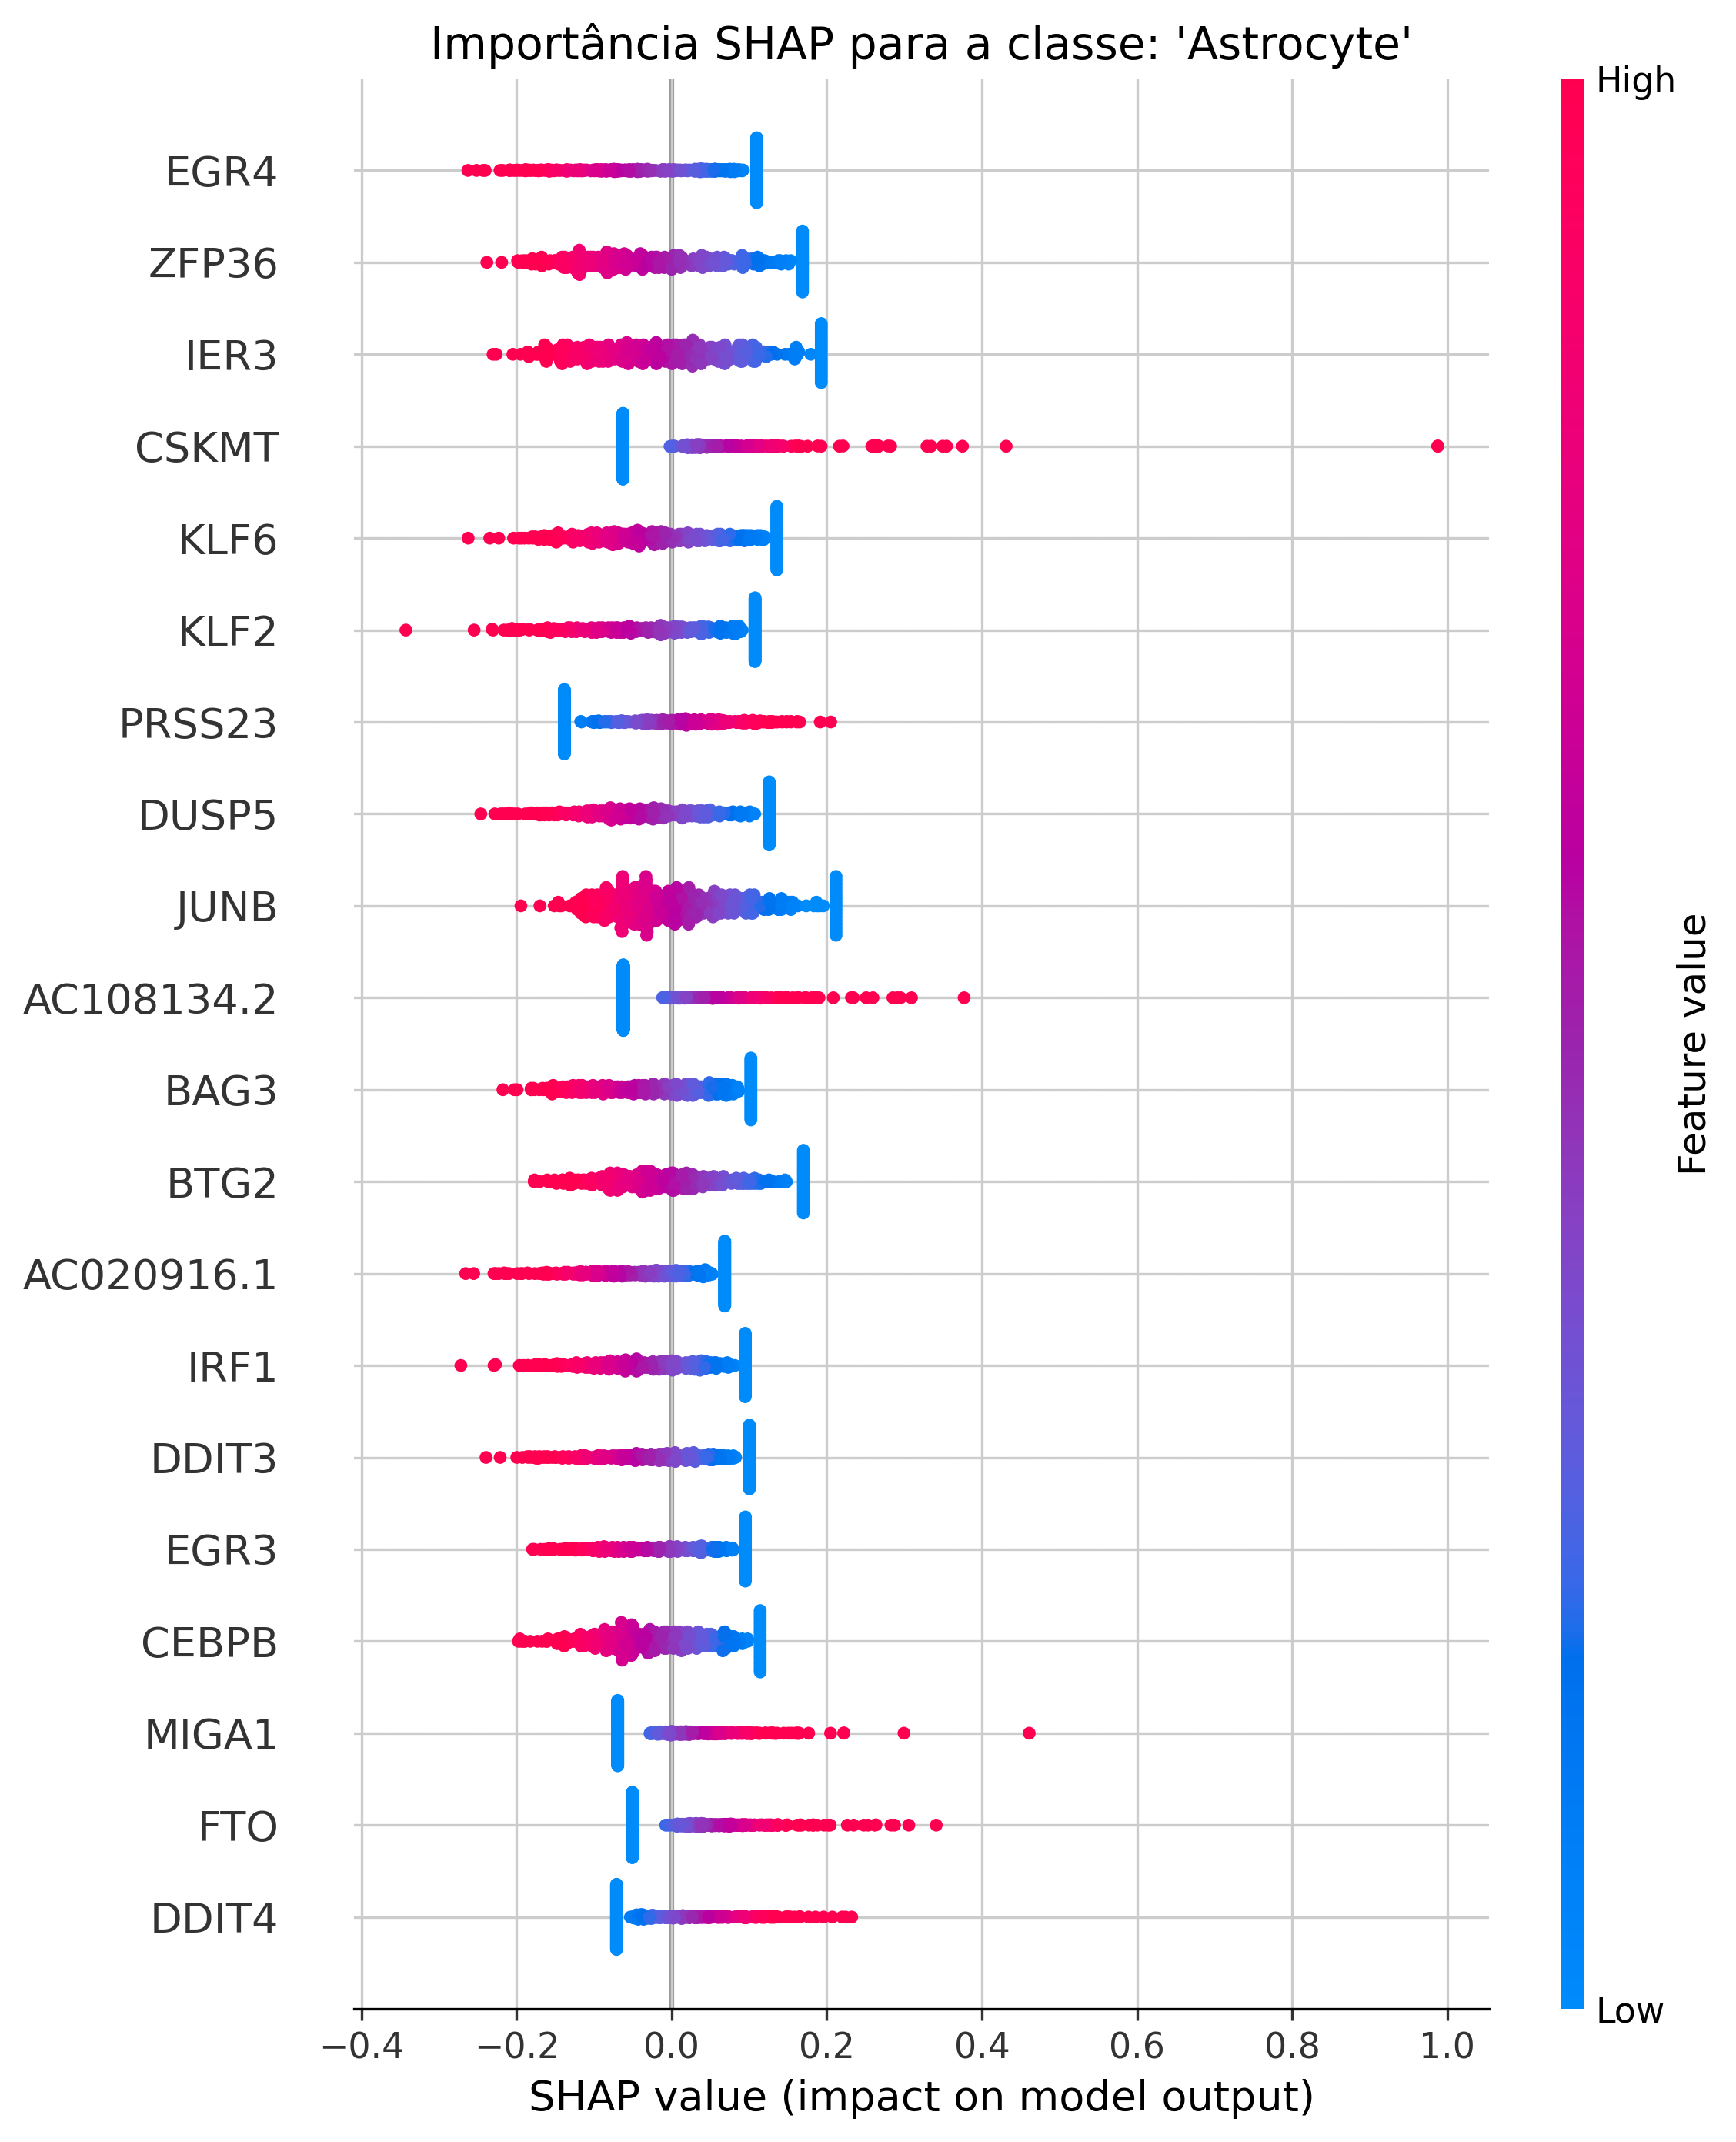


Plotando SHAP Summary Plot para a classe: 'B cell'


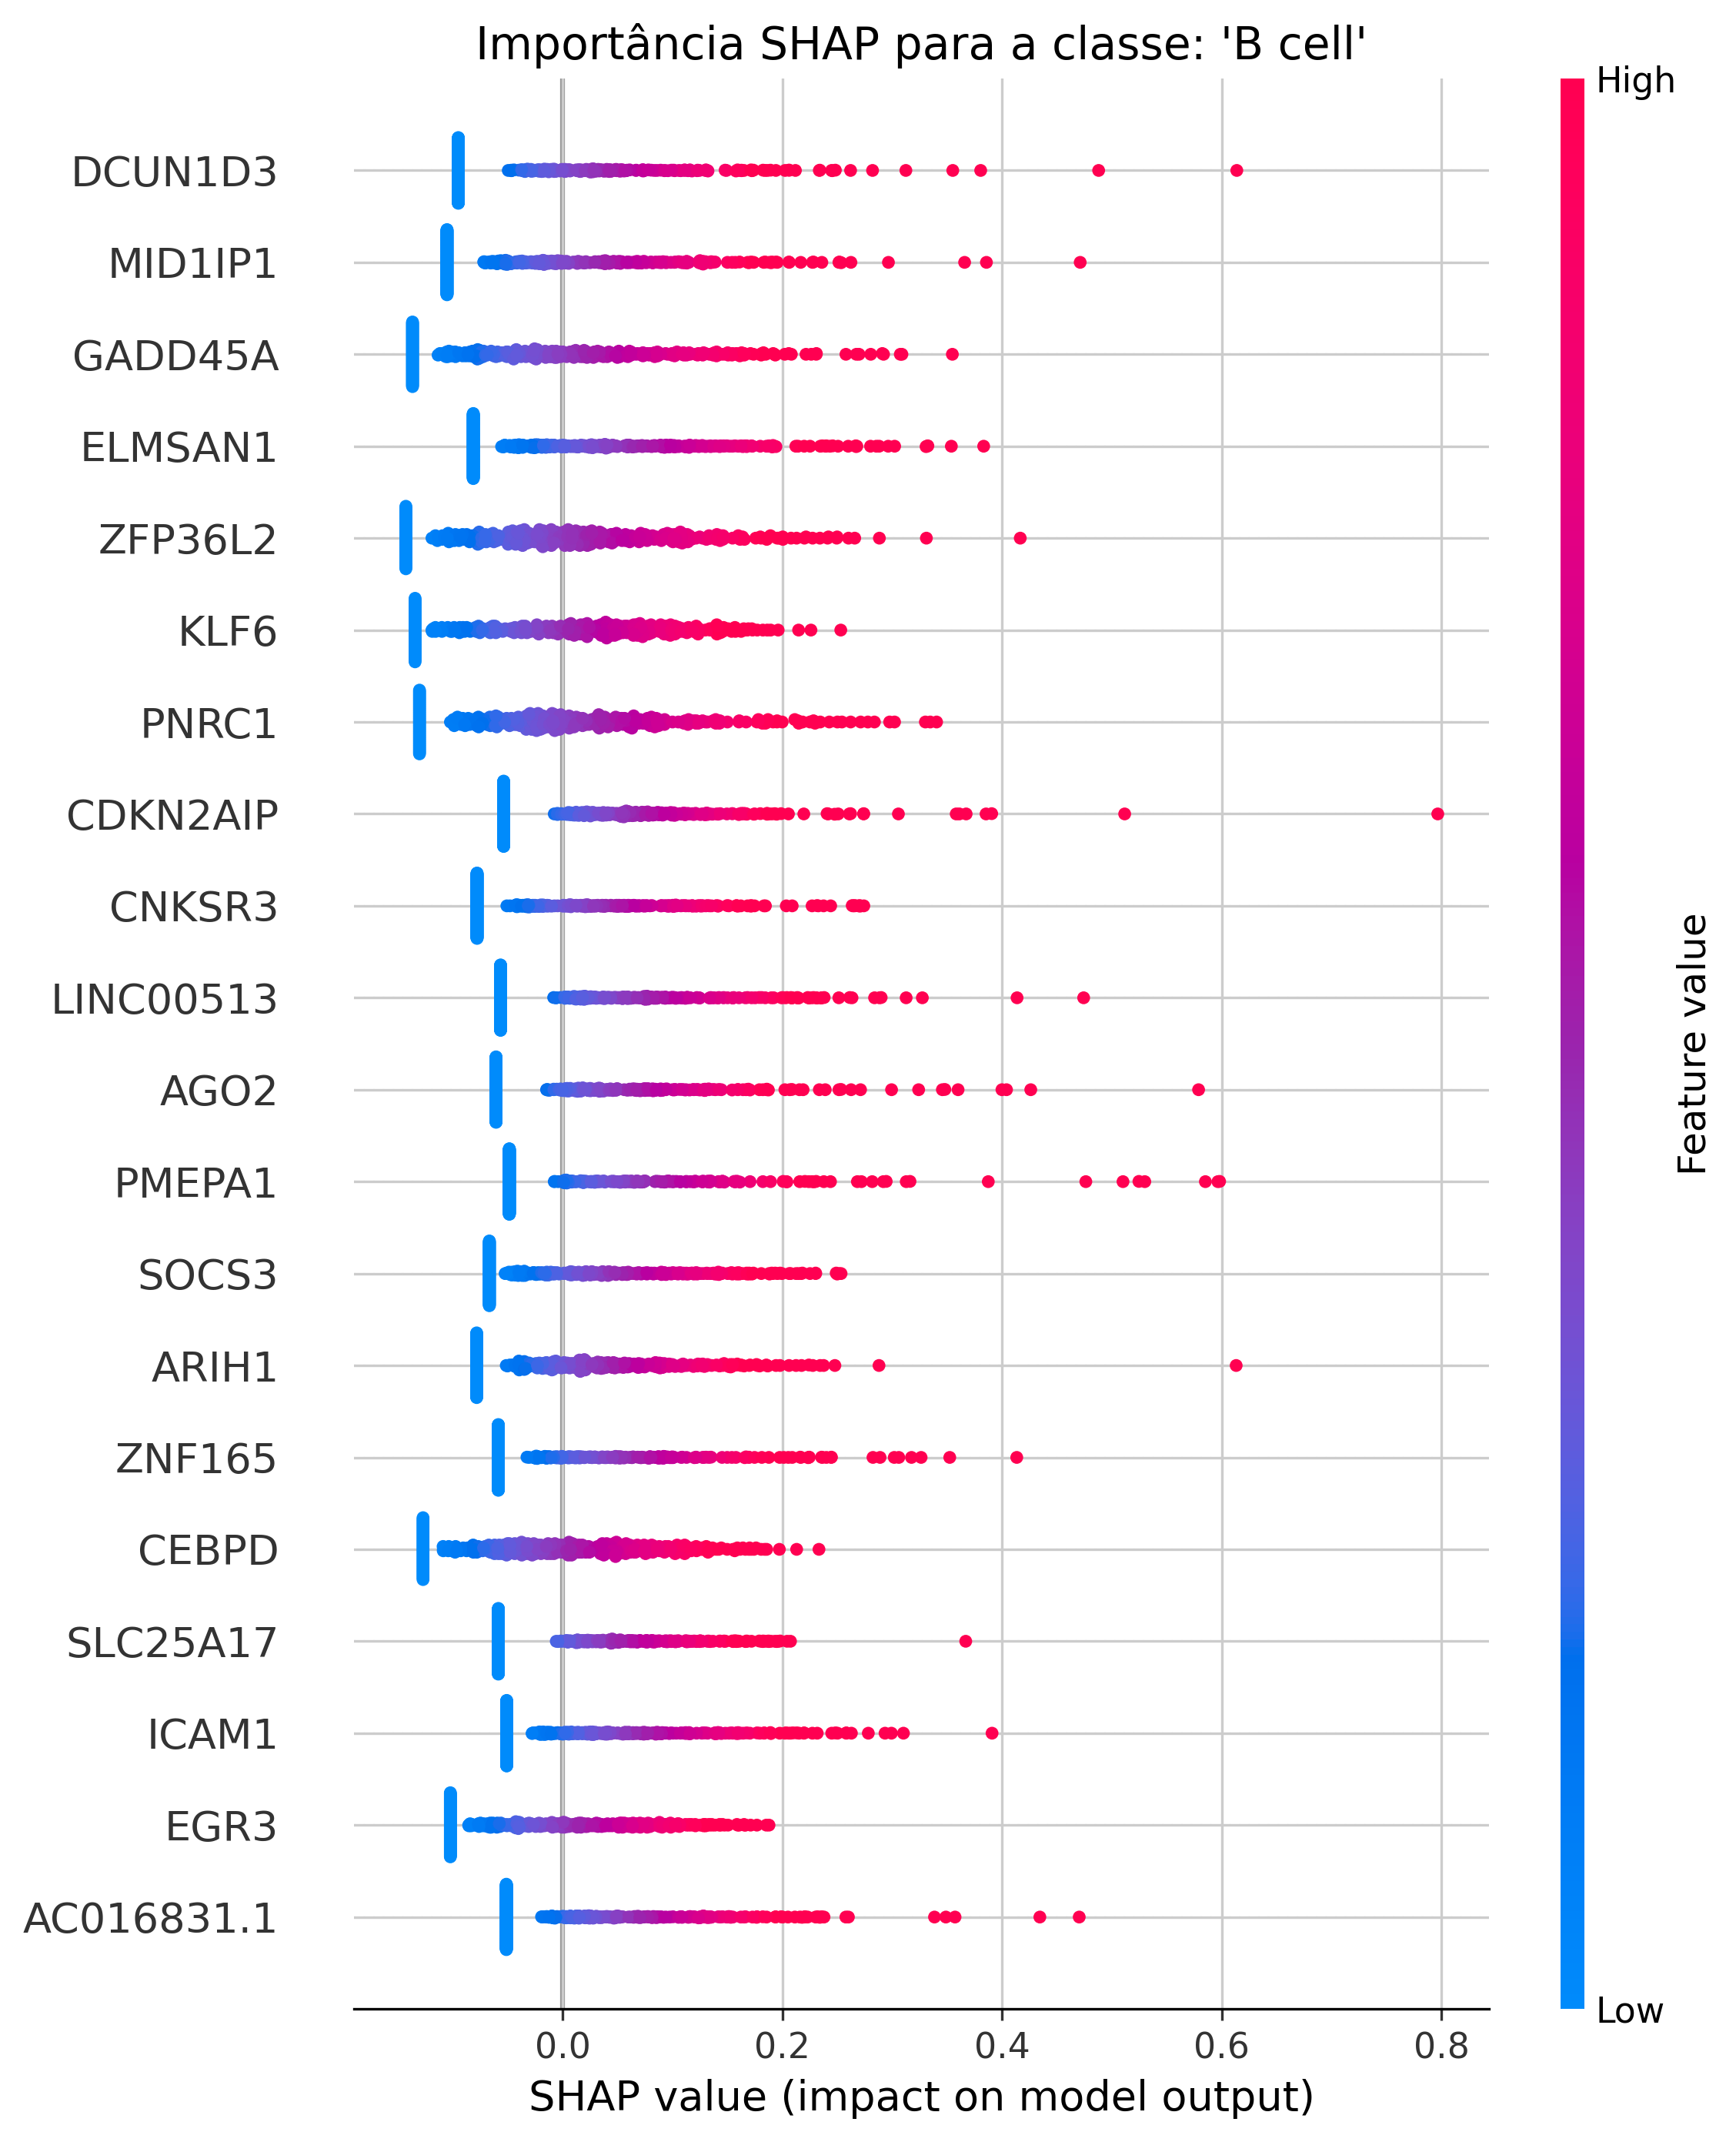


Plotando SHAP Summary Plot para a classe: 'Endothelial cell'


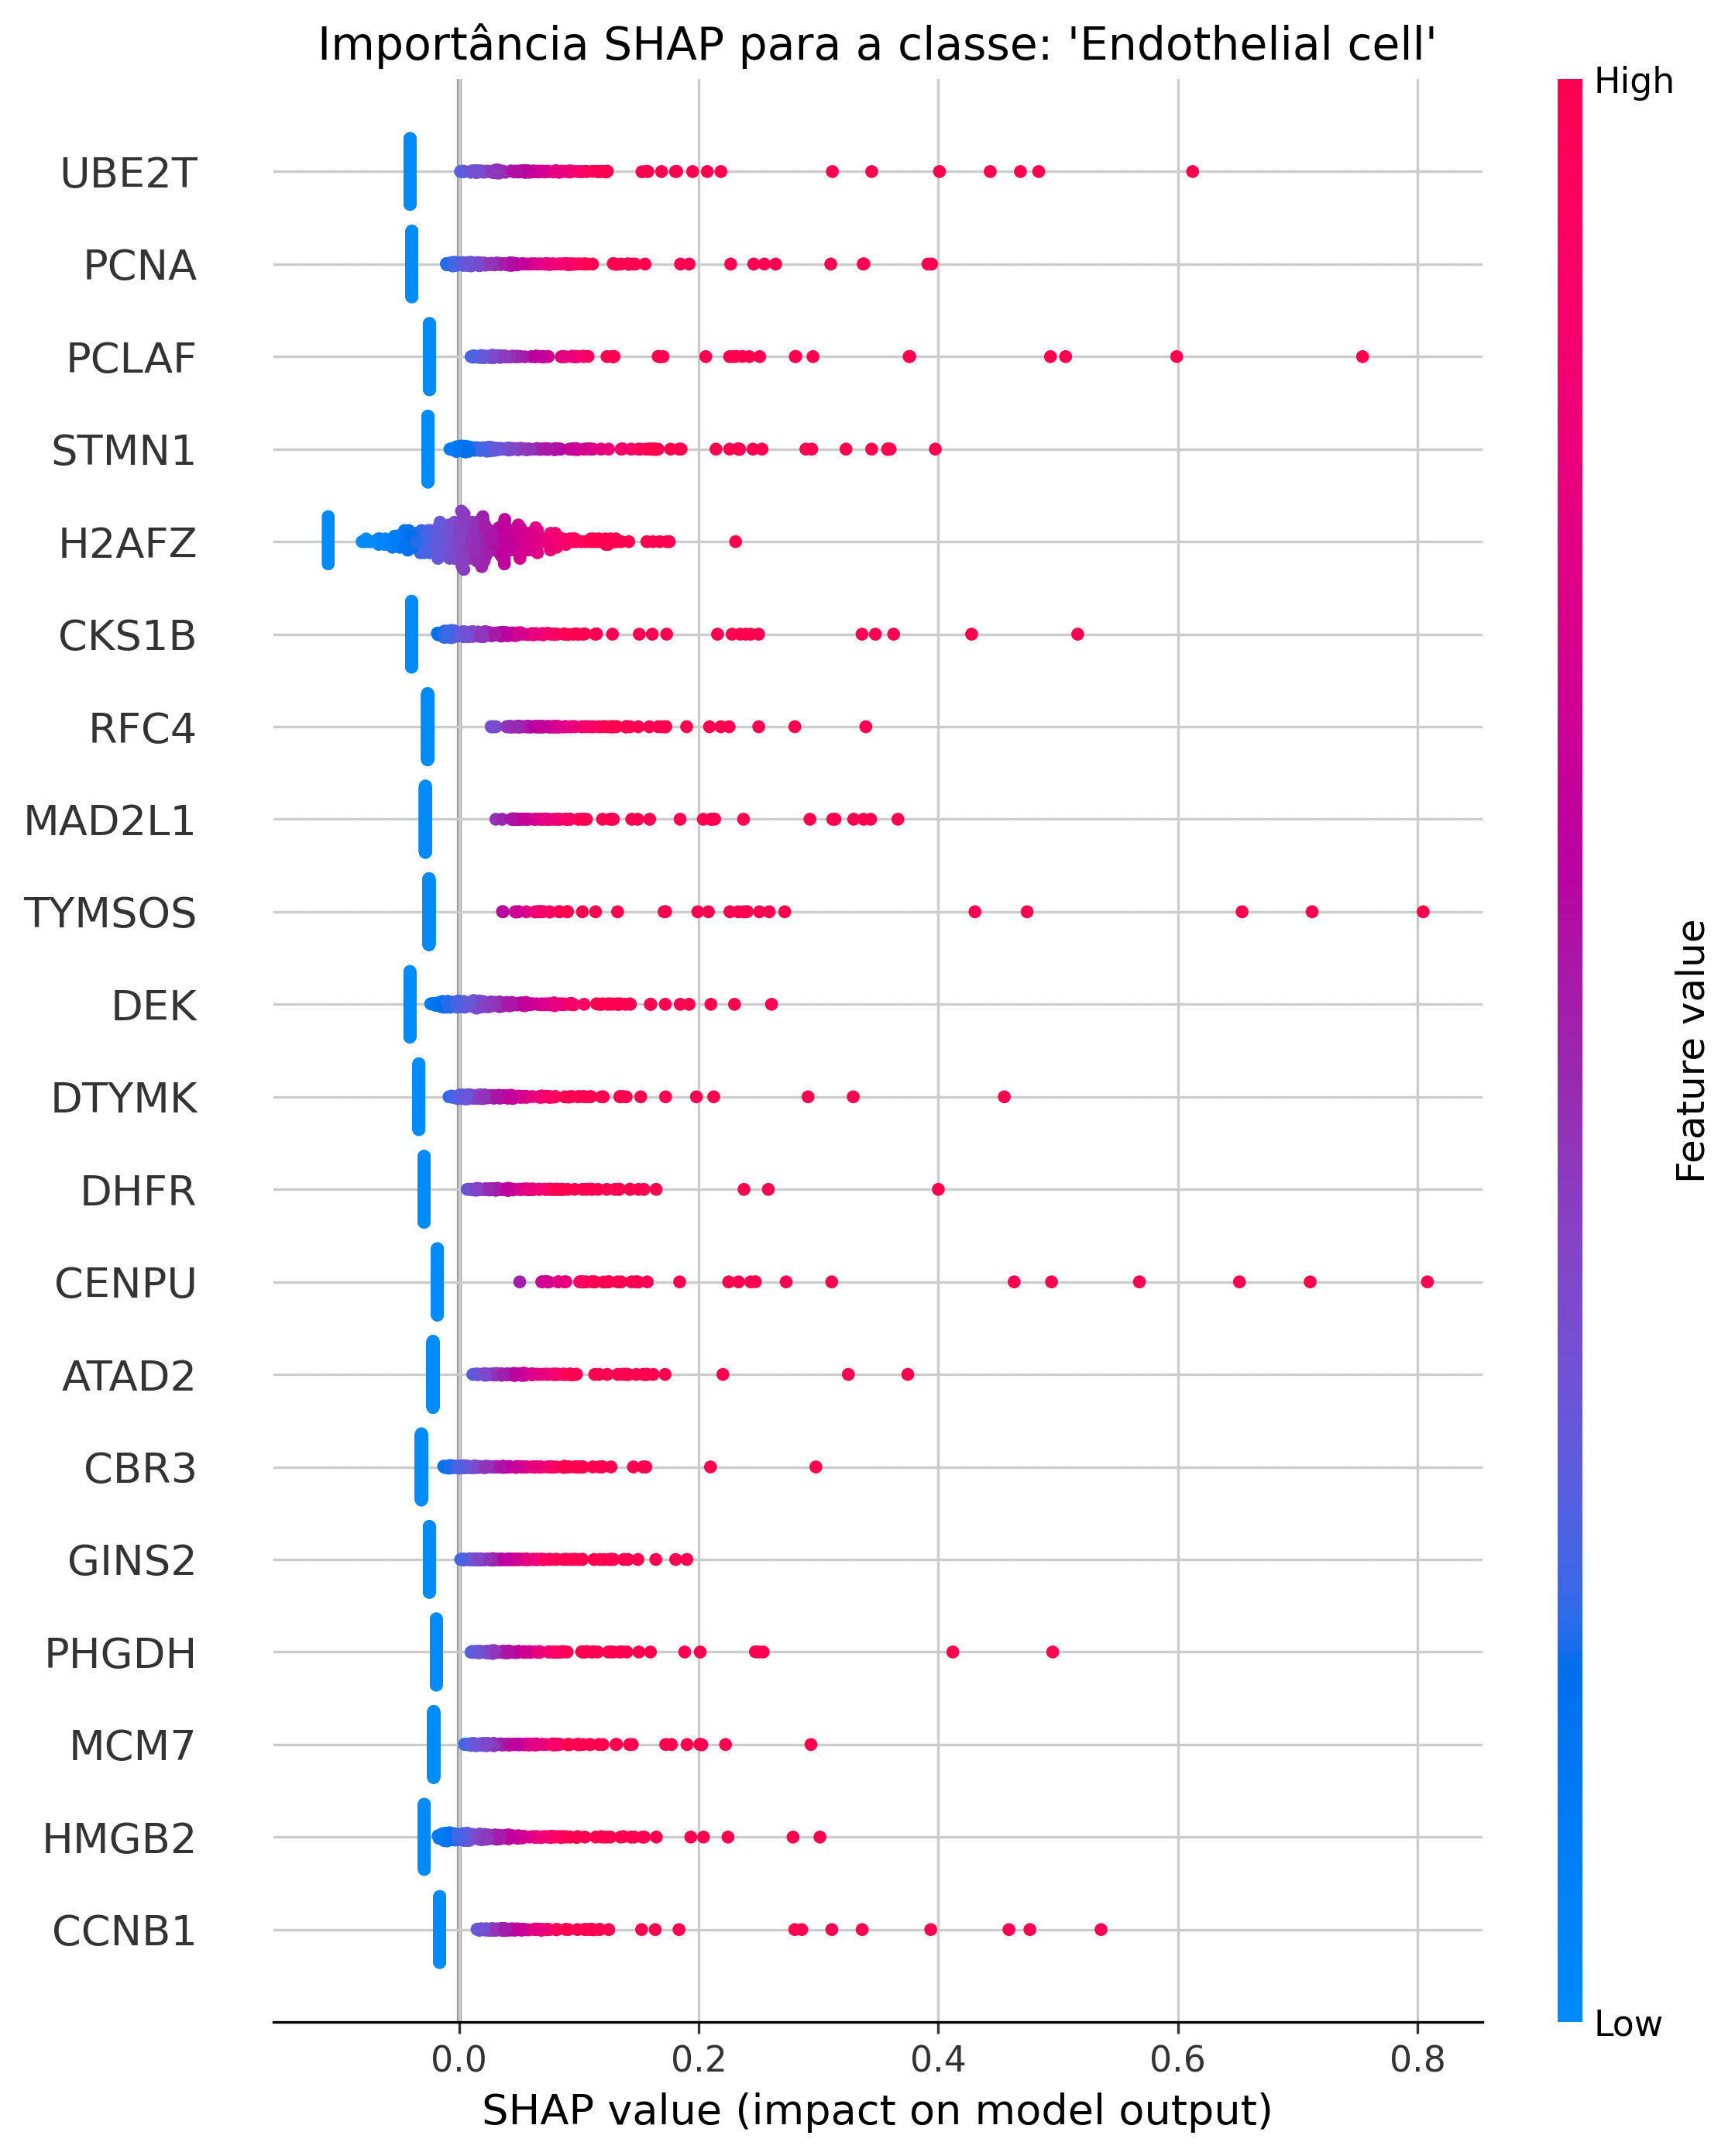


Plotando SHAP Summary Plot para a classe: 'Epithelial cell'


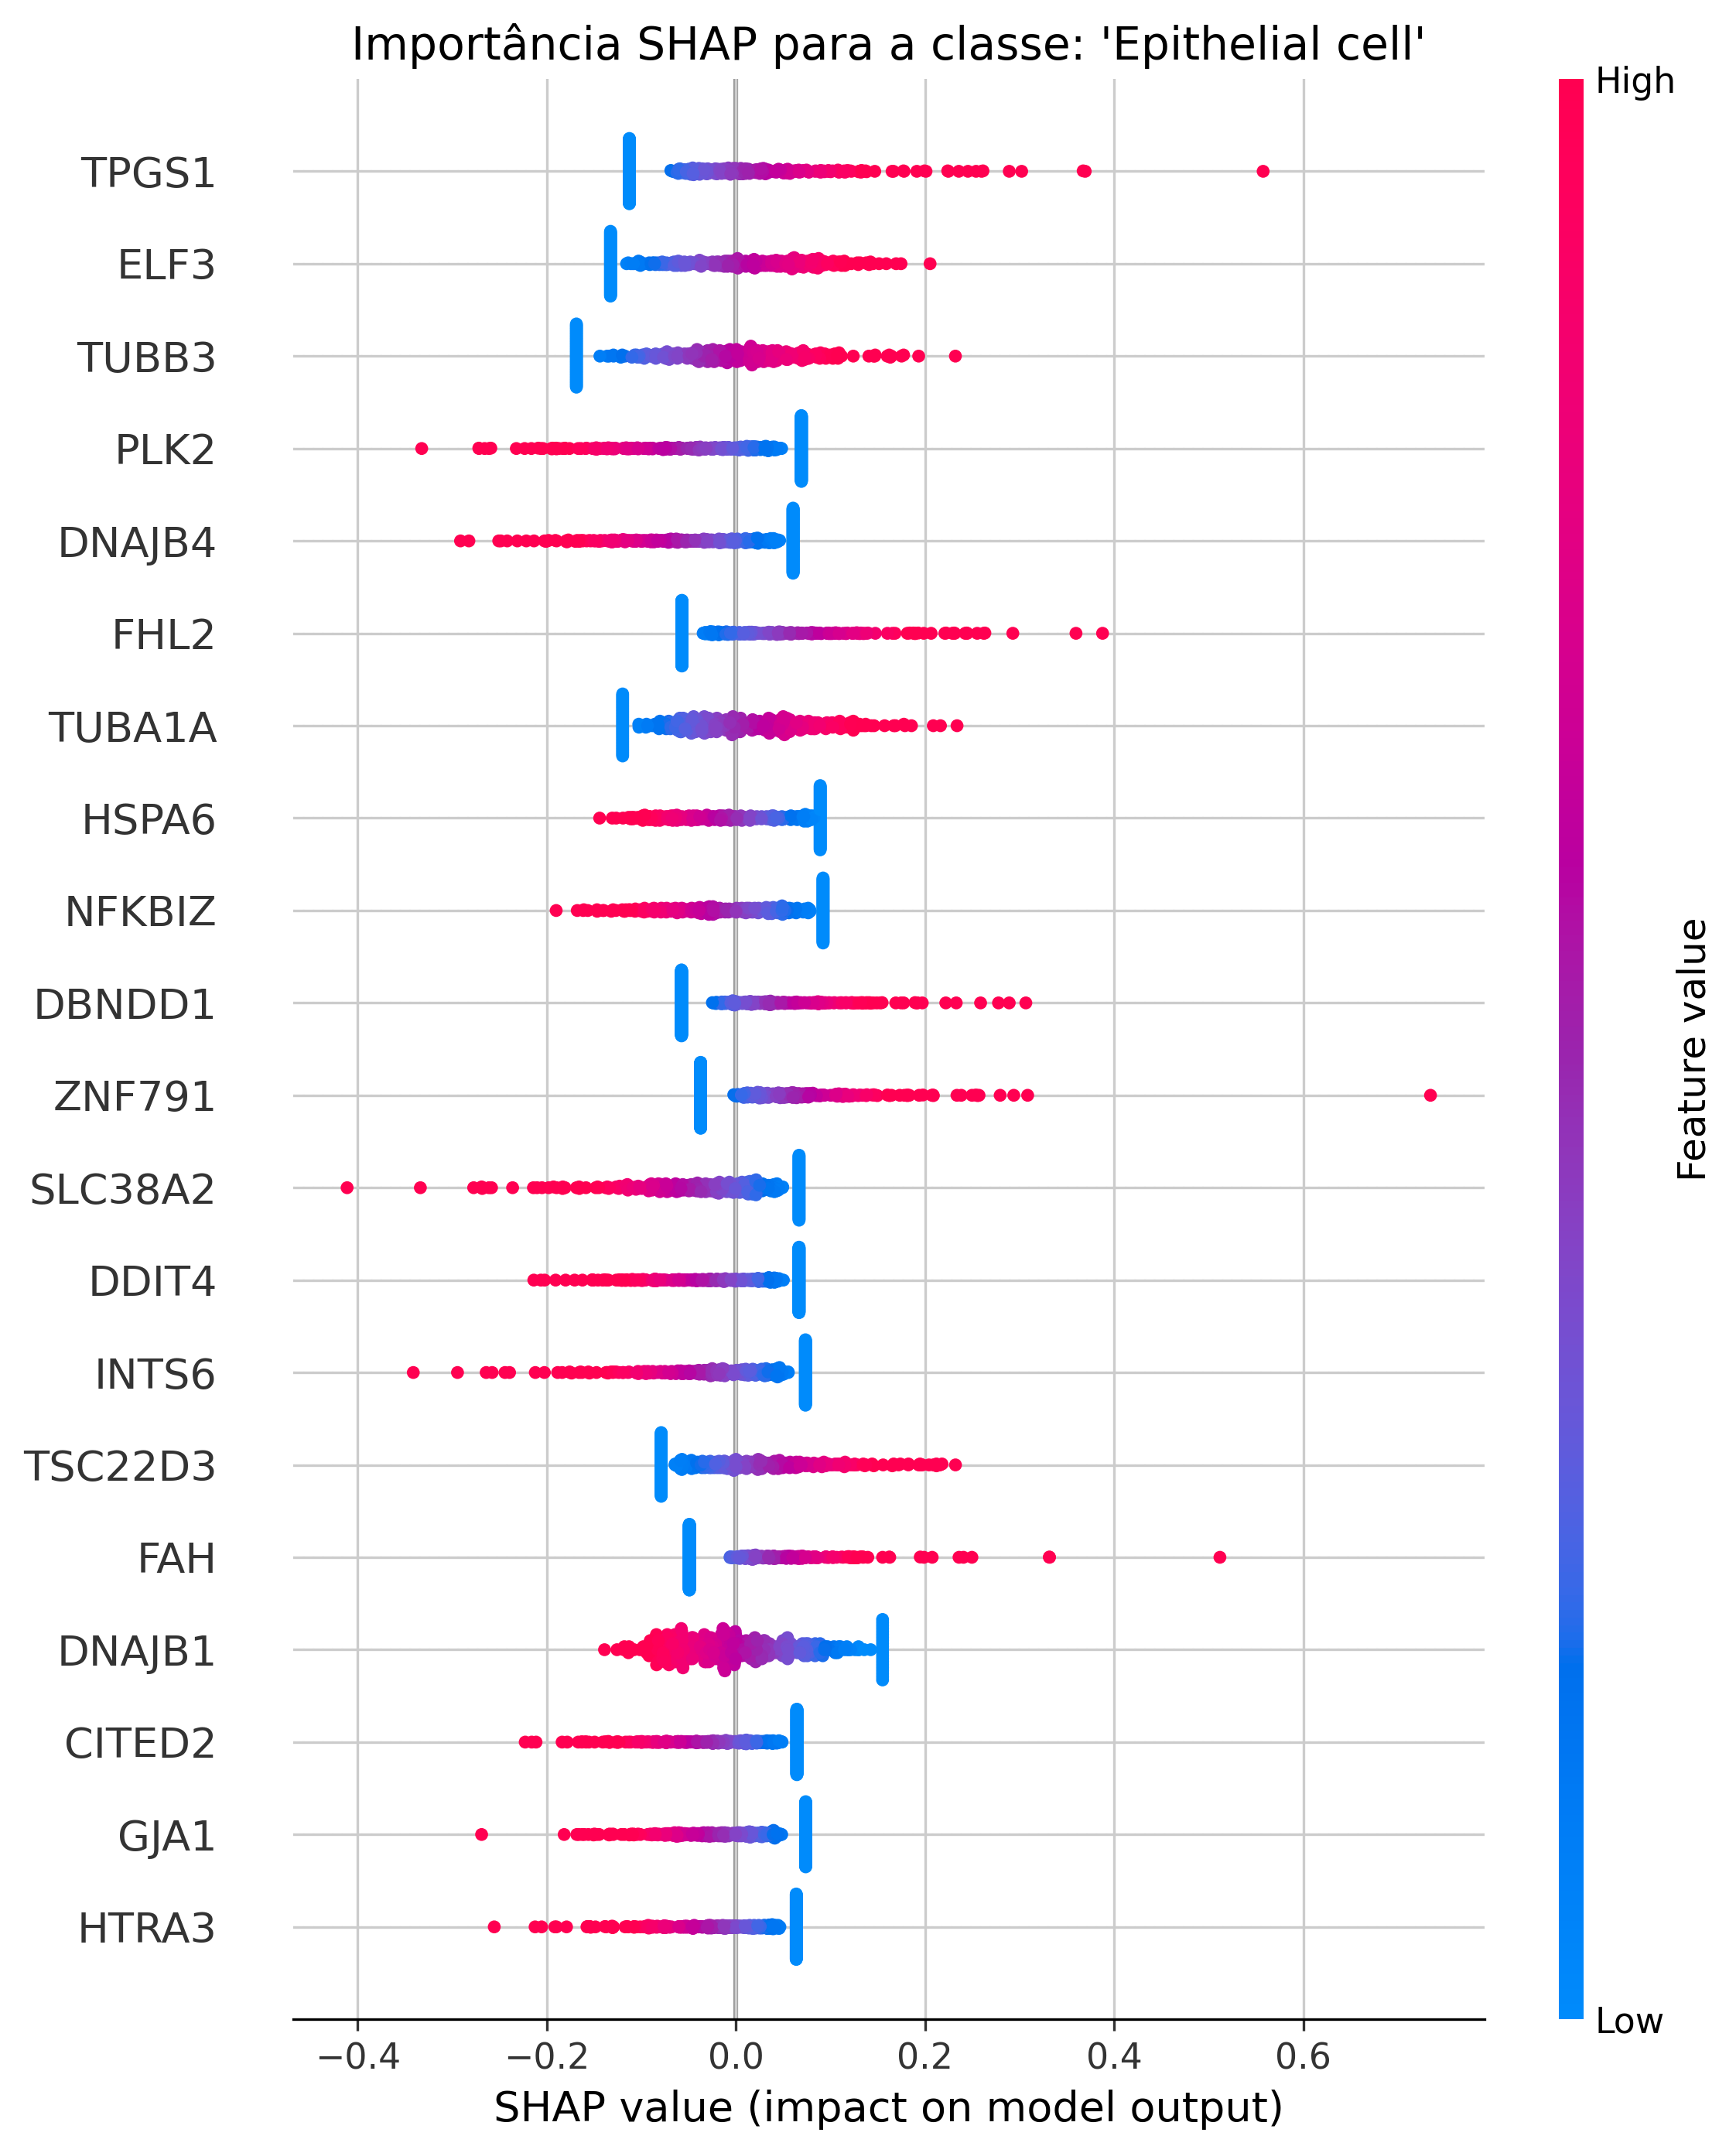


Plotando SHAP Summary Plot para a classe: 'Macrophage'


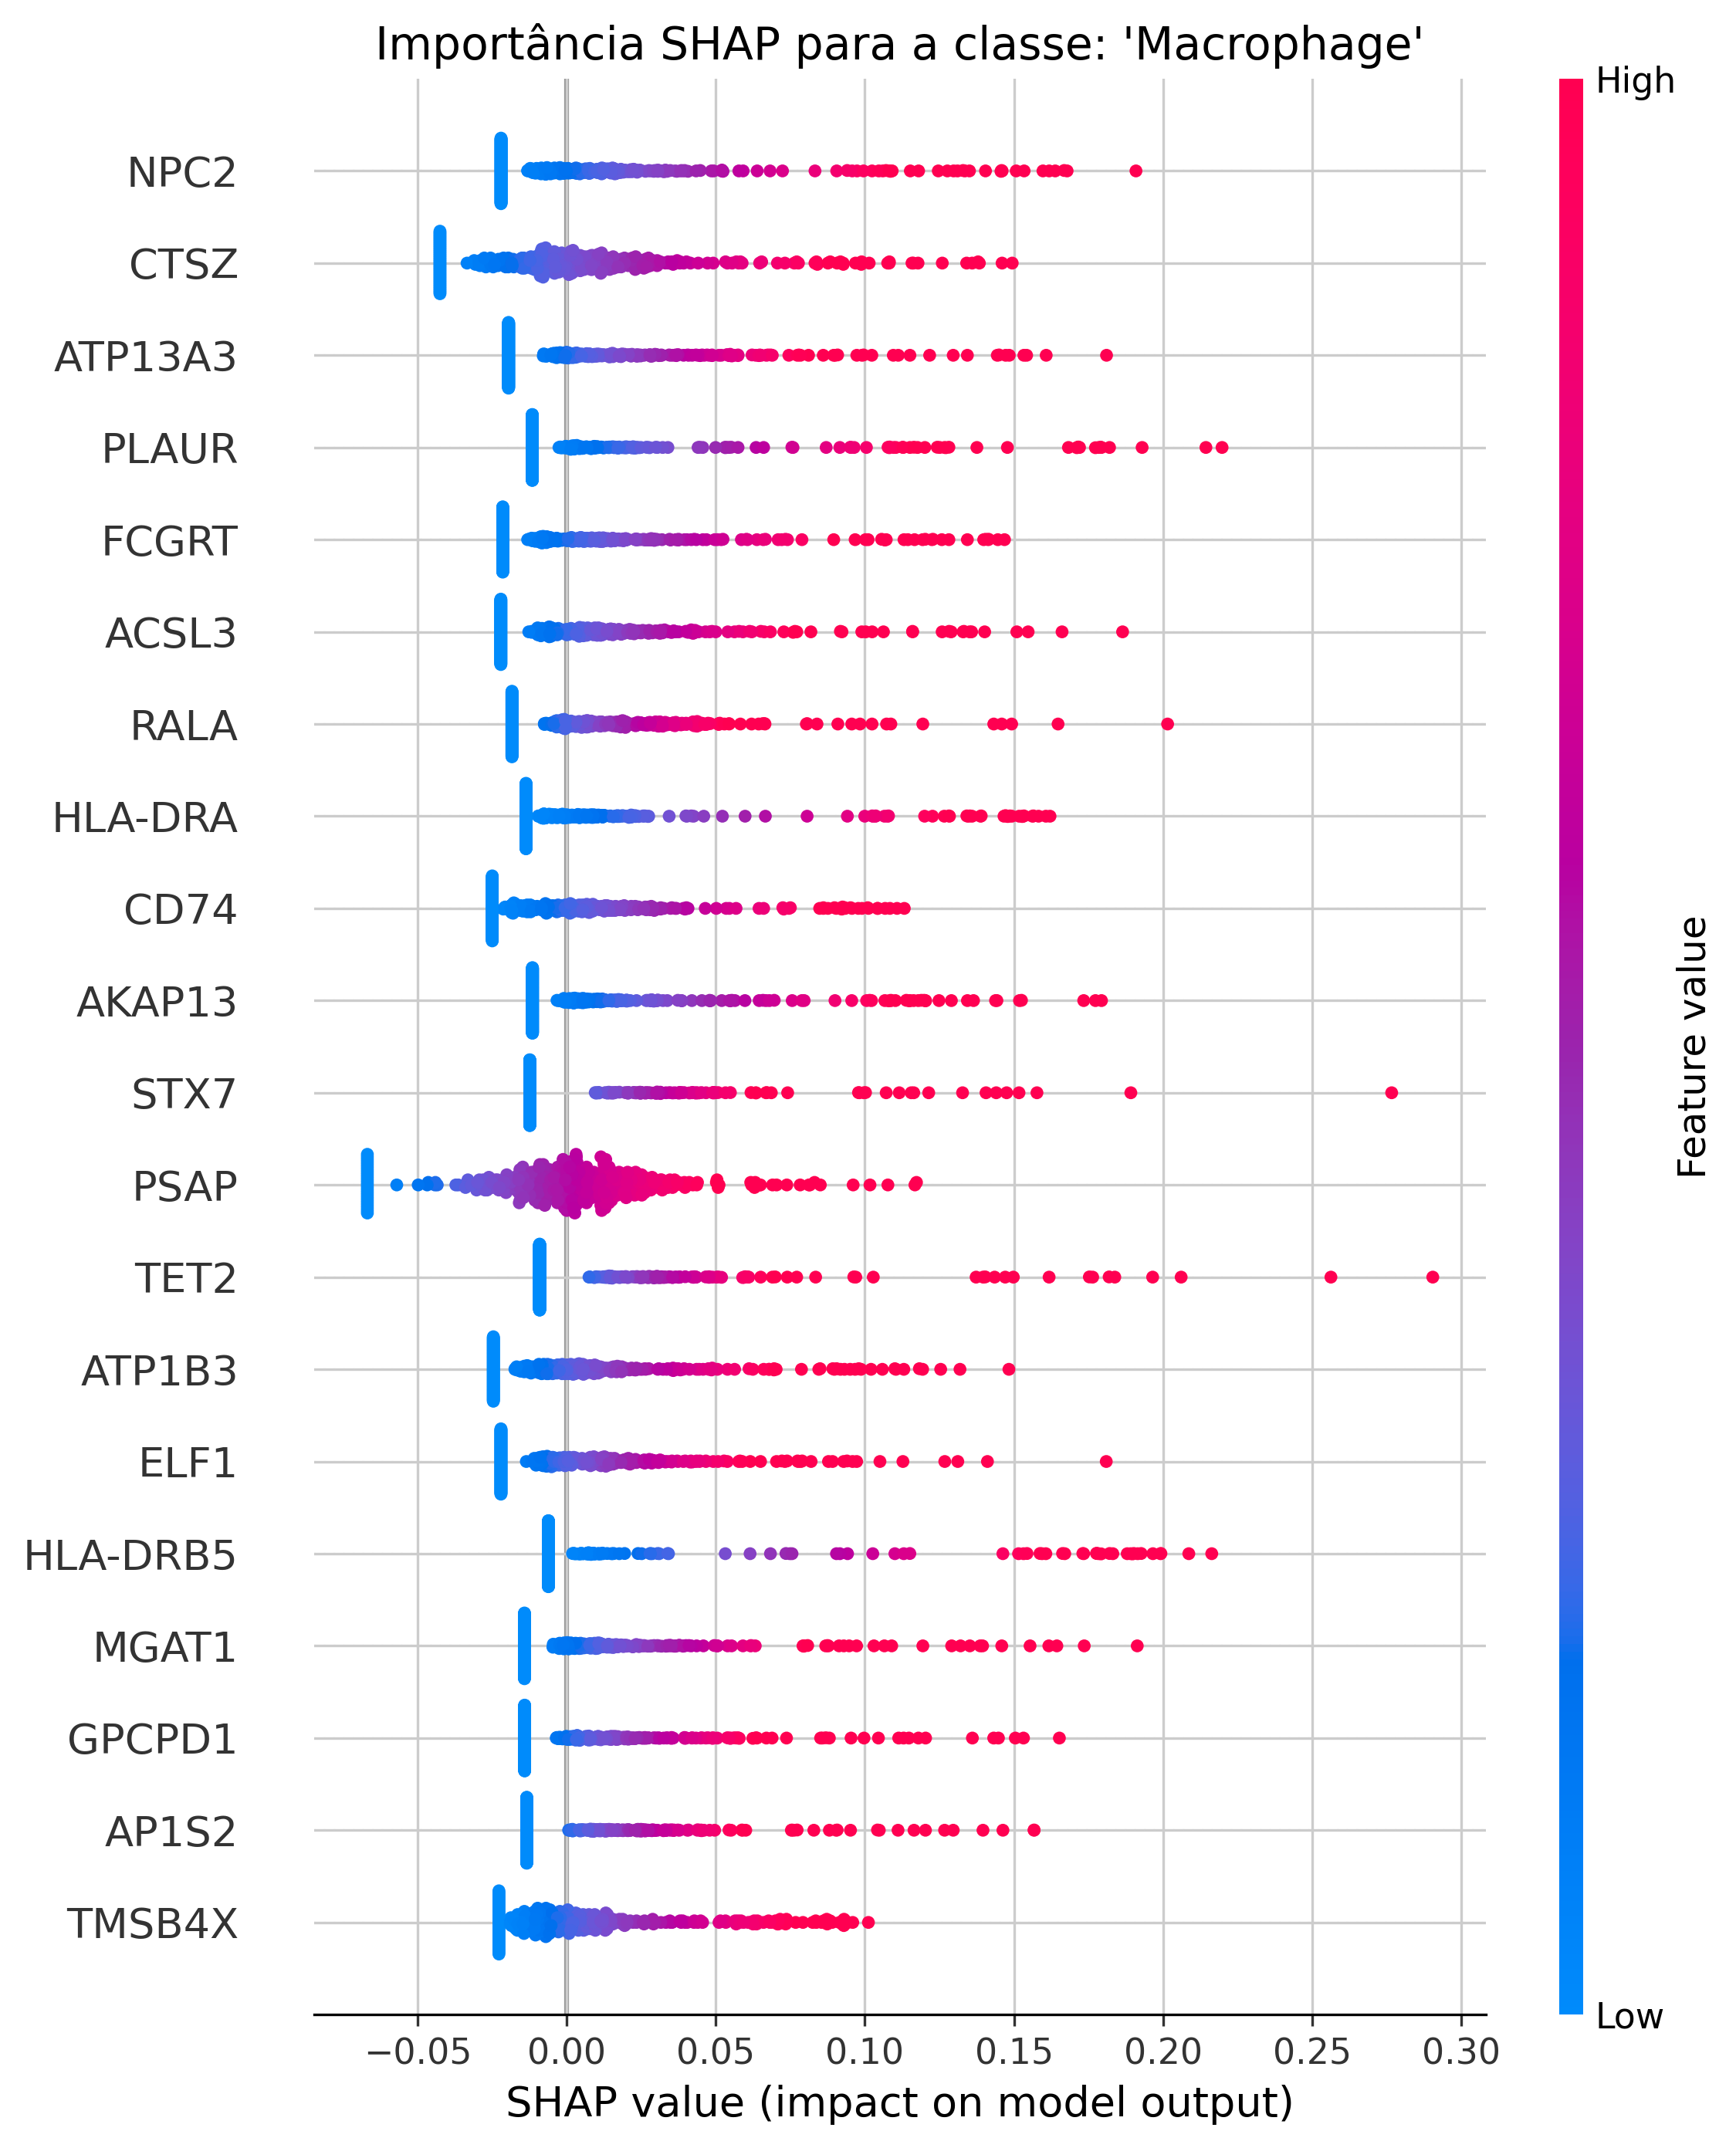

Pulando plots SHAP para classes após as primeiras 5 (Total de classes: 10).

Plotando SHAP Dependence Plot para o gene mais importante da primeira classe: 'EGR4'


Exception ignored in: <function _ConnectionBase.__del__ at 0x7f0ec6f27f60>
Traceback (most recent call last):
  File "/home/fnunes/miniconda3/lib/python3.12/multiprocessing/connection.py", line 133, in __del__
    self._close()
  File "/home/fnunes/miniconda3/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/fnunes/miniconda3/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/home/fnunes/miniconda3/lib/python3.12/multiprocessing/connection.py", line 178, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/fnunes/miniconda3/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/home/fnunes/miniconda3/lib/python3.12/multiprocessing/connection.py", line 178, in close
Exception in thread QueueFeederThread:


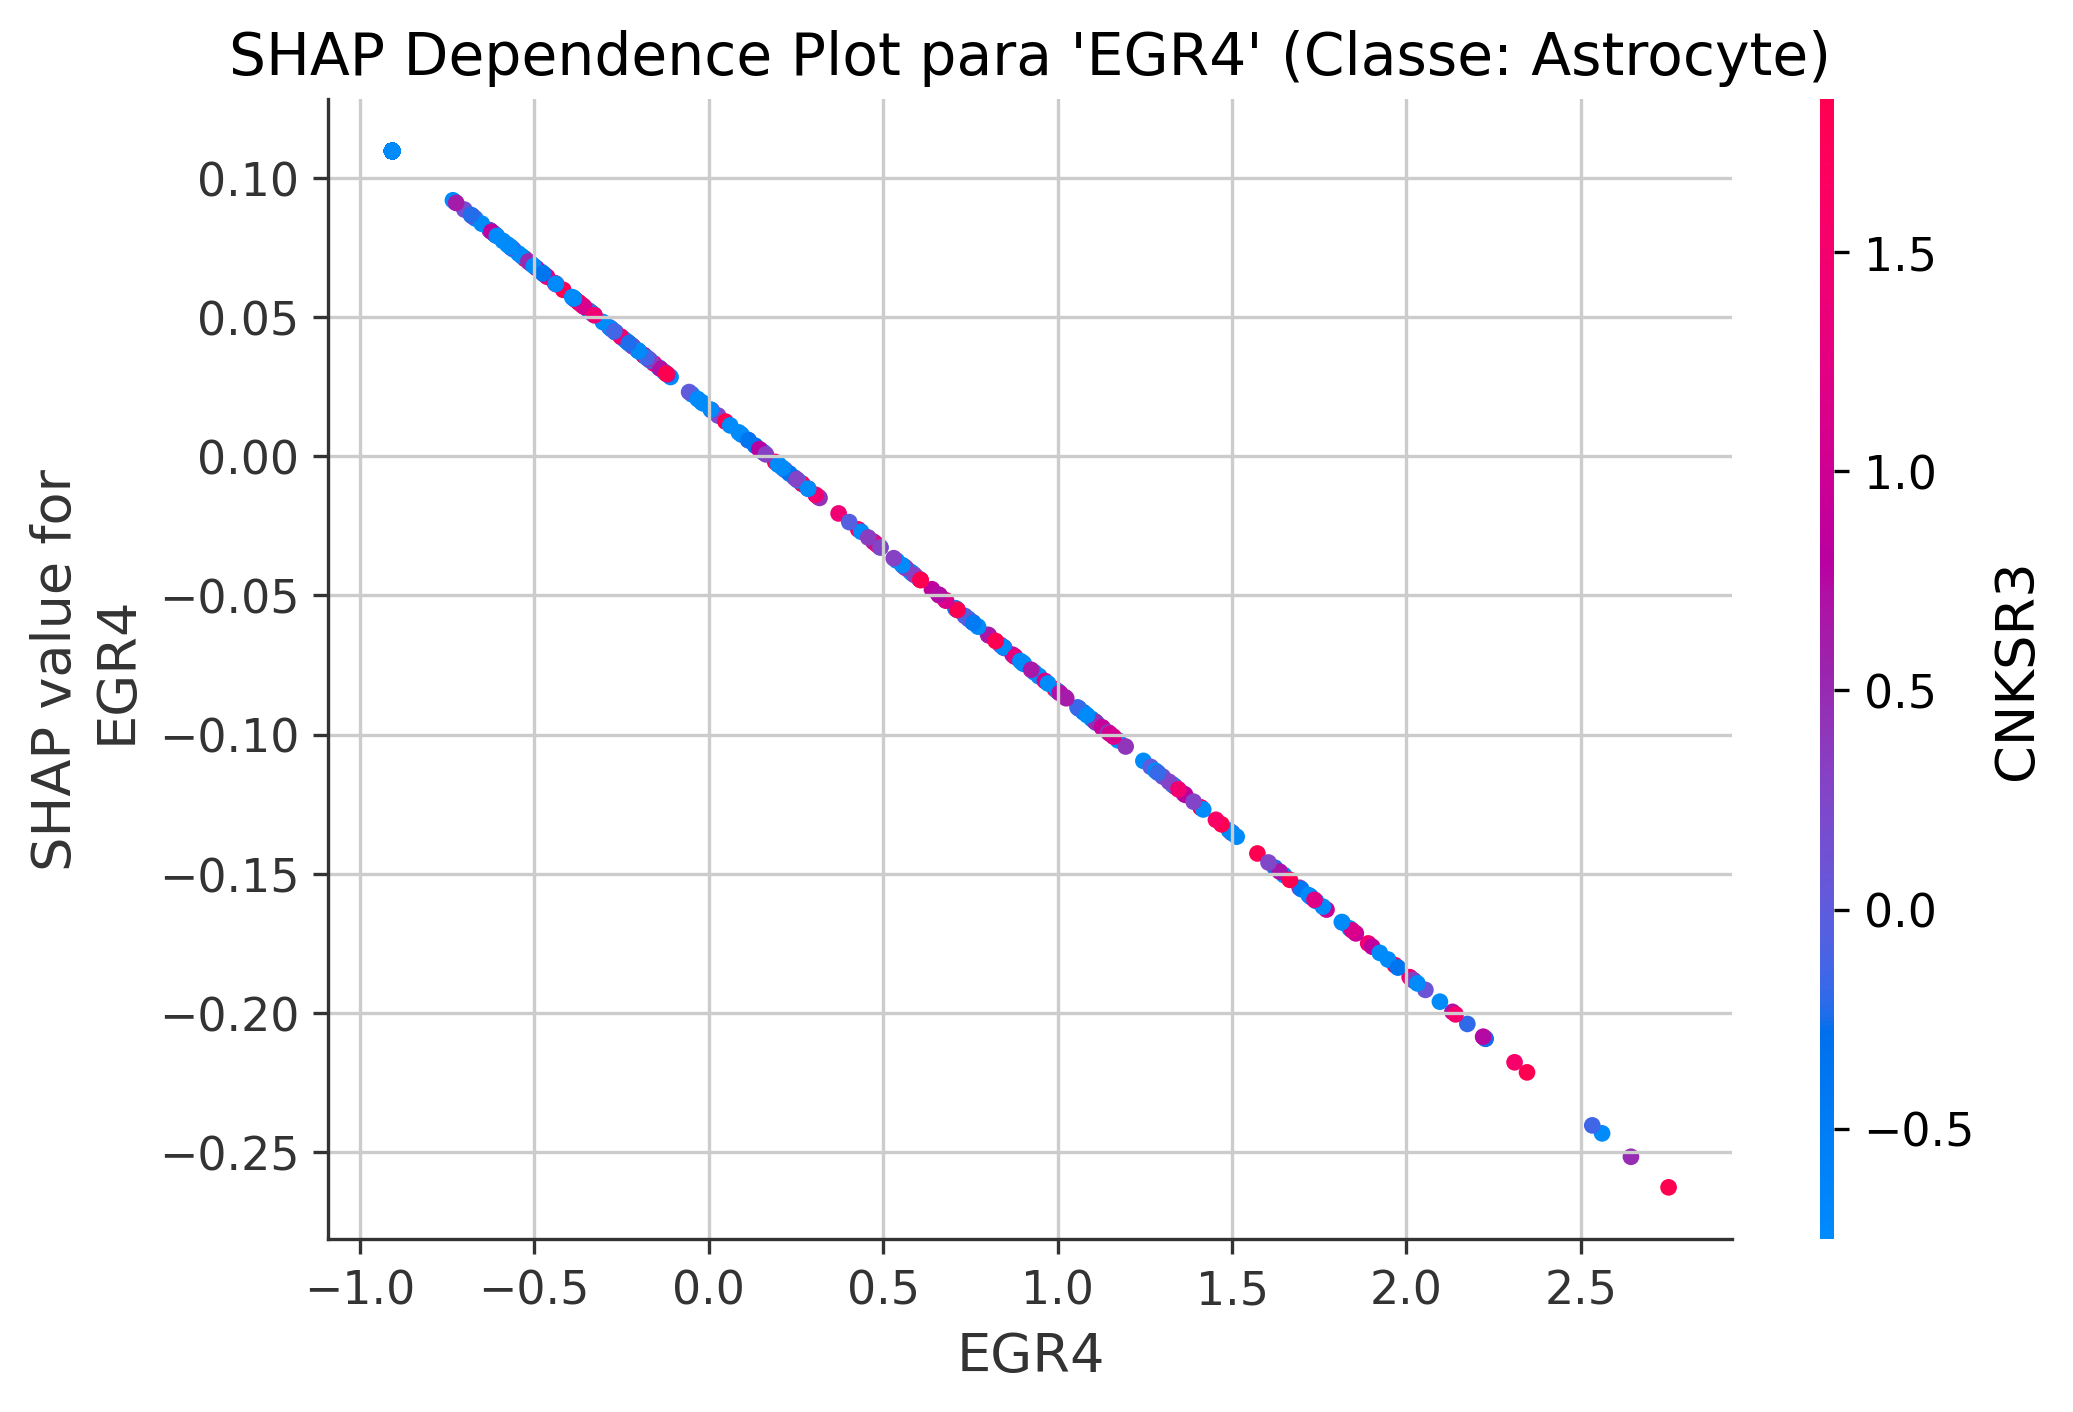

In [158]:
if first_fold_trained_model is not None and first_fold_test_data is not None:

    background = X[np.random.choice(X.shape[0], min(100, X.shape[0]), replace=False)].cpu()

    first_fold_trained_model.eval()
    first_fold_trained_model.cpu()

    e = shap.DeepExplainer(first_fold_trained_model, background)
    
    num_shap_samples = min(500, first_fold_test_data.shape[0])
    shap_test_data = first_fold_test_data[np.random.choice(first_fold_test_data.shape[0], num_shap_samples, replace=False)].cpu()
    
    raw_shap_values_array = e.shap_values(shap_test_data, check_additivity=False)
    
    print(f"\n valores SHAP para {num_shap_samples} amostras do conjunto de teste da primeira fold.")
    print("Tipo de raw_shap_values_array:", type(raw_shap_values_array)) # <class 'numpy.ndarray'>
    print("Shape de raw_shap_values_array:", raw_shap_values_array.shape) # (num_samples, num_features, num_classes)
    
    for i, class_name in enumerate(le.classes_):
        current_shap_values = raw_shap_values_array[:, :, i]
    
        if current_shap_values.shape[0] != shap_test_data.shape[0] or \
           current_shap_values.shape[1] != shap_test_data.shape[1]:
            print(f"ERRO CRÍTICO (PÓS-CORREÇÃO): Discrepância de features entre current_shap_values ({current_shap_values.shape}) e shap_test_data ({shap_test_data.shape})")
            print("Não é possível gerar o plot SHAP para esta classe. Verifique o alinhamento das features.")
            continue
    
        # Limitar o número de plots
        if i >= min(len(le.classes_), 5):
            print(f"Pulando plots SHAP para classes após as primeiras {min(len(le.classes_), 5)} (Total de classes: {len(le.classes_)}).")
            break
        
        print(f"\nPlotando SHAP Summary Plot para a classe: '{class_name}'")
        shap.summary_plot(current_shap_values, shap_test_data.cpu().numpy(),
                          feature_names=feature_names_hvgs,
                          class_names=target_names_str,
                          max_display=20,
                          show=False)
        plt.title(f"Importância SHAP para a classe: '{class_name}'")
        plt.tight_layout()
        plt.show()
    
    if num_shap_samples > 0 and len(feature_names_hvgs) > 0 and raw_shap_values_array.shape[2] > 0:
        try:
            # Pega os valores SHAP índice 0
            current_shap_values_class0 = raw_shap_values_array[:, :, 0] # Fatiamento similar
    
            if current_shap_values_class0.ndim > 1:
                avg_abs_shap = np.mean(np.abs(current_shap_values_class0), axis=0)
                most_important_gene_idx = np.argmax(avg_abs_shap)
                
                if most_important_gene_idx < len(feature_names_hvgs):
                    most_important_gene = feature_names_hvgs[most_important_gene_idx]
    
                    print(f"\n Dependence Plot para o gene mais importante da primeira classe: '{most_important_gene}'")
                    shap.dependence_plot(most_important_gene_idx, current_shap_values_class0, shap_test_data.cpu().numpy(),
                                        feature_names=feature_names_hvgs, show=False)
                    plt.title(f"SHAP Dependence Plot para '{most_important_gene}' (Classe: {le.classes_[0]})")
                    plt.show()
                else:
                    print("Índice do gene mais importante fora dos limites para Dependence Plot.")
            else:
                print("formato errado para current_shap_values_class0. Não é possível gerar dependence plot")
        except Exception as e:
            print(f"Não foi possível gerar Dependence Plot para o gene mais importante: {e}")
            print("verifique se o array de shap_values tem o formato correto")
    else:
        print("\n dados insuficientes ou erro na saída do deepExplainer")

# enriquecimento funcional
# analise correlação de pearson
# expressão diferencial